# TABLE OF CONTENTS:
---
* [Notebook Summary](#Notebook-Summary)
* [Setup](#Setup)
    * [Notebook Parameters](#Notebook-Parameters)
    * [Connect to Workspace](#Connect-to-Workspace)
* [Data](#Data)
    * [Overview](#Overview)
    * [Download & Extract Data](#Download-&-Extract-Data)
    * [Upload Data & Create AML Dataset](#Upload-Data-&-Create-AML-Dataset)
    * [Explore Data](#Explore-Data)
    * [Register AML Dataset](#Register-AML-Dataset)
---

# Notebook Summary

In this notebook, you will download the [Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/) from the Stanford Vision website to your Azure Machine Learning (AML) Compute Instance (CI) (or alternatively to any other local compute target) and then upload it to the AML workspace default blob storage. You will also create an AML file dataset that can be used for easy data access throughout the ML lifecycle.
An AML dataset is a pointer to an Azure datastore location and can be used to retrieve files/data from that Azure datastore during model training. It allows to have end-to-end lineage from the trained model back to the data, e.g. you can track during model training the version of data that a particular model was trained on. The file dataset class, which is used here, can be used for unstructured data (e.g. here jpg images). If you are working with tabular data, please use the tabular dataset instead. The dataset classes facilitate access to the respective data and ensure reproducability and data lineage. For more information on AML datasets in general, have a look at https://docs.microsoft.com/en-us/azure/machine-learning/how-to-create-register-datasets.

**Note**: Run this notebook from the Jupyter kernel that has been created in `00_environment_setup`.

# Setup

Append parent directory to sys path to be able to import created modules from src directory.

In [1]:
import sys
sys.path.append(os.path.dirname(os.path.abspath("")))

Automatically reload modules when changes are made.

In [2]:
%load_ext autoreload
%autoreload 2

Import libraries and modules.

In [3]:
# Import libraries
import azureml.core
import torchvision
from azureml.core import Dataset, Workspace

# Import created modules
from src.utils import download_stanford_dogs_archives, extract_stanford_dogs_archives
from src.utils import get_mean_std, load_data, load_unnormalized_train_data
from src.utils import show_image, show_batch_of_images

print(f"azureml.core version: {azureml.core.VERSION}")

azureml.core version: 1.20.0


### Notebook Parameters

Specify the notebook parameters which are used in the source code below.

In [4]:
# Specify data source directory
data_src_dir = "../data"

# Specify data store target path
datastore_target_path = "data/stanford_dogs"

# Specify dataset name
dataset_name = "stanford_dogs_dataset"

# Specify dataset description
dataset_description = "Stanford Dogs Dataset containing training, validation and test data"

# Specify dataset tags
dataset_tags = {"file_format": "jpg",
                "file_path_example": "data/stanford_dogs/val/n02085620-Chihuahua/n02085620_1152.jpg"}

# Specify path to an example of model input data
data_example_path = "../data/val/n02085620-Chihuahua/n02085620_1152.jpg"

### Connect to Workspace

In order to connect and communicate with the AML workspace, a workspace object needs to be instantiated using the AML Python SDK.

In [5]:
# Connect to the AML workspace using interactive authentication
ws = Workspace.from_config()

# Data

### Overview

The [Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/) is an image dataset that will be used to train a multiclass dog breed classification model. In total there are 120 different dog breeds/classes and 20,580 images. The dataset has been built using images and annotations from ImageNet for the task of fine-grained image categorization. The images are three-channel color images of variable pixels in size. While a file with a given train/test split can be downloaded from the website, the train dataset will be further split into a validation and train set (80:20). This will ultimately lead into a data distribution as follows:
- 9600 training images (47.65%)
- 2400 validation images (11.66%)
- 8580 test images (41.69%)

### Download & Extract Data

First, download the data to the local compute. If you are using an AML CI, the data will be downloaded to the AML file share that is mounted to all AML CI's in the AML workspace.

A utility file with functions to download the dogs dataset archive files from the Stanford Vision website and to extract the archives into a format expected by the [torchvision.datasets.ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) has been created (`<PROJECT_ROOT>/src/utils/data_utils.py`).

**Note**: Running below cells can take a while.

In [6]:
# Download the dataset archive files
download_stanford_dogs_archives()

0it [00:00, ?it/s]

100%|█████████▉| 793321472/793579520 [01:51<00:00, 10504670.60it/s]
0it [00:00, ?it/s]


 68%|██████▊   | 327680/481280 [00:01<00:00, 302300.25it/s]
483328it [00:01, 287312.64it/s]                            


In [7]:
# Extract the dataset archives and remove them after extraction
extract_stanford_dogs_archives()

Directory /mnt/batch/tasks/shared/LS_root/mounts/clusters/mlopstemplatecibfdc24/code/Users/s.birk/pytorch-mlops-template-azure-ml/data/train has been removed.
Directory /mnt/batch/tasks/shared/LS_root/mounts/clusters/mlopstemplatecibfdc24/code/Users/s.birk/pytorch-mlops-template-azure-ml/data/val has been removed.
Directory /mnt/batch/tasks/shared/LS_root/mounts/clusters/mlopstemplatecibfdc24/code/Users/s.birk/pytorch-mlops-template-azure-ml/data/test has been removed.
Lists.tar archive has been extracted successfully.
File lists have been read successfully.
Extracting images.tar archive...


793583616it [02:10, 10504670.60it/s]                               
  1%|          | 149/20701 [01:07<2:03:49,  2.77it/s]


  1%|▏         | 296/20701 [01:54<2:27:34,  2.30it/s]


  2%|▏         | 473/20701 [02:27<1:10:49,  4.76it/s]


  3%|▎         | 640/20701 [02:57<43:27,  7.69it/s]


  4%|▍         | 832/20701 [03:26<40:26,  8.19it/s]


  5%|▍         | 1027/20701 [03:54<46:11,  7.10it/s]


  6%|▌         | 1193/20701 [04:23<1:57:05,  2.78it/s]


  7%|▋         | 1364/20701 [04:51<1:05:43,  4.90it/s]


  7%|▋         | 1530/20701 [05:22<57:34,  5.55it/s]


  8%|▊         | 1707/20701 [05:51<1:10:16,  4.50it/s]


  9%|▉         | 1855/20701 [06:27<52:33,  5.98it/s]


 10%|▉         | 2012/20701 [07:01<1:24:21,  3.69it/s]


 10%|█         | 2171/20701 [07:35<1:16:31,  4.04it/s]


 11%|█▏        | 2333/20701 [08:09<1:16:27,  4.00it/s]


 12%|█▏        | 2483/20701 [08:47<1:09:46,  4.35it/s]


 13%|█▎        | 2649/20701 [09:18<59:06,  5.09it/s]  


 14%|█▎        | 2811/20701 [09:47<51:12,  5.82it/s]


 14%|█▍        | 2979/20701 [10:17<57:26,  5.14it/s]


 15%|█▌        | 3154/20701 [10:44<41:54,  6.98it/s]


 16%|█▌        | 3326/20701 [11:12<41:06,  7.04it/s]


 17%|█▋        | 3521/20701 [11:38<40:48,  7.02it/s]


 18%|█▊        | 3709/20701 [12:04<50:25,  5.62it/s]


 19%|█▉        | 3906/20701 [12:29<41:38,  6.72it/s]


 20%|█▉        | 4083/20701 [12:55<39:41,  6.98it/s]


 21%|██        | 4273/20701 [13:22<1:01:55,  4.42it/s]


 22%|██▏       | 4479/20701 [13:51<33:14,  8.13it/s]


 23%|██▎       | 4661/20701 [14:20<38:58,  6.86it/s]


 23%|██▎       | 4848/20701 [14:48<36:58,  7.15it/s]


 24%|██▍       | 5025/20701 [15:17<57:39,  4.53it/s]


 25%|██▌       | 5186/20701 [15:49<44:03,  5.87it/s]


 26%|██▌       | 5358/20701 [16:18<40:15,  6.35it/s]


 27%|██▋       | 5528/20701 [16:46<30:32,  8.28it/s]


 28%|██▊       | 5707/20701 [17:15<39:00,  6.41it/s]


 28%|██▊       | 5887/20701 [17:40<37:20,  6.61it/s]


 29%|██▉       | 6091/20701 [18:06<27:44,  8.78it/s]


 30%|███       | 6268/20701 [18:33<36:57,  6.51it/s]


 31%|███       | 6463/20701 [18:59<25:45,  9.21it/s]


 32%|███▏      | 6653/20701 [19:24<29:23,  7.96it/s]


 33%|███▎      | 6840/20701 [19:53<47:36,  4.85it/s]


 34%|███▍      | 7005/20701 [20:22<32:13,  7.08it/s]


 35%|███▍      | 7181/20701 [20:52<32:01,  7.03it/s]


 36%|███▌      | 7361/20701 [21:23<34:17,  6.48it/s]


 36%|███▋      | 7523/20701 [21:55<52:41,  4.17it/s]


 37%|███▋      | 7682/20701 [22:27<40:01,  5.42it/s]


 38%|███▊      | 7878/20701 [22:56<40:10,  5.32it/s]


 39%|███▉      | 8041/20701 [23:27<55:11,  3.82it/s]


 40%|███▉      | 8203/20701 [23:56<46:04,  4.52it/s]


 41%|████      | 8386/20701 [24:27<27:41,  7.41it/s]


 41%|████▏     | 8567/20701 [24:56<30:23,  6.65it/s]


 42%|████▏     | 8751/20701 [25:25<26:59,  7.38it/s]


 43%|████▎     | 8963/20701 [25:53<24:53,  7.86it/s]


 44%|████▍     | 9157/20701 [26:22<38:37,  4.98it/s]


 45%|████▌     | 9317/20701 [26:57<47:08,  4.02it/s]


 46%|████▌     | 9479/20701 [27:39<38:08,  4.90it/s]


 47%|████▋     | 9643/20701 [28:14<44:09,  4.17it/s]


 47%|████▋     | 9805/20701 [28:59<1:31:19,  1.99it/s]


 48%|████▊     | 9967/20701 [29:46<55:11,  3.24it/s]  


 49%|████▉     | 10126/20701 [30:28<55:14,  3.19it/s]


 50%|████▉     | 10289/20701 [31:03<40:35,  4.28it/s]


 51%|█████     | 10460/20701 [31:40<23:25,  7.28it/s]


 51%|█████▏    | 10630/20701 [32:14<52:40,  3.19it/s]


 52%|█████▏    | 10789/20701 [32:55<45:59,  3.59it/s]


 53%|█████▎    | 10958/20701 [33:35<32:46,  4.95it/s]


 54%|█████▍    | 11129/20701 [34:14<58:21,  2.73it/s]


 55%|█████▍    | 11288/20701 [34:58<28:39,  5.47it/s]


 55%|█████▌    | 11456/20701 [35:31<20:25,  7.55it/s]


 56%|█████▌    | 11631/20701 [36:03<29:44,  5.08it/s]


 57%|█████▋    | 11807/20701 [36:34<28:18,  5.24it/s]


 58%|█████▊    | 11985/20701 [37:05<23:50,  6.09it/s]


 59%|█████▉    | 12184/20701 [37:36<25:36,  5.54it/s]


 60%|█████▉    | 12375/20701 [38:02<21:38,  6.41it/s]


 61%|██████    | 12558/20701 [38:32<19:24,  6.99it/s]


 62%|██████▏   | 12737/20701 [39:01<23:30,  5.64it/s]


 63%|██████▎   | 12943/20701 [39:28<29:20,  4.41it/s]


 63%|██████▎   | 13129/20701 [39:55<20:26,  6.17it/s]


 64%|██████▍   | 13313/20701 [40:23<18:40,  6.59it/s]


 65%|██████▌   | 13501/20701 [40:50<18:21,  6.54it/s]


 66%|██████▌   | 13681/20701 [41:16<16:46,  6.97it/s]


 67%|██████▋   | 13869/20701 [41:45<18:12,  6.25it/s]


 68%|██████▊   | 14026/20701 [42:22<30:22,  3.66it/s]


 69%|██████▊   | 14192/20701 [42:52<13:44,  7.89it/s]


 69%|██████▉   | 14381/20701 [43:19<15:50,  6.65it/s]


 70%|███████   | 14554/20701 [43:51<24:02,  4.26it/s]


 71%|███████   | 14713/20701 [44:21<21:31,  4.64it/s]


 72%|███████▏  | 14887/20701 [44:49<15:28,  6.26it/s]


 73%|███████▎  | 15041/20701 [45:21<18:47,  5.02it/s]


 73%|███████▎  | 15208/20701 [45:51<14:14,  6.43it/s]


 74%|███████▍  | 15411/20701 [46:18<10:20,  8.52it/s]


 75%|███████▌  | 15615/20701 [46:45<12:44,  6.65it/s]


 76%|███████▋  | 15802/20701 [47:11<11:26,  7.13it/s]


 77%|███████▋  | 15970/20701 [47:39<11:44,  6.71it/s]


 78%|███████▊  | 16127/20701 [48:07<13:40,  5.58it/s]


 79%|███████▊  | 16295/20701 [48:36<12:26,  5.90it/s]


 79%|███████▉  | 16453/20701 [49:04<09:42,  7.30it/s]


 80%|████████  | 16631/20701 [49:31<10:06,  6.71it/s]


 81%|████████▏ | 16835/20701 [49:59<07:10,  8.97it/s]


 82%|████████▏ | 17044/20701 [50:25<09:04,  6.72it/s]


 83%|████████▎ | 17253/20701 [50:50<05:20, 10.75it/s]


 84%|████████▍ | 17456/20701 [51:17<08:00,  6.75it/s]


 85%|████████▌ | 17665/20701 [51:44<09:29,  5.33it/s]


 86%|████████▋ | 17896/20701 [52:11<04:37, 10.10it/s]


 87%|████████▋ | 18108/20701 [52:37<06:42,  6.44it/s]


 88%|████████▊ | 18316/20701 [53:04<06:55,  5.73it/s]


 90%|████████▉ | 18529/20701 [53:29<03:46,  9.59it/s]


 91%|█████████ | 18753/20701 [53:59<04:58,  6.54it/s]


 92%|█████████▏| 18942/20701 [54:27<05:17,  5.54it/s]


 93%|█████████▎| 19163/20701 [54:55<02:22, 10.76it/s]


 94%|█████████▎| 19394/20701 [55:21<02:14,  9.73it/s]


 95%|█████████▍| 19625/20701 [55:48<02:20,  7.68it/s]


 96%|█████████▌| 19831/20701 [56:14<01:37,  8.95it/s]


 97%|█████████▋| 20027/20701 [56:40<02:04,  5.40it/s]


 98%|█████████▊| 20212/20701 [57:07<01:04,  7.62it/s]


 99%|█████████▊| 20394/20701 [57:36<00:48,  6.37it/s]


 99%|█████████▉| 20574/20701 [58:02<00:18,  6.76it/s]


100%|██████████| 20701/20701 [58:21<00:00,  5.91it/s]


Images.tar archive has been extracted successfully.
Removing archive files.


The data is now available in the AML file share that is mounted to all AML CI's. It is split into "train", "val" and "test" folders:

<img src="../docs/images/aml_file_share.png" alt="aml_file_share" width="1000"/>   

### Upload Data & Create AML Dataset

Now, upload the data to the default AML datastore (blob store).

In [8]:
datastore = ws.get_default_datastore()
datastore.upload(src_dir=data_src_dir, target_path=datastore_target_path, overwrite=True)

Uploading an estimated of 20580 files
Uploading ../data/test/n02085620-Chihuahua/n02085620_10074.jpg
Uploaded ../data/test/n02085620-Chihuahua/n02085620_10074.jpg, 1 files out of an estimated total of 20580
Uploading ../data/test/n02085620-Chihuahua/n02085620_10131.jpg
Uploaded ../data/test/n02085620-Chihuahua/n02085620_10131.jpg, 2 files out of an estimated total of 20580
Uploading ../data/test/n02085620-Chihuahua/n02085620_1073.jpg
Uploaded ../data/test/n02085620-Chihuahua/n02085620_1073.jpg, 3 files out of an estimated total of 20580
Uploading ../data/test/n02085620-Chihuahua/n02085620_11337.jpg
Uploaded ../data/test/n02085620-Chihuahua/n02085620_11337.jpg, 4 files out of an estimated total of 20580
Uploading ../data/test/n02085620-Chihuahua/n02085620_11477.jpg
Uploaded ../data/test/n02085620-Chihuahua/n02085620_11477.jpg, 5 files out of an estimated total of 20580
Uploading ../data/test/n02085620-Chihuahua/n02085620_11696.jpg
Uploaded ../data/test/n02085620-Chihuahua/n02085620_1169

Uploading ../data/test/n02085936-Maltese_dog/n02085936_11653.jpg
Uploaded ../data/test/n02085936-Maltese_dog/n02085936_11653.jpg, 144 files out of an estimated total of 20580
Uploading ../data/test/n02085936-Maltese_dog/n02085936_1515.jpg
Uploaded ../data/test/n02085936-Maltese_dog/n02085936_1515.jpg, 145 files out of an estimated total of 20580
Uploading ../data/test/n02085936-Maltese_dog/n02085936_16014.jpg
Uploaded ../data/test/n02085936-Maltese_dog/n02085936_16014.jpg, 146 files out of an estimated total of 20580
Uploading ../data/test/n02085936-Maltese_dog/n02085936_16188.jpg
Uploaded ../data/test/n02085936-Maltese_dog/n02085936_16188.jpg, 147 files out of an estimated total of 20580
Uploading ../data/test/n02085936-Maltese_dog/n02085936_16331.jpg
Uploaded ../data/test/n02085936-Maltese_dog/n02085936_16331.jpg, 148 files out of an estimated total of 20580
Uploading ../data/test/n02085936-Maltese_dog/n02085936_16998.jpg
Uploaded ../data/test/n02085936-Maltese_dog/n02085936_16998.jp

Uploading ../data/test/n02085936-Maltese_dog/n02085936_4192.jpg
Uploaded ../data/test/n02085936-Maltese_dog/n02085936_4192.jpg, 202 files out of an estimated total of 20580
Uploading ../data/test/n02085936-Maltese_dog/n02085936_4797.jpg
Uploaded ../data/test/n02085936-Maltese_dog/n02085936_4797.jpg, 203 files out of an estimated total of 20580
Uploading ../data/test/n02085936-Maltese_dog/n02085936_4894.jpg
Uploaded ../data/test/n02085936-Maltese_dog/n02085936_4894.jpg, 204 files out of an estimated total of 20580
Uploading ../data/test/n02085936-Maltese_dog/n02085936_4897.jpg
Uploaded ../data/test/n02085936-Maltese_dog/n02085936_4897.jpg, 205 files out of an estimated total of 20580
Uploading ../data/test/n02085936-Maltese_dog/n02085936_4916.jpg
Uploaded ../data/test/n02085936-Maltese_dog/n02085936_4916.jpg, 206 files out of an estimated total of 20580
Uploading ../data/test/n02085936-Maltese_dog/n02085936_4921.jpg
Uploaded ../data/test/n02085936-Maltese_dog/n02085936_4921.jpg, 207 fil

Uploading ../data/test/n02085936-Maltese_dog/n02085936_7198.jpg
Uploaded ../data/test/n02085936-Maltese_dog/n02085936_7198.jpg, 252 files out of an estimated total of 20580
Uploading ../data/test/n02085936-Maltese_dog/n02085936_804.jpg
Uploaded ../data/test/n02085936-Maltese_dog/n02085936_804.jpg, 253 files out of an estimated total of 20580
Uploading ../data/test/n02085936-Maltese_dog/n02085936_8089.jpg
Uploaded ../data/test/n02085936-Maltese_dog/n02085936_8089.jpg, 254 files out of an estimated total of 20580
Uploading ../data/test/n02085936-Maltese_dog/n02085936_8350.jpg
Uploaded ../data/test/n02085936-Maltese_dog/n02085936_8350.jpg, 255 files out of an estimated total of 20580
Uploading ../data/test/n02085936-Maltese_dog/n02085936_850.jpg
Uploaded ../data/test/n02085936-Maltese_dog/n02085936_850.jpg, 256 files out of an estimated total of 20580
Uploading ../data/test/n02085936-Maltese_dog/n02085936_8658.jpg
Uploaded ../data/test/n02085936-Maltese_dog/n02085936_8658.jpg, 257 files o

Uploading ../data/test/n02086079-Pekinese/n02086079_6620.jpg
Uploaded ../data/test/n02086079-Pekinese/n02086079_6620.jpg, 305 files out of an estimated total of 20580
Uploading ../data/test/n02086079-Pekinese/n02086079_7027.jpg
Uploaded ../data/test/n02086079-Pekinese/n02086079_7027.jpg, 306 files out of an estimated total of 20580
Uploading ../data/test/n02086079-Pekinese/n02086079_7068.jpg
Uploaded ../data/test/n02086079-Pekinese/n02086079_7068.jpg, 307 files out of an estimated total of 20580
Uploading ../data/test/n02086079-Pekinese/n02086079_7944.jpg
Uploaded ../data/test/n02086079-Pekinese/n02086079_7944.jpg, 308 files out of an estimated total of 20580
Uploading ../data/test/n02086079-Pekinese/n02086079_8826.jpg
Uploaded ../data/test/n02086079-Pekinese/n02086079_8826.jpg, 309 files out of an estimated total of 20580
Uploading ../data/test/n02086079-Pekinese/n02086079_884.jpg
Uploaded ../data/test/n02086079-Pekinese/n02086079_884.jpg, 310 files out of an estimated total of 20580


Uploading ../data/test/n02086240-Shih-Tzu/n02086240_1927.jpg
Uploaded ../data/test/n02086240-Shih-Tzu/n02086240_1927.jpg, 357 files out of an estimated total of 20580
Uploading ../data/test/n02086240-Shih-Tzu/n02086240_2113.jpg
Uploaded ../data/test/n02086240-Shih-Tzu/n02086240_2113.jpg, 358 files out of an estimated total of 20580
Uploading ../data/test/n02086240-Shih-Tzu/n02086240_4544.jpg
Uploaded ../data/test/n02086240-Shih-Tzu/n02086240_4544.jpg, 359 files out of an estimated total of 20580
Uploading ../data/test/n02086240-Shih-Tzu/n02086240_457.jpg
Uploaded ../data/test/n02086240-Shih-Tzu/n02086240_457.jpg, 360 files out of an estimated total of 20580
Uploading ../data/test/n02086240-Shih-Tzu/n02086240_4570.jpg
Uploaded ../data/test/n02086240-Shih-Tzu/n02086240_4570.jpg, 361 files out of an estimated total of 20580
Uploading ../data/test/n02086240-Shih-Tzu/n02086240_46.jpg
Uploaded ../data/test/n02086240-Shih-Tzu/n02086240_46.jpg, 362 files out of an estimated total of 20580
Uplo

Uploading ../data/test/n02086240-Shih-Tzu/n02086240_6606.jpg
Uploaded ../data/test/n02086240-Shih-Tzu/n02086240_6606.jpg, 412 files out of an estimated total of 20580
Uploading ../data/test/n02086240-Shih-Tzu/n02086240_7079.jpg
Uploaded ../data/test/n02086240-Shih-Tzu/n02086240_7079.jpg, 413 files out of an estimated total of 20580
Uploading ../data/test/n02086240-Shih-Tzu/n02086240_7207.jpg
Uploaded ../data/test/n02086240-Shih-Tzu/n02086240_7207.jpg, 414 files out of an estimated total of 20580
Uploading ../data/test/n02086240-Shih-Tzu/n02086240_818.jpg
Uploaded ../data/test/n02086240-Shih-Tzu/n02086240_818.jpg, 415 files out of an estimated total of 20580
Uploading ../data/test/n02086240-Shih-Tzu/n02086240_8489.jpg
Uploaded ../data/test/n02086240-Shih-Tzu/n02086240_8489.jpg, 416 files out of an estimated total of 20580
Uploading ../data/test/n02086240-Shih-Tzu/n02086240_8812.jpg
Uploaded ../data/test/n02086240-Shih-Tzu/n02086240_8812.jpg, 417 files out of an estimated total of 20580


Uploading ../data/test/n02086646-Blenheim_spaniel/n02086646_1993.jpg
Uploaded ../data/test/n02086646-Blenheim_spaniel/n02086646_1993.jpg, 467 files out of an estimated total of 20580
Uploading ../data/test/n02086646-Blenheim_spaniel/n02086646_2813.jpg
Uploaded ../data/test/n02086646-Blenheim_spaniel/n02086646_2813.jpg, 468 files out of an estimated total of 20580
Uploading ../data/test/n02086646-Blenheim_spaniel/n02086646_2955.jpg
Uploaded ../data/test/n02086646-Blenheim_spaniel/n02086646_2955.jpg, 469 files out of an estimated total of 20580
Uploading ../data/test/n02086646-Blenheim_spaniel/n02086646_3.jpg
Uploaded ../data/test/n02086646-Blenheim_spaniel/n02086646_3.jpg, 470 files out of an estimated total of 20580
Uploading ../data/test/n02086646-Blenheim_spaniel/n02086646_303.jpg
Uploaded ../data/test/n02086646-Blenheim_spaniel/n02086646_303.jpg, 471 files out of an estimated total of 20580
Uploading ../data/test/n02086646-Blenheim_spaniel/n02086646_3053.jpg
Uploaded ../data/test/n0

Uploading ../data/test/n02086910-papillon/n02086910_1475.jpg
Uploaded ../data/test/n02086910-papillon/n02086910_1475.jpg, 523 files out of an estimated total of 20580
Uploading ../data/test/n02086910-papillon/n02086910_1501.jpg
Uploaded ../data/test/n02086910-papillon/n02086910_1501.jpg, 524 files out of an estimated total of 20580
Uploading ../data/test/n02086910-papillon/n02086910_1613.jpg
Uploaded ../data/test/n02086910-papillon/n02086910_1613.jpg, 525 files out of an estimated total of 20580
Uploading ../data/test/n02086910-papillon/n02086910_2084.jpg
Uploaded ../data/test/n02086910-papillon/n02086910_2084.jpg, 526 files out of an estimated total of 20580
Uploading ../data/test/n02086910-papillon/n02086910_2240.jpg
Uploaded ../data/test/n02086910-papillon/n02086910_2240.jpg, 527 files out of an estimated total of 20580
Uploading ../data/test/n02086910-papillon/n02086910_2399.jpg
Uploaded ../data/test/n02086910-papillon/n02086910_2399.jpg, 528 files out of an estimated total of 2058

Uploading ../data/test/n02087046-toy_terrier/n02087046_2969.jpg
Uploaded ../data/test/n02087046-toy_terrier/n02087046_2969.jpg, 638 files out of an estimated total of 20580
Uploading ../data/test/n02087046-toy_terrier/n02087046_357.jpg
Uploaded ../data/test/n02087046-toy_terrier/n02087046_357.jpg, 639 files out of an estimated total of 20580
Uploading ../data/test/n02087046-toy_terrier/n02087046_430.jpg
Uploaded ../data/test/n02087046-toy_terrier/n02087046_430.jpg, 640 files out of an estimated total of 20580
Uploading ../data/test/n02087046-toy_terrier/n02087046_4426.jpg
Uploaded ../data/test/n02087046-toy_terrier/n02087046_4426.jpg, 641 files out of an estimated total of 20580
Uploading ../data/test/n02087046-toy_terrier/n02087046_4832.jpg
Uploaded ../data/test/n02087046-toy_terrier/n02087046_4832.jpg, 642 files out of an estimated total of 20580
Uploading ../data/test/n02087046-toy_terrier/n02087046_4987.jpg
Uploaded ../data/test/n02087046-toy_terrier/n02087046_4987.jpg, 643 files o

Uploading ../data/test/n02087394-Rhodesian_ridgeback/n02087394_138.jpg
Uploaded ../data/test/n02087394-Rhodesian_ridgeback/n02087394_138.jpg, 689 files out of an estimated total of 20580
Uploading ../data/test/n02087394-Rhodesian_ridgeback/n02087394_2972.jpg
Uploaded ../data/test/n02087394-Rhodesian_ridgeback/n02087394_2972.jpg, 690 files out of an estimated total of 20580
Uploading ../data/test/n02087394-Rhodesian_ridgeback/n02087394_3048.jpg
Uploaded ../data/test/n02087394-Rhodesian_ridgeback/n02087394_3048.jpg, 691 files out of an estimated total of 20580
Uploading ../data/test/n02087394-Rhodesian_ridgeback/n02087394_381.jpg
Uploaded ../data/test/n02087394-Rhodesian_ridgeback/n02087394_381.jpg, 692 files out of an estimated total of 20580
Uploading ../data/test/n02087394-Rhodesian_ridgeback/n02087394_4364.jpg
Uploaded ../data/test/n02087394-Rhodesian_ridgeback/n02087394_4364.jpg, 693 files out of an estimated total of 20580
Uploading ../data/test/n02087394-Rhodesian_ridgeback/n02087

Uploading ../data/test/n02088094-Afghan_hound/n02088094_1023.jpg
Uploaded ../data/test/n02088094-Afghan_hound/n02088094_1023.jpg, 746 files out of an estimated total of 20580
Uploading ../data/test/n02088094-Afghan_hound/n02088094_10263.jpg
Uploaded ../data/test/n02088094-Afghan_hound/n02088094_10263.jpg, 747 files out of an estimated total of 20580
Uploading ../data/test/n02088094-Afghan_hound/n02088094_10832.jpg
Uploaded ../data/test/n02088094-Afghan_hound/n02088094_10832.jpg, 748 files out of an estimated total of 20580
Uploading ../data/test/n02088094-Afghan_hound/n02088094_11953.jpg
Uploaded ../data/test/n02088094-Afghan_hound/n02088094_11953.jpg, 749 files out of an estimated total of 20580
Uploading ../data/test/n02088094-Afghan_hound/n02088094_1222.jpg
Uploaded ../data/test/n02088094-Afghan_hound/n02088094_1222.jpg, 750 files out of an estimated total of 20580
Uploading ../data/test/n02088094-Afghan_hound/n02088094_12364.jpg
Uploaded ../data/test/n02088094-Afghan_hound/n0208809

Uploading ../data/test/n02088094-Afghan_hound/n02088094_2700.jpg
Uploaded ../data/test/n02088094-Afghan_hound/n02088094_2700.jpg, 796 files out of an estimated total of 20580
Uploading ../data/test/n02088094-Afghan_hound/n02088094_3593.jpg
Uploaded ../data/test/n02088094-Afghan_hound/n02088094_3593.jpg, 797 files out of an estimated total of 20580
Uploading ../data/test/n02088094-Afghan_hound/n02088094_3793.jpg
Uploaded ../data/test/n02088094-Afghan_hound/n02088094_3793.jpg, 798 files out of an estimated total of 20580
Uploading ../data/test/n02088094-Afghan_hound/n02088094_3836.jpg
Uploaded ../data/test/n02088094-Afghan_hound/n02088094_3836.jpg, 799 files out of an estimated total of 20580
Uploading ../data/test/n02088094-Afghan_hound/n02088094_3920.jpg
Uploaded ../data/test/n02088094-Afghan_hound/n02088094_3920.jpg, 800 files out of an estimated total of 20580
Uploading ../data/test/n02088094-Afghan_hound/n02088094_3937.jpg
Uploaded ../data/test/n02088094-Afghan_hound/n02088094_3937.

Uploading ../data/test/n02088094-Afghan_hound/n02088094_5413.jpg
Uploaded ../data/test/n02088094-Afghan_hound/n02088094_5413.jpg, 845 files out of an estimated total of 20580
Uploading ../data/test/n02088094-Afghan_hound/n02088094_732.jpg
Uploaded ../data/test/n02088094-Afghan_hound/n02088094_732.jpg, 846 files out of an estimated total of 20580
Uploading ../data/test/n02088094-Afghan_hound/n02088094_8063.jpg
Uploaded ../data/test/n02088094-Afghan_hound/n02088094_8063.jpg, 847 files out of an estimated total of 20580
Uploading ../data/test/n02088094-Afghan_hound/n02088094_8290.jpg
Uploaded ../data/test/n02088094-Afghan_hound/n02088094_8290.jpg, 848 files out of an estimated total of 20580
Uploading ../data/test/n02088094-Afghan_hound/n02088094_8465.jpg
Uploaded ../data/test/n02088094-Afghan_hound/n02088094_8465.jpg, 849 files out of an estimated total of 20580
Uploading ../data/test/n02088094-Afghan_hound/n02088094_8764.jpg
Uploaded ../data/test/n02088094-Afghan_hound/n02088094_8764.jp

Uploading ../data/test/n02088238-basset/n02088238_13373.jpg
Uploaded ../data/test/n02088238-basset/n02088238_13373.jpg, 897 files out of an estimated total of 20580
Uploading ../data/test/n02088238-basset/n02088238_4182.jpg
Uploaded ../data/test/n02088238-basset/n02088238_4182.jpg, 898 files out of an estimated total of 20580
Uploading ../data/test/n02088238-basset/n02088238_6812.jpg
Uploaded ../data/test/n02088238-basset/n02088238_6812.jpg, 899 files out of an estimated total of 20580
Uploading ../data/test/n02088238-basset/n02088238_7718.jpg
Uploaded ../data/test/n02088238-basset/n02088238_7718.jpg, 900 files out of an estimated total of 20580
Uploading ../data/test/n02088238-basset/n02088238_7741.jpg
Uploaded ../data/test/n02088238-basset/n02088238_7741.jpg, 901 files out of an estimated total of 20580
Uploading ../data/test/n02088238-basset/n02088238_7855.jpg
Uploaded ../data/test/n02088238-basset/n02088238_7855.jpg, 902 files out of an estimated total of 20580
Uploading ../data/te

Uploading ../data/test/n02088364-beagle/n02088364_11509.jpg
Uploaded ../data/test/n02088364-beagle/n02088364_11509.jpg, 948 files out of an estimated total of 20580
Uploading ../data/test/n02088364-beagle/n02088364_12154.jpg
Uploaded ../data/test/n02088364-beagle/n02088364_12154.jpg, 949 files out of an estimated total of 20580
Uploading ../data/test/n02088364-beagle/n02088364_12713.jpg
Uploaded ../data/test/n02088364-beagle/n02088364_12713.jpg, 950 files out of an estimated total of 20580
Uploading ../data/test/n02088364-beagle/n02088364_13128.jpg
Uploaded ../data/test/n02088364-beagle/n02088364_13128.jpg, 951 files out of an estimated total of 20580
Uploading ../data/test/n02088364-beagle/n02088364_13214.jpg
Uploaded ../data/test/n02088364-beagle/n02088364_13214.jpg, 952 files out of an estimated total of 20580
Uploading ../data/test/n02088364-beagle/n02088364_13477.jpg
Uploaded ../data/test/n02088364-beagle/n02088364_13477.jpg, 953 files out of an estimated total of 20580
Uploading 

Uploading ../data/test/n02088466-bloodhound/n02088466_7048.jpg
Uploaded ../data/test/n02088466-bloodhound/n02088466_7048.jpg, 1053 files out of an estimated total of 20580
Uploading ../data/test/n02088466-bloodhound/n02088466_7162.jpg
Uploaded ../data/test/n02088466-bloodhound/n02088466_7162.jpg, 1054 files out of an estimated total of 20580
Uploading ../data/test/n02088466-bloodhound/n02088466_7868.jpg
Uploaded ../data/test/n02088466-bloodhound/n02088466_7868.jpg, 1055 files out of an estimated total of 20580
Uploading ../data/test/n02088466-bloodhound/n02088466_7928.jpg
Uploaded ../data/test/n02088466-bloodhound/n02088466_7928.jpg, 1056 files out of an estimated total of 20580
Uploading ../data/test/n02088466-bloodhound/n02088466_7963.jpg
Uploaded ../data/test/n02088466-bloodhound/n02088466_7963.jpg, 1057 files out of an estimated total of 20580
Uploading ../data/test/n02088466-bloodhound/n02088466_7973.jpg
Uploaded ../data/test/n02088466-bloodhound/n02088466_7973.jpg, 1058 files out

Uploading ../data/test/n02088632-bluetick/n02088632_109.jpg
Uploaded ../data/test/n02088632-bluetick/n02088632_109.jpg, 1105 files out of an estimated total of 20580
Uploading ../data/test/n02088632-bluetick/n02088632_1173.jpg
Uploaded ../data/test/n02088632-bluetick/n02088632_1173.jpg, 1106 files out of an estimated total of 20580
Uploading ../data/test/n02088632-bluetick/n02088632_1236.jpg
Uploaded ../data/test/n02088632-bluetick/n02088632_1236.jpg, 1107 files out of an estimated total of 20580
Uploading ../data/test/n02088632-bluetick/n02088632_1367.jpg
Uploaded ../data/test/n02088632-bluetick/n02088632_1367.jpg, 1108 files out of an estimated total of 20580
Uploading ../data/test/n02088632-bluetick/n02088632_2165.jpg
Uploaded ../data/test/n02088632-bluetick/n02088632_2165.jpg, 1109 files out of an estimated total of 20580
Uploading ../data/test/n02088632-bluetick/n02088632_2253.jpg
Uploaded ../data/test/n02088632-bluetick/n02088632_2253.jpg, 1110 files out of an estimated total of 

Uploading ../data/test/n02088632-bluetick/n02088632_813.jpg
Uploaded ../data/test/n02088632-bluetick/n02088632_813.jpg, 1160 files out of an estimated total of 20580
Uploading ../data/test/n02089078-black-and-tan_coonhound/n02089078_1151.jpg
Uploaded ../data/test/n02089078-black-and-tan_coonhound/n02089078_1151.jpg, 1161 files out of an estimated total of 20580
Uploading ../data/test/n02089078-black-and-tan_coonhound/n02089078_1668.jpg
Uploaded ../data/test/n02089078-black-and-tan_coonhound/n02089078_1668.jpg, 1162 files out of an estimated total of 20580
Uploading ../data/test/n02089078-black-and-tan_coonhound/n02089078_1680.jpg
Uploaded ../data/test/n02089078-black-and-tan_coonhound/n02089078_1680.jpg, 1163 files out of an estimated total of 20580
Uploading ../data/test/n02089078-black-and-tan_coonhound/n02089078_1735.jpg
Uploaded ../data/test/n02089078-black-and-tan_coonhound/n02089078_1735.jpg, 1164 files out of an estimated total of 20580
Uploading ../data/test/n02089078-black-and

Uploading ../data/test/n02089078-black-and-tan_coonhound/n02089078_482.jpg
Uploaded ../data/test/n02089078-black-and-tan_coonhound/n02089078_482.jpg, 1215 files out of an estimated total of 20580
Uploading ../data/test/n02089078-black-and-tan_coonhound/n02089078_682.jpg
Uploaded ../data/test/n02089078-black-and-tan_coonhound/n02089078_682.jpg, 1216 files out of an estimated total of 20580
Uploading ../data/test/n02089078-black-and-tan_coonhound/n02089078_715.jpg
Uploaded ../data/test/n02089078-black-and-tan_coonhound/n02089078_715.jpg, 1217 files out of an estimated total of 20580
Uploading ../data/test/n02089078-black-and-tan_coonhound/n02089078_727.jpg
Uploaded ../data/test/n02089078-black-and-tan_coonhound/n02089078_727.jpg, 1218 files out of an estimated total of 20580
Uploading ../data/test/n02089867-Walker_hound/n02089867_1048.jpg
Uploaded ../data/test/n02089867-Walker_hound/n02089867_1048.jpg, 1219 files out of an estimated total of 20580
Uploading ../data/test/n02089867-Walker_

Uploading ../data/test/n02089867-Walker_hound/n02089867_3800.jpg
Uploaded ../data/test/n02089867-Walker_hound/n02089867_3800.jpg, 1262 files out of an estimated total of 20580
Uploading ../data/test/n02089867-Walker_hound/n02089867_4001.jpg
Uploaded ../data/test/n02089867-Walker_hound/n02089867_4001.jpg, 1263 files out of an estimated total of 20580
Uploading ../data/test/n02089867-Walker_hound/n02089867_426.jpg
Uploaded ../data/test/n02089867-Walker_hound/n02089867_426.jpg, 1264 files out of an estimated total of 20580
Uploading ../data/test/n02089867-Walker_hound/n02089867_614.jpg
Uploaded ../data/test/n02089867-Walker_hound/n02089867_614.jpg, 1265 files out of an estimated total of 20580
Uploading ../data/test/n02089867-Walker_hound/n02089867_743.jpg
Uploaded ../data/test/n02089867-Walker_hound/n02089867_743.jpg, 1266 files out of an estimated total of 20580
Uploading ../data/test/n02089973-English_foxhound/n02089973_1324.jpg
Uploaded ../data/test/n02089973-English_foxhound/n0208997

Uploading ../data/test/n02089973-English_foxhound/n02089973_3113.jpg
Uploaded ../data/test/n02089973-English_foxhound/n02089973_3113.jpg, 1312 files out of an estimated total of 20580
Uploading ../data/test/n02090379-redbone/n02090379_1006.jpg
Uploaded ../data/test/n02090379-redbone/n02090379_1006.jpg, 1313 files out of an estimated total of 20580
Uploading ../data/test/n02090379-redbone/n02090379_1360.jpg
Uploaded ../data/test/n02090379-redbone/n02090379_1360.jpg, 1314 files out of an estimated total of 20580
Uploading ../data/test/n02090379-redbone/n02090379_1379.jpg
Uploaded ../data/test/n02090379-redbone/n02090379_1379.jpg, 1315 files out of an estimated total of 20580
Uploading ../data/test/n02090379-redbone/n02090379_1414.jpg
Uploaded ../data/test/n02090379-redbone/n02090379_1414.jpg, 1316 files out of an estimated total of 20580
Uploading ../data/test/n02090379-redbone/n02090379_1438.jpg
Uploaded ../data/test/n02090379-redbone/n02090379_1438.jpg, 1317 files out of an estimated t

Uploading ../data/test/n02090379-redbone/n02090379_5122.jpg
Uploaded ../data/test/n02090379-redbone/n02090379_5122.jpg, 1367 files out of an estimated total of 20580
Uploading ../data/test/n02090379-redbone/n02090379_5196.jpg
Uploaded ../data/test/n02090379-redbone/n02090379_5196.jpg, 1368 files out of an estimated total of 20580
Uploading ../data/test/n02090622-borzoi/n02090622_1253.jpg
Uploaded ../data/test/n02090622-borzoi/n02090622_1253.jpg, 1369 files out of an estimated total of 20580
Uploading ../data/test/n02090622-borzoi/n02090622_1726.jpg
Uploaded ../data/test/n02090622-borzoi/n02090622_1726.jpg, 1370 files out of an estimated total of 20580
Uploading ../data/test/n02090622-borzoi/n02090622_1786.jpg
Uploaded ../data/test/n02090622-borzoi/n02090622_1786.jpg, 1371 files out of an estimated total of 20580
Uploading ../data/test/n02090622-borzoi/n02090622_266.jpg
Uploaded ../data/test/n02090622-borzoi/n02090622_266.jpg, 1372 files out of an estimated total of 20580
Uploading ../d

Uploading ../data/test/n02090721-Irish_wolfhound/n02090721_1292.jpg
Uploaded ../data/test/n02090721-Irish_wolfhound/n02090721_1292.jpg, 1422 files out of an estimated total of 20580
Uploading ../data/test/n02090721-Irish_wolfhound/n02090721_1452.jpg
Uploaded ../data/test/n02090721-Irish_wolfhound/n02090721_1452.jpg, 1423 files out of an estimated total of 20580
Uploading ../data/test/n02090721-Irish_wolfhound/n02090721_1774.jpg
Uploaded ../data/test/n02090721-Irish_wolfhound/n02090721_1774.jpg, 1424 files out of an estimated total of 20580
Uploading ../data/test/n02090721-Irish_wolfhound/n02090721_1835.jpg
Uploaded ../data/test/n02090721-Irish_wolfhound/n02090721_1835.jpg, 1425 files out of an estimated total of 20580
Uploading ../data/test/n02090721-Irish_wolfhound/n02090721_1845.jpg
Uploaded ../data/test/n02090721-Irish_wolfhound/n02090721_1845.jpg, 1426 files out of an estimated total of 20580
Uploading ../data/test/n02090721-Irish_wolfhound/n02090721_1861.jpg
Uploaded ../data/test/

Uploading ../data/test/n02090721-Irish_wolfhound/n02090721_3940.jpg
Uploaded ../data/test/n02090721-Irish_wolfhound/n02090721_3940.jpg, 1470 files out of an estimated total of 20580
Uploading ../data/test/n02090721-Irish_wolfhound/n02090721_3999.jpg
Uploaded ../data/test/n02090721-Irish_wolfhound/n02090721_3999.jpg, 1471 files out of an estimated total of 20580
Uploading ../data/test/n02090721-Irish_wolfhound/n02090721_4073.jpg
Uploaded ../data/test/n02090721-Irish_wolfhound/n02090721_4073.jpg, 1472 files out of an estimated total of 20580
Uploading ../data/test/n02090721-Irish_wolfhound/n02090721_4089.jpg
Uploaded ../data/test/n02090721-Irish_wolfhound/n02090721_4089.jpg, 1473 files out of an estimated total of 20580
Uploading ../data/test/n02090721-Irish_wolfhound/n02090721_4130.jpg
Uploaded ../data/test/n02090721-Irish_wolfhound/n02090721_4130.jpg, 1474 files out of an estimated total of 20580
Uploading ../data/test/n02090721-Irish_wolfhound/n02090721_4133.jpg
Uploaded ../data/test/

Uploading ../data/test/n02090721-Irish_wolfhound/n02090721_708.jpg
Uploaded ../data/test/n02090721-Irish_wolfhound/n02090721_708.jpg, 1528 files out of an estimated total of 20580
Uploading ../data/test/n02091032-Italian_greyhound/n02091032_102.jpg
Uploaded ../data/test/n02091032-Italian_greyhound/n02091032_102.jpg, 1529 files out of an estimated total of 20580
Uploading ../data/test/n02091032-Italian_greyhound/n02091032_11549.jpg
Uploaded ../data/test/n02091032-Italian_greyhound/n02091032_11549.jpg, 1530 files out of an estimated total of 20580
Uploading ../data/test/n02091032-Italian_greyhound/n02091032_12144.jpg
Uploaded ../data/test/n02091032-Italian_greyhound/n02091032_12144.jpg, 1531 files out of an estimated total of 20580
Uploading ../data/test/n02091032-Italian_greyhound/n02091032_1248.jpg
Uploaded ../data/test/n02091032-Italian_greyhound/n02091032_1248.jpg, 1532 files out of an estimated total of 20580
Uploading ../data/test/n02091032-Italian_greyhound/n02091032_1389.jpg
Uplo

Uploading ../data/test/n02091032-Italian_greyhound/n02091032_769.jpg
Uploaded ../data/test/n02091032-Italian_greyhound/n02091032_769.jpg, 1584 files out of an estimated total of 20580
Uploading ../data/test/n02091032-Italian_greyhound/n02091032_770.jpg
Uploaded ../data/test/n02091032-Italian_greyhound/n02091032_770.jpg, 1585 files out of an estimated total of 20580
Uploading ../data/test/n02091032-Italian_greyhound/n02091032_9131.jpg
Uploaded ../data/test/n02091032-Italian_greyhound/n02091032_9131.jpg, 1586 files out of an estimated total of 20580
Uploading ../data/test/n02091032-Italian_greyhound/n02091032_923.jpg
Uploaded ../data/test/n02091032-Italian_greyhound/n02091032_923.jpg, 1587 files out of an estimated total of 20580
Uploading ../data/test/n02091032-Italian_greyhound/n02091032_9491.jpg
Uploaded ../data/test/n02091032-Italian_greyhound/n02091032_9491.jpg, 1588 files out of an estimated total of 20580
Uploading ../data/test/n02091032-Italian_greyhound/n02091032_9628.jpg
Upload

Uploading ../data/test/n02091134-whippet/n02091134_9740.jpg
Uploaded ../data/test/n02091134-whippet/n02091134_9740.jpg, 1688 files out of an estimated total of 20580
Uploading ../data/test/n02091244-Ibizan_hound/n02091244_1238.jpg
Uploaded ../data/test/n02091244-Ibizan_hound/n02091244_1238.jpg, 1689 files out of an estimated total of 20580
Uploading ../data/test/n02091244-Ibizan_hound/n02091244_1525.jpg
Uploaded ../data/test/n02091244-Ibizan_hound/n02091244_1525.jpg, 1690 files out of an estimated total of 20580
Uploading ../data/test/n02091244-Ibizan_hound/n02091244_175.jpg
Uploaded ../data/test/n02091244-Ibizan_hound/n02091244_175.jpg, 1691 files out of an estimated total of 20580
Uploading ../data/test/n02091244-Ibizan_hound/n02091244_2115.jpg
Uploaded ../data/test/n02091244-Ibizan_hound/n02091244_2115.jpg, 1692 files out of an estimated total of 20580
Uploading ../data/test/n02091244-Ibizan_hound/n02091244_2198.jpg
Uploaded ../data/test/n02091244-Ibizan_hound/n02091244_2198.jpg, 16

Uploading ../data/test/n02091244-Ibizan_hound/n02091244_4268.jpg
Uploaded ../data/test/n02091244-Ibizan_hound/n02091244_4268.jpg, 1746 files out of an estimated total of 20580
Uploading ../data/test/n02091244-Ibizan_hound/n02091244_5491.jpg
Uploaded ../data/test/n02091244-Ibizan_hound/n02091244_5491.jpg, 1747 files out of an estimated total of 20580
Uploading ../data/test/n02091244-Ibizan_hound/n02091244_5571.jpg
Uploaded ../data/test/n02091244-Ibizan_hound/n02091244_5571.jpg, 1748 files out of an estimated total of 20580
Uploading ../data/test/n02091244-Ibizan_hound/n02091244_5637.jpg
Uploaded ../data/test/n02091244-Ibizan_hound/n02091244_5637.jpg, 1749 files out of an estimated total of 20580
Uploading ../data/test/n02091244-Ibizan_hound/n02091244_583.jpg
Uploaded ../data/test/n02091244-Ibizan_hound/n02091244_583.jpg, 1750 files out of an estimated total of 20580
Uploading ../data/test/n02091244-Ibizan_hound/n02091244_5895.jpg
Uploaded ../data/test/n02091244-Ibizan_hound/n02091244_58

Uploading ../data/test/n02091467-Norwegian_elkhound/n02091467_3285.jpg
Uploaded ../data/test/n02091467-Norwegian_elkhound/n02091467_3285.jpg, 1797 files out of an estimated total of 20580
Uploading ../data/test/n02091467-Norwegian_elkhound/n02091467_3637.jpg
Uploaded ../data/test/n02091467-Norwegian_elkhound/n02091467_3637.jpg, 1798 files out of an estimated total of 20580
Uploading ../data/test/n02091467-Norwegian_elkhound/n02091467_366.jpg
Uploaded ../data/test/n02091467-Norwegian_elkhound/n02091467_366.jpg, 1799 files out of an estimated total of 20580
Uploading ../data/test/n02091467-Norwegian_elkhound/n02091467_3747.jpg
Uploaded ../data/test/n02091467-Norwegian_elkhound/n02091467_3747.jpg, 1800 files out of an estimated total of 20580
Uploading ../data/test/n02091467-Norwegian_elkhound/n02091467_402.jpg
Uploaded ../data/test/n02091467-Norwegian_elkhound/n02091467_402.jpg, 1801 files out of an estimated total of 20580
Uploading ../data/test/n02091467-Norwegian_elkhound/n02091467_40

Uploading ../data/test/n02091467-Norwegian_elkhound/n02091467_7068.jpg
Uploaded ../data/test/n02091467-Norwegian_elkhound/n02091467_7068.jpg, 1846 files out of an estimated total of 20580
Uploading ../data/test/n02091467-Norwegian_elkhound/n02091467_7363.jpg
Uploaded ../data/test/n02091467-Norwegian_elkhound/n02091467_7363.jpg, 1847 files out of an estimated total of 20580
Uploading ../data/test/n02091635-otterhound/n02091635_1319.jpg
Uploaded ../data/test/n02091635-otterhound/n02091635_1319.jpg, 1848 files out of an estimated total of 20580
Uploading ../data/test/n02091635-otterhound/n02091635_1329.jpg
Uploaded ../data/test/n02091635-otterhound/n02091635_1329.jpg, 1849 files out of an estimated total of 20580
Uploading ../data/test/n02091635-otterhound/n02091635_1357.jpg
Uploaded ../data/test/n02091635-otterhound/n02091635_1357.jpg, 1850 files out of an estimated total of 20580
Uploading ../data/test/n02091635-otterhound/n02091635_1367.jpg
Uploaded ../data/test/n02091635-otterhound/n0

Uploading ../data/test/n02091831-Saluki/n02091831_304.jpg
Uploaded ../data/test/n02091831-Saluki/n02091831_304.jpg, 1941 files out of an estimated total of 20580
Uploading ../data/test/n02091831-Saluki/n02091831_346.jpg
Uploaded ../data/test/n02091831-Saluki/n02091831_346.jpg, 1942 files out of an estimated total of 20580
Uploading ../data/test/n02091831-Saluki/n02091831_3594.jpg
Uploaded ../data/test/n02091831-Saluki/n02091831_3594.jpg, 1943 files out of an estimated total of 20580
Uploading ../data/test/n02091831-Saluki/n02091831_3643.jpg
Uploaded ../data/test/n02091831-Saluki/n02091831_3643.jpg, 1944 files out of an estimated total of 20580
Uploading ../data/test/n02091831-Saluki/n02091831_3797.jpg
Uploaded ../data/test/n02091831-Saluki/n02091831_3797.jpg, 1945 files out of an estimated total of 20580
Uploading ../data/test/n02091831-Saluki/n02091831_4142.jpg
Uploaded ../data/test/n02091831-Saluki/n02091831_4142.jpg, 1946 files out of an estimated total of 20580
Uploading ../data/te

Uploading ../data/test/n02092002-Scottish_deerhound/n02092002_10060.jpg
Uploaded ../data/test/n02092002-Scottish_deerhound/n02092002_10060.jpg, 1996 files out of an estimated total of 20580
Uploading ../data/test/n02092002-Scottish_deerhound/n02092002_1029.jpg
Uploaded ../data/test/n02092002-Scottish_deerhound/n02092002_1029.jpg, 1997 files out of an estimated total of 20580
Uploading ../data/test/n02092002-Scottish_deerhound/n02092002_11390.jpg
Uploaded ../data/test/n02092002-Scottish_deerhound/n02092002_11390.jpg, 1998 files out of an estimated total of 20580
Uploading ../data/test/n02092002-Scottish_deerhound/n02092002_11428.jpg
Uploaded ../data/test/n02092002-Scottish_deerhound/n02092002_11428.jpg, 1999 files out of an estimated total of 20580
Uploading ../data/test/n02092002-Scottish_deerhound/n02092002_1170.jpg
Uploaded ../data/test/n02092002-Scottish_deerhound/n02092002_1170.jpg, 2000 files out of an estimated total of 20580
Uploading ../data/test/n02092002-Scottish_deerhound/n0

Uploading ../data/test/n02092002-Scottish_deerhound/n02092002_1730.jpg
Uploaded ../data/test/n02092002-Scottish_deerhound/n02092002_1730.jpg, 2046 files out of an estimated total of 20580
Uploading ../data/test/n02092002-Scottish_deerhound/n02092002_2008.jpg
Uploaded ../data/test/n02092002-Scottish_deerhound/n02092002_2008.jpg, 2047 files out of an estimated total of 20580
Uploading ../data/test/n02092002-Scottish_deerhound/n02092002_2851.jpg
Uploaded ../data/test/n02092002-Scottish_deerhound/n02092002_2851.jpg, 2048 files out of an estimated total of 20580
Uploading ../data/test/n02092002-Scottish_deerhound/n02092002_3856.jpg
Uploaded ../data/test/n02092002-Scottish_deerhound/n02092002_3856.jpg, 2049 files out of an estimated total of 20580
Uploading ../data/test/n02092002-Scottish_deerhound/n02092002_3867.jpg
Uploaded ../data/test/n02092002-Scottish_deerhound/n02092002_3867.jpg, 2050 files out of an estimated total of 20580
Uploading ../data/test/n02092002-Scottish_deerhound/n0209200

Uploading ../data/test/n02092002-Scottish_deerhound/n02092002_6618.jpg
Uploaded ../data/test/n02092002-Scottish_deerhound/n02092002_6618.jpg, 2109 files out of an estimated total of 20580
Uploading ../data/test/n02092002-Scottish_deerhound/n02092002_7696.jpg
Uploaded ../data/test/n02092002-Scottish_deerhound/n02092002_7696.jpg, 2110 files out of an estimated total of 20580
Uploading ../data/test/n02092002-Scottish_deerhound/n02092002_7890.jpg
Uploaded ../data/test/n02092002-Scottish_deerhound/n02092002_7890.jpg, 2111 files out of an estimated total of 20580
Uploading ../data/test/n02092002-Scottish_deerhound/n02092002_846.jpg
Uploaded ../data/test/n02092002-Scottish_deerhound/n02092002_846.jpg, 2112 files out of an estimated total of 20580
Uploading ../data/test/n02092002-Scottish_deerhound/n02092002_942.jpg
Uploaded ../data/test/n02092002-Scottish_deerhound/n02092002_942.jpg, 2113 files out of an estimated total of 20580
Uploading ../data/test/n02092002-Scottish_deerhound/n02092002_98

Uploading ../data/test/n02092339-Weimaraner/n02092339_3212.jpg
Uploaded ../data/test/n02092339-Weimaraner/n02092339_3212.jpg, 2158 files out of an estimated total of 20580
Uploading ../data/test/n02092339-Weimaraner/n02092339_5740.jpg
Uploaded ../data/test/n02092339-Weimaraner/n02092339_5740.jpg, 2159 files out of an estimated total of 20580
Uploading ../data/test/n02092339-Weimaraner/n02092339_6114.jpg
Uploaded ../data/test/n02092339-Weimaraner/n02092339_6114.jpg, 2160 files out of an estimated total of 20580
Uploading ../data/test/n02092339-Weimaraner/n02092339_6498.jpg
Uploaded ../data/test/n02092339-Weimaraner/n02092339_6498.jpg, 2161 files out of an estimated total of 20580
Uploading ../data/test/n02092339-Weimaraner/n02092339_6678.jpg
Uploaded ../data/test/n02092339-Weimaraner/n02092339_6678.jpg, 2162 files out of an estimated total of 20580
Uploading ../data/test/n02092339-Weimaraner/n02092339_7491.jpg
Uploaded ../data/test/n02092339-Weimaraner/n02092339_7491.jpg, 2163 files out

Uploading ../data/test/n02093256-Staffordshire_bullterrier/n02093256_3306.jpg
Uploaded ../data/test/n02093256-Staffordshire_bullterrier/n02093256_3306.jpg, 2211 files out of an estimated total of 20580
Uploading ../data/test/n02093256-Staffordshire_bullterrier/n02093256_3799.jpg
Uploaded ../data/test/n02093256-Staffordshire_bullterrier/n02093256_3799.jpg, 2212 files out of an estimated total of 20580
Uploading ../data/test/n02093256-Staffordshire_bullterrier/n02093256_4888.jpg
Uploaded ../data/test/n02093256-Staffordshire_bullterrier/n02093256_4888.jpg, 2213 files out of an estimated total of 20580
Uploading ../data/test/n02093256-Staffordshire_bullterrier/n02093256_5647.jpg
Uploaded ../data/test/n02093256-Staffordshire_bullterrier/n02093256_5647.jpg, 2214 files out of an estimated total of 20580
Uploading ../data/test/n02093256-Staffordshire_bullterrier/n02093256_5711.jpg
Uploaded ../data/test/n02093256-Staffordshire_bullterrier/n02093256_5711.jpg, 2215 files out of an estimated total

Uploading ../data/test/n02093428-American_Staffordshire_terrier/n02093428_1278.jpg
Uploaded ../data/test/n02093428-American_Staffordshire_terrier/n02093428_1278.jpg, 2264 files out of an estimated total of 20580
Uploading ../data/test/n02093428-American_Staffordshire_terrier/n02093428_1767.jpg
Uploaded ../data/test/n02093428-American_Staffordshire_terrier/n02093428_1767.jpg, 2265 files out of an estimated total of 20580
Uploading ../data/test/n02093428-American_Staffordshire_terrier/n02093428_19569.jpg
Uploaded ../data/test/n02093428-American_Staffordshire_terrier/n02093428_19569.jpg, 2266 files out of an estimated total of 20580
Uploading ../data/test/n02093428-American_Staffordshire_terrier/n02093428_4619.jpg
Uploaded ../data/test/n02093428-American_Staffordshire_terrier/n02093428_4619.jpg, 2267 files out of an estimated total of 20580
Uploading ../data/test/n02093428-American_Staffordshire_terrier/n02093428_4939.jpg
Uploaded ../data/test/n02093428-American_Staffordshire_terrier/n020

Uploading ../data/test/n02093647-Bedlington_terrier/n02093647_227.jpg
Uploaded ../data/test/n02093647-Bedlington_terrier/n02093647_227.jpg, 2321 files out of an estimated total of 20580
Uploading ../data/test/n02093647-Bedlington_terrier/n02093647_254.jpg
Uploaded ../data/test/n02093647-Bedlington_terrier/n02093647_254.jpg, 2322 files out of an estimated total of 20580
Uploading ../data/test/n02093647-Bedlington_terrier/n02093647_2616.jpg
Uploaded ../data/test/n02093647-Bedlington_terrier/n02093647_2616.jpg, 2323 files out of an estimated total of 20580
Uploading ../data/test/n02093647-Bedlington_terrier/n02093647_2665.jpg
Uploaded ../data/test/n02093647-Bedlington_terrier/n02093647_2665.jpg, 2324 files out of an estimated total of 20580
Uploading ../data/test/n02093647-Bedlington_terrier/n02093647_2687.jpg
Uploaded ../data/test/n02093647-Bedlington_terrier/n02093647_2687.jpg, 2325 files out of an estimated total of 20580
Uploading ../data/test/n02093647-Bedlington_terrier/n02093647_27

Uploading ../data/test/n02093647-Bedlington_terrier/n02093647_599.jpg
Uploaded ../data/test/n02093647-Bedlington_terrier/n02093647_599.jpg, 2371 files out of an estimated total of 20580
Uploading ../data/test/n02093647-Bedlington_terrier/n02093647_721.jpg
Uploaded ../data/test/n02093647-Bedlington_terrier/n02093647_721.jpg, 2372 files out of an estimated total of 20580
Uploading ../data/test/n02093754-Border_terrier/n02093754_1283.jpg
Uploaded ../data/test/n02093754-Border_terrier/n02093754_1283.jpg, 2373 files out of an estimated total of 20580
Uploading ../data/test/n02093754-Border_terrier/n02093754_1329.jpg
Uploaded ../data/test/n02093754-Border_terrier/n02093754_1329.jpg, 2374 files out of an estimated total of 20580
Uploading ../data/test/n02093754-Border_terrier/n02093754_1460.jpg
Uploaded ../data/test/n02093754-Border_terrier/n02093754_1460.jpg, 2375 files out of an estimated total of 20580
Uploading ../data/test/n02093754-Border_terrier/n02093754_1954.jpg
Uploaded ../data/test

Uploading ../data/test/n02093754-Border_terrier/n02093754_6189.jpg
Uploaded ../data/test/n02093754-Border_terrier/n02093754_6189.jpg, 2426 files out of an estimated total of 20580
Uploading ../data/test/n02093754-Border_terrier/n02093754_6453.jpg
Uploaded ../data/test/n02093754-Border_terrier/n02093754_6453.jpg, 2427 files out of an estimated total of 20580
Uploading ../data/test/n02093754-Border_terrier/n02093754_6501.jpg
Uploaded ../data/test/n02093754-Border_terrier/n02093754_6501.jpg, 2428 files out of an estimated total of 20580
Uploading ../data/test/n02093754-Border_terrier/n02093754_667.jpg
Uploaded ../data/test/n02093754-Border_terrier/n02093754_667.jpg, 2429 files out of an estimated total of 20580
Uploading ../data/test/n02093754-Border_terrier/n02093754_687.jpg
Uploaded ../data/test/n02093754-Border_terrier/n02093754_687.jpg, 2430 files out of an estimated total of 20580
Uploading ../data/test/n02093754-Border_terrier/n02093754_7440.jpg
Uploaded ../data/test/n02093754-Borde

Uploading ../data/test/n02093859-Kerry_blue_terrier/n02093859_1852.jpg
Uploaded ../data/test/n02093859-Kerry_blue_terrier/n02093859_1852.jpg, 2473 files out of an estimated total of 20580
Uploading ../data/test/n02093859-Kerry_blue_terrier/n02093859_1986.jpg
Uploaded ../data/test/n02093859-Kerry_blue_terrier/n02093859_1986.jpg, 2474 files out of an estimated total of 20580
Uploading ../data/test/n02093859-Kerry_blue_terrier/n02093859_2073.jpg
Uploaded ../data/test/n02093859-Kerry_blue_terrier/n02093859_2073.jpg, 2475 files out of an estimated total of 20580
Uploading ../data/test/n02093859-Kerry_blue_terrier/n02093859_2286.jpg
Uploaded ../data/test/n02093859-Kerry_blue_terrier/n02093859_2286.jpg, 2476 files out of an estimated total of 20580
Uploading ../data/test/n02093859-Kerry_blue_terrier/n02093859_2309.jpg
Uploaded ../data/test/n02093859-Kerry_blue_terrier/n02093859_2309.jpg, 2477 files out of an estimated total of 20580
Uploading ../data/test/n02093859-Kerry_blue_terrier/n0209385

Uploading ../data/test/n02093859-Kerry_blue_terrier/n02093859_798.jpg
Uploaded ../data/test/n02093859-Kerry_blue_terrier/n02093859_798.jpg, 2524 files out of an estimated total of 20580
Uploading ../data/test/n02093991-Irish_terrier/n02093991_1335.jpg
Uploaded ../data/test/n02093991-Irish_terrier/n02093991_1335.jpg, 2525 files out of an estimated total of 20580
Uploading ../data/test/n02093991-Irish_terrier/n02093991_1394.jpg
Uploaded ../data/test/n02093991-Irish_terrier/n02093991_1394.jpg, 2526 files out of an estimated total of 20580
Uploading ../data/test/n02093991-Irish_terrier/n02093991_1529.jpg
Uploaded ../data/test/n02093991-Irish_terrier/n02093991_1529.jpg, 2527 files out of an estimated total of 20580
Uploading ../data/test/n02093991-Irish_terrier/n02093991_1534.jpg
Uploaded ../data/test/n02093991-Irish_terrier/n02093991_1534.jpg, 2528 files out of an estimated total of 20580
Uploading ../data/test/n02093991-Irish_terrier/n02093991_1581.jpg
Uploaded ../data/test/n02093991-Iris

Uploading ../data/test/n02093991-Irish_terrier/n02093991_4140.jpg
Uploaded ../data/test/n02093991-Irish_terrier/n02093991_4140.jpg, 2584 files out of an estimated total of 20580
Uploading ../data/test/n02093991-Irish_terrier/n02093991_863.jpg
Uploaded ../data/test/n02093991-Irish_terrier/n02093991_863.jpg, 2585 files out of an estimated total of 20580
Uploading ../data/test/n02093991-Irish_terrier/n02093991_877.jpg
Uploaded ../data/test/n02093991-Irish_terrier/n02093991_877.jpg, 2586 files out of an estimated total of 20580
Uploading ../data/test/n02094114-Norfolk_terrier/n02094114_1459.jpg
Uploaded ../data/test/n02094114-Norfolk_terrier/n02094114_1459.jpg, 2587 files out of an estimated total of 20580
Uploading ../data/test/n02094114-Norfolk_terrier/n02094114_1519.jpg
Uploaded ../data/test/n02094114-Norfolk_terrier/n02094114_1519.jpg, 2588 files out of an estimated total of 20580
Uploading ../data/test/n02094114-Norfolk_terrier/n02094114_161.jpg
Uploaded ../data/test/n02094114-Norfolk

Uploading ../data/test/n02094114-Norfolk_terrier/n02094114_346.jpg
Uploaded ../data/test/n02094114-Norfolk_terrier/n02094114_346.jpg, 2633 files out of an estimated total of 20580
Uploading ../data/test/n02094114-Norfolk_terrier/n02094114_3477.jpg
Uploaded ../data/test/n02094114-Norfolk_terrier/n02094114_3477.jpg, 2634 files out of an estimated total of 20580
Uploading ../data/test/n02094114-Norfolk_terrier/n02094114_3545.jpg
Uploaded ../data/test/n02094114-Norfolk_terrier/n02094114_3545.jpg, 2635 files out of an estimated total of 20580
Uploading ../data/test/n02094114-Norfolk_terrier/n02094114_3667.jpg
Uploaded ../data/test/n02094114-Norfolk_terrier/n02094114_3667.jpg, 2636 files out of an estimated total of 20580
Uploading ../data/test/n02094114-Norfolk_terrier/n02094114_3928.jpg
Uploaded ../data/test/n02094114-Norfolk_terrier/n02094114_3928.jpg, 2637 files out of an estimated total of 20580
Uploading ../data/test/n02094114-Norfolk_terrier/n02094114_3970.jpg
Uploaded ../data/test/n0

Uploading ../data/test/n02094258-Norwich_terrier/n02094258_1805.jpg
Uploaded ../data/test/n02094258-Norwich_terrier/n02094258_1805.jpg, 2686 files out of an estimated total of 20580
Uploading ../data/test/n02094258-Norwich_terrier/n02094258_1825.jpg
Uploaded ../data/test/n02094258-Norwich_terrier/n02094258_1825.jpg, 2687 files out of an estimated total of 20580
Uploading ../data/test/n02094258-Norwich_terrier/n02094258_1985.jpg
Uploaded ../data/test/n02094258-Norwich_terrier/n02094258_1985.jpg, 2688 files out of an estimated total of 20580
Uploading ../data/test/n02094258-Norwich_terrier/n02094258_221.jpg
Uploaded ../data/test/n02094258-Norwich_terrier/n02094258_221.jpg, 2689 files out of an estimated total of 20580
Uploading ../data/test/n02094258-Norwich_terrier/n02094258_2525.jpg
Uploaded ../data/test/n02094258-Norwich_terrier/n02094258_2525.jpg, 2690 files out of an estimated total of 20580
Uploading ../data/test/n02094258-Norwich_terrier/n02094258_2539.jpg
Uploaded ../data/test/n0

Uploading ../data/test/n02094433-Yorkshire_terrier/n02094433_10126.jpg
Uploaded ../data/test/n02094433-Yorkshire_terrier/n02094433_10126.jpg, 2738 files out of an estimated total of 20580
Uploading ../data/test/n02094433-Yorkshire_terrier/n02094433_1030.jpg
Uploaded ../data/test/n02094433-Yorkshire_terrier/n02094433_1030.jpg, 2739 files out of an estimated total of 20580
Uploading ../data/test/n02094433-Yorkshire_terrier/n02094433_2457.jpg
Uploaded ../data/test/n02094433-Yorkshire_terrier/n02094433_2457.jpg, 2740 files out of an estimated total of 20580
Uploading ../data/test/n02094433-Yorkshire_terrier/n02094433_2474.jpg
Uploaded ../data/test/n02094433-Yorkshire_terrier/n02094433_2474.jpg, 2741 files out of an estimated total of 20580
Uploading ../data/test/n02094433-Yorkshire_terrier/n02094433_2643.jpg
Uploaded ../data/test/n02094433-Yorkshire_terrier/n02094433_2643.jpg, 2742 files out of an estimated total of 20580
Uploading ../data/test/n02094433-Yorkshire_terrier/n02094433_2678.jp

Uploading ../data/test/n02095314-wire-haired_fox_terrier/n02095314_1080.jpg
Uploaded ../data/test/n02095314-wire-haired_fox_terrier/n02095314_1080.jpg, 2790 files out of an estimated total of 20580
Uploading ../data/test/n02095314-wire-haired_fox_terrier/n02095314_1116.jpg
Uploaded ../data/test/n02095314-wire-haired_fox_terrier/n02095314_1116.jpg, 2791 files out of an estimated total of 20580
Uploading ../data/test/n02095314-wire-haired_fox_terrier/n02095314_1177.jpg
Uploaded ../data/test/n02095314-wire-haired_fox_terrier/n02095314_1177.jpg, 2792 files out of an estimated total of 20580
Uploading ../data/test/n02095314-wire-haired_fox_terrier/n02095314_1268.jpg
Uploaded ../data/test/n02095314-wire-haired_fox_terrier/n02095314_1268.jpg, 2793 files out of an estimated total of 20580
Uploading ../data/test/n02095314-wire-haired_fox_terrier/n02095314_1582.jpg
Uploaded ../data/test/n02095314-wire-haired_fox_terrier/n02095314_1582.jpg, 2794 files out of an estimated total of 20580
Uploading 

Uploading ../data/test/n02095314-wire-haired_fox_terrier/n02095314_464.jpg
Uploaded ../data/test/n02095314-wire-haired_fox_terrier/n02095314_464.jpg, 2851 files out of an estimated total of 20580
Uploading ../data/test/n02095570-Lakeland_terrier/n02095570_1270.jpg
Uploaded ../data/test/n02095570-Lakeland_terrier/n02095570_1270.jpg, 2852 files out of an estimated total of 20580
Uploading ../data/test/n02095570-Lakeland_terrier/n02095570_1283.jpg
Uploaded ../data/test/n02095570-Lakeland_terrier/n02095570_1283.jpg, 2853 files out of an estimated total of 20580
Uploading ../data/test/n02095570-Lakeland_terrier/n02095570_1445.jpg
Uploaded ../data/test/n02095570-Lakeland_terrier/n02095570_1445.jpg, 2854 files out of an estimated total of 20580
Uploading ../data/test/n02095570-Lakeland_terrier/n02095570_1482.jpg
Uploaded ../data/test/n02095570-Lakeland_terrier/n02095570_1482.jpg, 2855 files out of an estimated total of 20580
Uploading ../data/test/n02095570-Lakeland_terrier/n02095570_163.jpg


Uploading ../data/test/n02095570-Lakeland_terrier/n02095570_4347.jpg
Uploaded ../data/test/n02095570-Lakeland_terrier/n02095570_4347.jpg, 2907 files out of an estimated total of 20580
Uploading ../data/test/n02095570-Lakeland_terrier/n02095570_4625.jpg
Uploaded ../data/test/n02095570-Lakeland_terrier/n02095570_4625.jpg, 2908 files out of an estimated total of 20580
Uploading ../data/test/n02095570-Lakeland_terrier/n02095570_4724.jpg
Uploaded ../data/test/n02095570-Lakeland_terrier/n02095570_4724.jpg, 2909 files out of an estimated total of 20580
Uploading ../data/test/n02095570-Lakeland_terrier/n02095570_5038.jpg
Uploaded ../data/test/n02095570-Lakeland_terrier/n02095570_5038.jpg, 2910 files out of an estimated total of 20580
Uploading ../data/test/n02095570-Lakeland_terrier/n02095570_5365.jpg
Uploaded ../data/test/n02095570-Lakeland_terrier/n02095570_5365.jpg, 2911 files out of an estimated total of 20580
Uploading ../data/test/n02095570-Lakeland_terrier/n02095570_539.jpg
Uploaded ../

Uploading ../data/test/n02095889-Sealyham_terrier/n02095889_1241.jpg
Uploaded ../data/test/n02095889-Sealyham_terrier/n02095889_1241.jpg, 2952 files out of an estimated total of 20580
Uploading ../data/test/n02095889-Sealyham_terrier/n02095889_1255.jpg
Uploaded ../data/test/n02095889-Sealyham_terrier/n02095889_1255.jpg, 2953 files out of an estimated total of 20580
Uploading ../data/test/n02095889-Sealyham_terrier/n02095889_1397.jpg
Uploaded ../data/test/n02095889-Sealyham_terrier/n02095889_1397.jpg, 2954 files out of an estimated total of 20580
Uploading ../data/test/n02095889-Sealyham_terrier/n02095889_1916.jpg
Uploaded ../data/test/n02095889-Sealyham_terrier/n02095889_1916.jpg, 2955 files out of an estimated total of 20580
Uploading ../data/test/n02095889-Sealyham_terrier/n02095889_2025.jpg
Uploaded ../data/test/n02095889-Sealyham_terrier/n02095889_2025.jpg, 2956 files out of an estimated total of 20580
Uploading ../data/test/n02095889-Sealyham_terrier/n02095889_2074.jpg
Uploaded ..

Uploading ../data/test/n02095889-Sealyham_terrier/n02095889_5141.jpg
Uploaded ../data/test/n02095889-Sealyham_terrier/n02095889_5141.jpg, 3012 files out of an estimated total of 20580
Uploading ../data/test/n02095889-Sealyham_terrier/n02095889_6096.jpg
Uploaded ../data/test/n02095889-Sealyham_terrier/n02095889_6096.jpg, 3013 files out of an estimated total of 20580
Uploading ../data/test/n02095889-Sealyham_terrier/n02095889_61.jpg
Uploaded ../data/test/n02095889-Sealyham_terrier/n02095889_61.jpg, 3014 files out of an estimated total of 20580
Uploading ../data/test/n02095889-Sealyham_terrier/n02095889_6106.jpg
Uploaded ../data/test/n02095889-Sealyham_terrier/n02095889_6106.jpg, 3015 files out of an estimated total of 20580
Uploading ../data/test/n02095889-Sealyham_terrier/n02095889_6307.jpg
Uploaded ../data/test/n02095889-Sealyham_terrier/n02095889_6307.jpg, 3016 files out of an estimated total of 20580
Uploading ../data/test/n02095889-Sealyham_terrier/n02095889_6382.jpg
Uploaded ../dat

Uploading ../data/test/n02096051-Airedale/n02096051_2045.jpg
Uploaded ../data/test/n02096051-Airedale/n02096051_2045.jpg, 3069 files out of an estimated total of 20580
Uploading ../data/test/n02096051-Airedale/n02096051_2380.jpg
Uploaded ../data/test/n02096051-Airedale/n02096051_2380.jpg, 3070 files out of an estimated total of 20580
Uploading ../data/test/n02096051-Airedale/n02096051_319.jpg
Uploaded ../data/test/n02096051-Airedale/n02096051_319.jpg, 3071 files out of an estimated total of 20580
Uploading ../data/test/n02096051-Airedale/n02096051_3500.jpg
Uploaded ../data/test/n02096051-Airedale/n02096051_3500.jpg, 3072 files out of an estimated total of 20580
Uploading ../data/test/n02096051-Airedale/n02096051_3523.jpg
Uploaded ../data/test/n02096051-Airedale/n02096051_3523.jpg, 3073 files out of an estimated total of 20580
Uploading ../data/test/n02096051-Airedale/n02096051_3538.jpg
Uploaded ../data/test/n02096051-Airedale/n02096051_3538.jpg, 3074 files out of an estimated total of 

Uploading ../data/test/n02096177-cairn/n02096177_1713.jpg
Uploaded ../data/test/n02096177-cairn/n02096177_1713.jpg, 3176 files out of an estimated total of 20580
Uploading ../data/test/n02096177-cairn/n02096177_244.jpg
Uploaded ../data/test/n02096177-cairn/n02096177_244.jpg, 3177 files out of an estimated total of 20580
Uploading ../data/test/n02096177-cairn/n02096177_2703.jpg
Uploaded ../data/test/n02096177-cairn/n02096177_2703.jpg, 3178 files out of an estimated total of 20580
Uploading ../data/test/n02096177-cairn/n02096177_3.jpg
Uploaded ../data/test/n02096177-cairn/n02096177_3.jpg, 3179 files out of an estimated total of 20580
Uploading ../data/test/n02096177-cairn/n02096177_3203.jpg
Uploaded ../data/test/n02096177-cairn/n02096177_3203.jpg, 3180 files out of an estimated total of 20580
Uploading ../data/test/n02096177-cairn/n02096177_3316.jpg
Uploaded ../data/test/n02096177-cairn/n02096177_3316.jpg, 3181 files out of an estimated total of 20580
Uploading ../data/test/n02096177-cai

Uploading ../data/test/n02096294-Australian_terrier/n02096294_5670.jpg
Uploaded ../data/test/n02096294-Australian_terrier/n02096294_5670.jpg, 3282 files out of an estimated total of 20580
Uploading ../data/test/n02096294-Australian_terrier/n02096294_590.jpg
Uploaded ../data/test/n02096294-Australian_terrier/n02096294_590.jpg, 3283 files out of an estimated total of 20580
Uploading ../data/test/n02096294-Australian_terrier/n02096294_5921.jpg
Uploaded ../data/test/n02096294-Australian_terrier/n02096294_5921.jpg, 3284 files out of an estimated total of 20580
Uploading ../data/test/n02096294-Australian_terrier/n02096294_6131.jpg
Uploaded ../data/test/n02096294-Australian_terrier/n02096294_6131.jpg, 3285 files out of an estimated total of 20580
Uploading ../data/test/n02096294-Australian_terrier/n02096294_6144.jpg
Uploaded ../data/test/n02096294-Australian_terrier/n02096294_6144.jpg, 3286 files out of an estimated total of 20580
Uploading ../data/test/n02096294-Australian_terrier/n02096294_

Uploading ../data/test/n02096437-Dandie_Dinmont/n02096437_3847.jpg
Uploaded ../data/test/n02096437-Dandie_Dinmont/n02096437_3847.jpg, 3380 files out of an estimated total of 20580
Uploading ../data/test/n02096437-Dandie_Dinmont/n02096437_3888.jpg
Uploaded ../data/test/n02096437-Dandie_Dinmont/n02096437_3888.jpg, 3381 files out of an estimated total of 20580
Uploading ../data/test/n02096437-Dandie_Dinmont/n02096437_3982.jpg
Uploaded ../data/test/n02096437-Dandie_Dinmont/n02096437_3982.jpg, 3382 files out of an estimated total of 20580
Uploading ../data/test/n02096437-Dandie_Dinmont/n02096437_4384.jpg
Uploaded ../data/test/n02096437-Dandie_Dinmont/n02096437_4384.jpg, 3383 files out of an estimated total of 20580
Uploading ../data/test/n02096437-Dandie_Dinmont/n02096437_4416.jpg
Uploaded ../data/test/n02096437-Dandie_Dinmont/n02096437_4416.jpg, 3384 files out of an estimated total of 20580
Uploading ../data/test/n02096437-Dandie_Dinmont/n02096437_4435.jpg
Uploaded ../data/test/n02096437-D

Uploading ../data/test/n02096585-Boston_bull/n02096585_1449.jpg
Uploaded ../data/test/n02096585-Boston_bull/n02096585_1449.jpg, 3432 files out of an estimated total of 20580
Uploading ../data/test/n02096585-Boston_bull/n02096585_1624.jpg
Uploaded ../data/test/n02096585-Boston_bull/n02096585_1624.jpg, 3433 files out of an estimated total of 20580
Uploading ../data/test/n02096585-Boston_bull/n02096585_1947.jpg
Uploaded ../data/test/n02096585-Boston_bull/n02096585_1947.jpg, 3434 files out of an estimated total of 20580
Uploading ../data/test/n02096585-Boston_bull/n02096585_2008.jpg
Uploaded ../data/test/n02096585-Boston_bull/n02096585_2008.jpg, 3435 files out of an estimated total of 20580
Uploading ../data/test/n02096585-Boston_bull/n02096585_2354.jpg
Uploaded ../data/test/n02096585-Boston_bull/n02096585_2354.jpg, 3436 files out of an estimated total of 20580
Uploading ../data/test/n02096585-Boston_bull/n02096585_237.jpg
Uploaded ../data/test/n02096585-Boston_bull/n02096585_237.jpg, 3437

Uploading ../data/test/n02096585-Boston_bull/n02096585_6766.jpg
Uploaded ../data/test/n02096585-Boston_bull/n02096585_6766.jpg, 3481 files out of an estimated total of 20580
Uploading ../data/test/n02097047-miniature_schnauzer/n02097047_1368.jpg
Uploaded ../data/test/n02097047-miniature_schnauzer/n02097047_1368.jpg, 3482 files out of an estimated total of 20580
Uploading ../data/test/n02097047-miniature_schnauzer/n02097047_1394.jpg
Uploaded ../data/test/n02097047-miniature_schnauzer/n02097047_1394.jpg, 3483 files out of an estimated total of 20580
Uploading ../data/test/n02097047-miniature_schnauzer/n02097047_1419.jpg
Uploaded ../data/test/n02097047-miniature_schnauzer/n02097047_1419.jpg, 3484 files out of an estimated total of 20580
Uploading ../data/test/n02097047-miniature_schnauzer/n02097047_1482.jpg
Uploaded ../data/test/n02097047-miniature_schnauzer/n02097047_1482.jpg, 3485 files out of an estimated total of 20580
Uploading ../data/test/n02097047-miniature_schnauzer/n02097047_153

Uploading ../data/test/n02097047-miniature_schnauzer/n02097047_6328.jpg
Uploaded ../data/test/n02097047-miniature_schnauzer/n02097047_6328.jpg, 3533 files out of an estimated total of 20580
Uploading ../data/test/n02097130-giant_schnauzer/n02097130_1463.jpg
Uploaded ../data/test/n02097130-giant_schnauzer/n02097130_1463.jpg, 3534 files out of an estimated total of 20580
Uploading ../data/test/n02097130-giant_schnauzer/n02097130_1653.jpg
Uploaded ../data/test/n02097130-giant_schnauzer/n02097130_1653.jpg, 3535 files out of an estimated total of 20580
Uploading ../data/test/n02097130-giant_schnauzer/n02097130_1699.jpg
Uploaded ../data/test/n02097130-giant_schnauzer/n02097130_1699.jpg, 3536 files out of an estimated total of 20580
Uploading ../data/test/n02097130-giant_schnauzer/n02097130_1741.jpg
Uploaded ../data/test/n02097130-giant_schnauzer/n02097130_1741.jpg, 3537 files out of an estimated total of 20580
Uploading ../data/test/n02097130-giant_schnauzer/n02097130_1828.jpg
Uploaded ../da

Uploading ../data/test/n02097130-giant_schnauzer/n02097130_5668.jpg
Uploaded ../data/test/n02097130-giant_schnauzer/n02097130_5668.jpg, 3583 files out of an estimated total of 20580
Uploading ../data/test/n02097130-giant_schnauzer/n02097130_857.jpg
Uploaded ../data/test/n02097130-giant_schnauzer/n02097130_857.jpg, 3584 files out of an estimated total of 20580
Uploading ../data/test/n02097209-standard_schnauzer/n02097209_1038.jpg
Uploaded ../data/test/n02097209-standard_schnauzer/n02097209_1038.jpg, 3585 files out of an estimated total of 20580
Uploading ../data/test/n02097209-standard_schnauzer/n02097209_1133.jpg
Uploaded ../data/test/n02097209-standard_schnauzer/n02097209_1133.jpg, 3586 files out of an estimated total of 20580
Uploading ../data/test/n02097209-standard_schnauzer/n02097209_1337.jpg
Uploaded ../data/test/n02097209-standard_schnauzer/n02097209_1337.jpg, 3587 files out of an estimated total of 20580
Uploading ../data/test/n02097209-standard_schnauzer/n02097209_1807.jpg
Upl

Uploading ../data/test/n02097209-standard_schnauzer/n02097209_479.jpg
Uploaded ../data/test/n02097209-standard_schnauzer/n02097209_479.jpg, 3634 files out of an estimated total of 20580
Uploading ../data/test/n02097209-standard_schnauzer/n02097209_920.jpg
Uploaded ../data/test/n02097209-standard_schnauzer/n02097209_920.jpg, 3635 files out of an estimated total of 20580
Uploading ../data/test/n02097298-Scotch_terrier/n02097298_13452.jpg
Uploaded ../data/test/n02097298-Scotch_terrier/n02097298_13452.jpg, 3636 files out of an estimated total of 20580
Uploading ../data/test/n02097298-Scotch_terrier/n02097298_15251.jpg
Uploaded ../data/test/n02097298-Scotch_terrier/n02097298_15251.jpg, 3637 files out of an estimated total of 20580
Uploading ../data/test/n02097298-Scotch_terrier/n02097298_16738.jpg
Uploaded ../data/test/n02097298-Scotch_terrier/n02097298_16738.jpg, 3638 files out of an estimated total of 20580
Uploading ../data/test/n02097298-Scotch_terrier/n02097298_195.jpg
Uploaded ../data

Uploading ../data/test/n02097298-Scotch_terrier/n02097298_8689.jpg
Uploaded ../data/test/n02097298-Scotch_terrier/n02097298_8689.jpg, 3694 files out of an estimated total of 20580
Uploading ../data/test/n02097474-Tibetan_terrier/n02097474_1023.jpg
Uploaded ../data/test/n02097474-Tibetan_terrier/n02097474_1023.jpg, 3695 files out of an estimated total of 20580
Uploading ../data/test/n02097474-Tibetan_terrier/n02097474_1070.jpg
Uploaded ../data/test/n02097474-Tibetan_terrier/n02097474_1070.jpg, 3696 files out of an estimated total of 20580
Uploading ../data/test/n02097474-Tibetan_terrier/n02097474_1533.jpg
Uploaded ../data/test/n02097474-Tibetan_terrier/n02097474_1533.jpg, 3697 files out of an estimated total of 20580
Uploading ../data/test/n02097474-Tibetan_terrier/n02097474_1661.jpg
Uploaded ../data/test/n02097474-Tibetan_terrier/n02097474_1661.jpg, 3698 files out of an estimated total of 20580
Uploading ../data/test/n02097474-Tibetan_terrier/n02097474_1728.jpg
Uploaded ../data/test/n0

Uploading ../data/test/n02097474-Tibetan_terrier/n02097474_2554.jpg
Uploaded ../data/test/n02097474-Tibetan_terrier/n02097474_2554.jpg, 3741 files out of an estimated total of 20580
Uploading ../data/test/n02097474-Tibetan_terrier/n02097474_4131.jpg
Uploaded ../data/test/n02097474-Tibetan_terrier/n02097474_4131.jpg, 3742 files out of an estimated total of 20580
Uploading ../data/test/n02097474-Tibetan_terrier/n02097474_4266.jpg
Uploaded ../data/test/n02097474-Tibetan_terrier/n02097474_4266.jpg, 3743 files out of an estimated total of 20580
Uploading ../data/test/n02097474-Tibetan_terrier/n02097474_5208.jpg
Uploaded ../data/test/n02097474-Tibetan_terrier/n02097474_5208.jpg, 3744 files out of an estimated total of 20580
Uploading ../data/test/n02097474-Tibetan_terrier/n02097474_5333.jpg
Uploaded ../data/test/n02097474-Tibetan_terrier/n02097474_5333.jpg, 3745 files out of an estimated total of 20580
Uploading ../data/test/n02097474-Tibetan_terrier/n02097474_5343.jpg
Uploaded ../data/test/

Uploading ../data/test/n02097658-silky_terrier/n02097658_427.jpg
Uploaded ../data/test/n02097658-silky_terrier/n02097658_427.jpg, 3830 files out of an estimated total of 20580
Uploading ../data/test/n02097658-silky_terrier/n02097658_646.jpg
Uploaded ../data/test/n02097658-silky_terrier/n02097658_646.jpg, 3831 files out of an estimated total of 20580
Uploading ../data/test/n02097658-silky_terrier/n02097658_6546.jpg
Uploaded ../data/test/n02097658-silky_terrier/n02097658_6546.jpg, 3832 files out of an estimated total of 20580
Uploading ../data/test/n02097658-silky_terrier/n02097658_727.jpg
Uploaded ../data/test/n02097658-silky_terrier/n02097658_727.jpg, 3833 files out of an estimated total of 20580
Uploading ../data/test/n02097658-silky_terrier/n02097658_7445.jpg
Uploaded ../data/test/n02097658-silky_terrier/n02097658_7445.jpg, 3834 files out of an estimated total of 20580
Uploading ../data/test/n02097658-silky_terrier/n02097658_7619.jpg
Uploaded ../data/test/n02097658-silky_terrier/n020

Uploading ../data/test/n02098105-soft-coated_wheaten_terrier/n02098105_1532.jpg
Uploaded ../data/test/n02098105-soft-coated_wheaten_terrier/n02098105_1532.jpg, 3875 files out of an estimated total of 20580
Uploading ../data/test/n02098105-soft-coated_wheaten_terrier/n02098105_2474.jpg
Uploaded ../data/test/n02098105-soft-coated_wheaten_terrier/n02098105_2474.jpg, 3876 files out of an estimated total of 20580
Uploading ../data/test/n02098105-soft-coated_wheaten_terrier/n02098105_3048.jpg
Uploaded ../data/test/n02098105-soft-coated_wheaten_terrier/n02098105_3048.jpg, 3877 files out of an estimated total of 20580
Uploading ../data/test/n02098105-soft-coated_wheaten_terrier/n02098105_3136.jpg
Uploaded ../data/test/n02098105-soft-coated_wheaten_terrier/n02098105_3136.jpg, 3878 files out of an estimated total of 20580
Uploading ../data/test/n02098105-soft-coated_wheaten_terrier/n02098105_3163.jpg
Uploaded ../data/test/n02098105-soft-coated_wheaten_terrier/n02098105_3163.jpg, 3879 files out o

Uploading ../data/test/n02098105-soft-coated_wheaten_terrier/n02098105_773.jpg
Uploaded ../data/test/n02098105-soft-coated_wheaten_terrier/n02098105_773.jpg, 3919 files out of an estimated total of 20580
Uploading ../data/test/n02098286-West_Highland_white_terrier/n02098286_1036.jpg
Uploaded ../data/test/n02098286-West_Highland_white_terrier/n02098286_1036.jpg, 3920 files out of an estimated total of 20580
Uploading ../data/test/n02098286-West_Highland_white_terrier/n02098286_104.jpg
Uploaded ../data/test/n02098286-West_Highland_white_terrier/n02098286_104.jpg, 3921 files out of an estimated total of 20580
Uploading ../data/test/n02098286-West_Highland_white_terrier/n02098286_1224.jpg
Uploaded ../data/test/n02098286-West_Highland_white_terrier/n02098286_1224.jpg, 3922 files out of an estimated total of 20580
Uploading ../data/test/n02098286-West_Highland_white_terrier/n02098286_141.jpg
Uploaded ../data/test/n02098286-West_Highland_white_terrier/n02098286_141.jpg, 3923 files out of an e

Uploading ../data/test/n02098413-Lhasa/n02098413_11385.jpg
Uploaded ../data/test/n02098413-Lhasa/n02098413_11385.jpg, 3976 files out of an estimated total of 20580
Uploading ../data/test/n02098413-Lhasa/n02098413_1454.jpg
Uploaded ../data/test/n02098413-Lhasa/n02098413_1454.jpg, 3977 files out of an estimated total of 20580
Uploading ../data/test/n02098413-Lhasa/n02098413_1471.jpg
Uploaded ../data/test/n02098413-Lhasa/n02098413_1471.jpg, 3978 files out of an estimated total of 20580
Uploading ../data/test/n02098413-Lhasa/n02098413_14785.jpg
Uploaded ../data/test/n02098413-Lhasa/n02098413_14785.jpg, 3979 files out of an estimated total of 20580
Uploading ../data/test/n02098413-Lhasa/n02098413_1480.jpg
Uploaded ../data/test/n02098413-Lhasa/n02098413_1480.jpg, 3980 files out of an estimated total of 20580
Uploading ../data/test/n02098413-Lhasa/n02098413_14953.jpg
Uploaded ../data/test/n02098413-Lhasa/n02098413_14953.jpg, 3981 files out of an estimated total of 20580
Uploading ../data/test

Uploading ../data/test/n02098413-Lhasa/n02098413_2400.jpg
Uploaded ../data/test/n02098413-Lhasa/n02098413_2400.jpg, 4029 files out of an estimated total of 20580
Uploading ../data/test/n02098413-Lhasa/n02098413_5638.jpg
Uploaded ../data/test/n02098413-Lhasa/n02098413_5638.jpg, 4030 files out of an estimated total of 20580
Uploading ../data/test/n02098413-Lhasa/n02098413_624.jpg
Uploaded ../data/test/n02098413-Lhasa/n02098413_624.jpg, 4031 files out of an estimated total of 20580
Uploading ../data/test/n02098413-Lhasa/n02098413_6535.jpg
Uploaded ../data/test/n02098413-Lhasa/n02098413_6535.jpg, 4032 files out of an estimated total of 20580
Uploading ../data/test/n02098413-Lhasa/n02098413_6923.jpg
Uploaded ../data/test/n02098413-Lhasa/n02098413_6923.jpg, 4033 files out of an estimated total of 20580
Uploading ../data/test/n02098413-Lhasa/n02098413_7144.jpg
Uploaded ../data/test/n02098413-Lhasa/n02098413_7144.jpg, 4034 files out of an estimated total of 20580
Uploading ../data/test/n020984

Uploading ../data/test/n02099267-flat-coated_retriever/n02099267_3097.jpg
Uploaded ../data/test/n02099267-flat-coated_retriever/n02099267_3097.jpg, 4079 files out of an estimated total of 20580
Uploading ../data/test/n02099267-flat-coated_retriever/n02099267_3390.jpg
Uploaded ../data/test/n02099267-flat-coated_retriever/n02099267_3390.jpg, 4080 files out of an estimated total of 20580
Uploading ../data/test/n02099267-flat-coated_retriever/n02099267_3428.jpg
Uploaded ../data/test/n02099267-flat-coated_retriever/n02099267_3428.jpg, 4081 files out of an estimated total of 20580
Uploading ../data/test/n02099267-flat-coated_retriever/n02099267_3494.jpg
Uploaded ../data/test/n02099267-flat-coated_retriever/n02099267_3494.jpg, 4082 files out of an estimated total of 20580
Uploading ../data/test/n02099267-flat-coated_retriever/n02099267_3597.jpg
Uploaded ../data/test/n02099267-flat-coated_retriever/n02099267_3597.jpg, 4083 files out of an estimated total of 20580
Uploading ../data/test/n020992

Uploading ../data/test/n02099429-curly-coated_retriever/n02099429_1773.jpg
Uploaded ../data/test/n02099429-curly-coated_retriever/n02099429_1773.jpg, 4129 files out of an estimated total of 20580
Uploading ../data/test/n02099429-curly-coated_retriever/n02099429_2335.jpg
Uploaded ../data/test/n02099429-curly-coated_retriever/n02099429_2335.jpg, 4130 files out of an estimated total of 20580
Uploading ../data/test/n02099429-curly-coated_retriever/n02099429_2393.jpg
Uploaded ../data/test/n02099429-curly-coated_retriever/n02099429_2393.jpg, 4131 files out of an estimated total of 20580
Uploading ../data/test/n02099429-curly-coated_retriever/n02099429_248.jpg
Uploaded ../data/test/n02099429-curly-coated_retriever/n02099429_248.jpg, 4132 files out of an estimated total of 20580
Uploading ../data/test/n02099429-curly-coated_retriever/n02099429_2570.jpg
Uploaded ../data/test/n02099429-curly-coated_retriever/n02099429_2570.jpg, 4133 files out of an estimated total of 20580
Uploading ../data/test

Uploading ../data/test/n02099601-golden_retriever/n02099601_4256.jpg
Uploaded ../data/test/n02099601-golden_retriever/n02099601_4256.jpg, 4184 files out of an estimated total of 20580
Uploading ../data/test/n02099601-golden_retriever/n02099601_5132.jpg
Uploaded ../data/test/n02099601-golden_retriever/n02099601_5132.jpg, 4185 files out of an estimated total of 20580
Uploading ../data/test/n02099601-golden_retriever/n02099601_5160.jpg
Uploaded ../data/test/n02099601-golden_retriever/n02099601_5160.jpg, 4186 files out of an estimated total of 20580
Uploading ../data/test/n02099601-golden_retriever/n02099601_7119.jpg
Uploaded ../data/test/n02099601-golden_retriever/n02099601_7119.jpg, 4187 files out of an estimated total of 20580
Uploading ../data/test/n02099601-golden_retriever/n02099601_7588.jpg
Uploaded ../data/test/n02099601-golden_retriever/n02099601_7588.jpg, 4188 files out of an estimated total of 20580
Uploading ../data/test/n02099601-golden_retriever/n02099601_7709.jpg
Uploaded ..

Uploading ../data/test/n02099712-Labrador_retriever/n02099712_4845.jpg
Uploaded ../data/test/n02099712-Labrador_retriever/n02099712_4845.jpg, 4230 files out of an estimated total of 20580
Uploading ../data/test/n02099712-Labrador_retriever/n02099712_5261.jpg
Uploaded ../data/test/n02099712-Labrador_retriever/n02099712_5261.jpg, 4231 files out of an estimated total of 20580
Uploading ../data/test/n02099712-Labrador_retriever/n02099712_5648.jpg
Uploaded ../data/test/n02099712-Labrador_retriever/n02099712_5648.jpg, 4232 files out of an estimated total of 20580
Uploading ../data/test/n02099712-Labrador_retriever/n02099712_5769.jpg
Uploaded ../data/test/n02099712-Labrador_retriever/n02099712_5769.jpg, 4233 files out of an estimated total of 20580
Uploading ../data/test/n02099712-Labrador_retriever/n02099712_5965.jpg
Uploaded ../data/test/n02099712-Labrador_retriever/n02099712_5965.jpg, 4234 files out of an estimated total of 20580
Uploading ../data/test/n02099712-Labrador_retriever/n0209971

Uploading ../data/test/n02099849-Chesapeake_Bay_retriever/n02099849_1349.jpg
Uploaded ../data/test/n02099849-Chesapeake_Bay_retriever/n02099849_1349.jpg, 4278 files out of an estimated total of 20580
Uploading ../data/test/n02099849-Chesapeake_Bay_retriever/n02099849_193.jpg
Uploaded ../data/test/n02099849-Chesapeake_Bay_retriever/n02099849_193.jpg, 4279 files out of an estimated total of 20580
Uploading ../data/test/n02099849-Chesapeake_Bay_retriever/n02099849_2050.jpg
Uploaded ../data/test/n02099849-Chesapeake_Bay_retriever/n02099849_2050.jpg, 4280 files out of an estimated total of 20580
Uploading ../data/test/n02099849-Chesapeake_Bay_retriever/n02099849_2416.jpg
Uploaded ../data/test/n02099849-Chesapeake_Bay_retriever/n02099849_2416.jpg, 4281 files out of an estimated total of 20580
Uploading ../data/test/n02099849-Chesapeake_Bay_retriever/n02099849_2482.jpg
Uploaded ../data/test/n02099849-Chesapeake_Bay_retriever/n02099849_2482.jpg, 4282 files out of an estimated total of 20580
Up

Uploading ../data/test/n02099849-Chesapeake_Bay_retriever/n02099849_3911.jpg
Uploaded ../data/test/n02099849-Chesapeake_Bay_retriever/n02099849_3911.jpg, 4333 files out of an estimated total of 20580
Uploading ../data/test/n02100236-German_short-haired_pointer/n02100236_1652.jpg
Uploaded ../data/test/n02100236-German_short-haired_pointer/n02100236_1652.jpg, 4334 files out of an estimated total of 20580
Uploading ../data/test/n02100236-German_short-haired_pointer/n02100236_1741.jpg
Uploaded ../data/test/n02100236-German_short-haired_pointer/n02100236_1741.jpg, 4335 files out of an estimated total of 20580
Uploading ../data/test/n02100236-German_short-haired_pointer/n02100236_1838.jpg
Uploaded ../data/test/n02100236-German_short-haired_pointer/n02100236_1838.jpg, 4336 files out of an estimated total of 20580
Uploading ../data/test/n02100236-German_short-haired_pointer/n02100236_185.jpg
Uploaded ../data/test/n02100236-German_short-haired_pointer/n02100236_185.jpg, 4337 files out of an est

Uploading ../data/test/n02100236-German_short-haired_pointer/n02100236_3836.jpg
Uploaded ../data/test/n02100236-German_short-haired_pointer/n02100236_3836.jpg, 4375 files out of an estimated total of 20580
Uploading ../data/test/n02100583-vizsla/n02100583_10249.jpg
Uploaded ../data/test/n02100583-vizsla/n02100583_10249.jpg, 4376 files out of an estimated total of 20580
Uploading ../data/test/n02100583-vizsla/n02100583_10388.jpg
Uploaded ../data/test/n02100583-vizsla/n02100583_10388.jpg, 4377 files out of an estimated total of 20580
Uploading ../data/test/n02100583-vizsla/n02100583_10721.jpg
Uploaded ../data/test/n02100583-vizsla/n02100583_10721.jpg, 4378 files out of an estimated total of 20580
Uploading ../data/test/n02100583-vizsla/n02100583_11072.jpg
Uploaded ../data/test/n02100583-vizsla/n02100583_11072.jpg, 4379 files out of an estimated total of 20580
Uploading ../data/test/n02100583-vizsla/n02100583_11119.jpg
Uploaded ../data/test/n02100583-vizsla/n02100583_11119.jpg, 4380 files

Uploading ../data/test/n02100735-English_setter/n02100735_10107.jpg
Uploaded ../data/test/n02100735-English_setter/n02100735_10107.jpg, 4429 files out of an estimated total of 20580
Uploading ../data/test/n02100735-English_setter/n02100735_10114.jpg
Uploaded ../data/test/n02100735-English_setter/n02100735_10114.jpg, 4430 files out of an estimated total of 20580
Uploading ../data/test/n02100735-English_setter/n02100735_10133.jpg
Uploaded ../data/test/n02100735-English_setter/n02100735_10133.jpg, 4431 files out of an estimated total of 20580
Uploading ../data/test/n02100735-English_setter/n02100735_10139.jpg
Uploaded ../data/test/n02100735-English_setter/n02100735_10139.jpg, 4432 files out of an estimated total of 20580
Uploading ../data/test/n02100735-English_setter/n02100735_10201.jpg
Uploaded ../data/test/n02100735-English_setter/n02100735_10201.jpg, 4433 files out of an estimated total of 20580
Uploading ../data/test/n02100735-English_setter/n02100735_10211.jpg
Uploaded ../data/test/

Uploading ../data/test/n02100735-English_setter/n02100735_6658.jpg
Uploaded ../data/test/n02100735-English_setter/n02100735_6658.jpg, 4481 files out of an estimated total of 20580
Uploading ../data/test/n02100735-English_setter/n02100735_6886.jpg
Uploaded ../data/test/n02100735-English_setter/n02100735_6886.jpg, 4482 files out of an estimated total of 20580
Uploading ../data/test/n02100735-English_setter/n02100735_7154.jpg
Uploaded ../data/test/n02100735-English_setter/n02100735_7154.jpg, 4483 files out of an estimated total of 20580
Uploading ../data/test/n02100735-English_setter/n02100735_8515.jpg
Uploaded ../data/test/n02100735-English_setter/n02100735_8515.jpg, 4484 files out of an estimated total of 20580
Uploading ../data/test/n02100735-English_setter/n02100735_9914.jpg
Uploaded ../data/test/n02100735-English_setter/n02100735_9914.jpg, 4485 files out of an estimated total of 20580
Uploading ../data/test/n02100735-English_setter/n02100735_9936.jpg
Uploaded ../data/test/n02100735-E

Uploading ../data/test/n02101006-Gordon_setter/n02101006_6069.jpg
Uploaded ../data/test/n02101006-Gordon_setter/n02101006_6069.jpg, 4580 files out of an estimated total of 20580
Uploading ../data/test/n02101006-Gordon_setter/n02101006_679.jpg
Uploaded ../data/test/n02101006-Gordon_setter/n02101006_679.jpg, 4581 files out of an estimated total of 20580
Uploading ../data/test/n02101006-Gordon_setter/n02101006_776.jpg
Uploaded ../data/test/n02101006-Gordon_setter/n02101006_776.jpg, 4582 files out of an estimated total of 20580
Uploading ../data/test/n02101006-Gordon_setter/n02101006_897.jpg
Uploaded ../data/test/n02101006-Gordon_setter/n02101006_897.jpg, 4583 files out of an estimated total of 20580
Uploading ../data/test/n02101388-Brittany_spaniel/n02101388_10017.jpg
Uploaded ../data/test/n02101388-Brittany_spaniel/n02101388_10017.jpg, 4584 files out of an estimated total of 20580
Uploading ../data/test/n02101388-Brittany_spaniel/n02101388_10107.jpg
Uploaded ../data/test/n02101388-Britta

Uploading ../data/test/n02101388-Brittany_spaniel/n02101388_4110.jpg
Uploaded ../data/test/n02101388-Brittany_spaniel/n02101388_4110.jpg, 4631 files out of an estimated total of 20580
Uploading ../data/test/n02101388-Brittany_spaniel/n02101388_5395.jpg
Uploaded ../data/test/n02101388-Brittany_spaniel/n02101388_5395.jpg, 4632 files out of an estimated total of 20580
Uploading ../data/test/n02101388-Brittany_spaniel/n02101388_5807.jpg
Uploaded ../data/test/n02101388-Brittany_spaniel/n02101388_5807.jpg, 4633 files out of an estimated total of 20580
Uploading ../data/test/n02101388-Brittany_spaniel/n02101388_8914.jpg
Uploaded ../data/test/n02101388-Brittany_spaniel/n02101388_8914.jpg, 4634 files out of an estimated total of 20580
Uploading ../data/test/n02101388-Brittany_spaniel/n02101388_892.jpg
Uploaded ../data/test/n02101388-Brittany_spaniel/n02101388_892.jpg, 4635 files out of an estimated total of 20580
Uploading ../data/test/n02101388-Brittany_spaniel/n02101388_96.jpg
Uploaded ../dat

Uploading ../data/test/n02102040-English_springer/n02102040_4250.jpg
Uploaded ../data/test/n02102040-English_springer/n02102040_4250.jpg, 4729 files out of an estimated total of 20580
Uploading ../data/test/n02102040-English_springer/n02102040_4625.jpg
Uploaded ../data/test/n02102040-English_springer/n02102040_4625.jpg, 4730 files out of an estimated total of 20580
Uploading ../data/test/n02102040-English_springer/n02102040_5641.jpg
Uploaded ../data/test/n02102040-English_springer/n02102040_5641.jpg, 4731 files out of an estimated total of 20580
Uploading ../data/test/n02102040-English_springer/n02102040_7011.jpg
Uploaded ../data/test/n02102040-English_springer/n02102040_7011.jpg, 4732 files out of an estimated total of 20580
Uploading ../data/test/n02102040-English_springer/n02102040_7056.jpg
Uploaded ../data/test/n02102040-English_springer/n02102040_7056.jpg, 4733 files out of an estimated total of 20580
Uploading ../data/test/n02102040-English_springer/n02102040_7091.jpg
Uploaded ..

Uploading ../data/test/n02102177-Welsh_springer_spaniel/n02102177_3371.jpg
Uploaded ../data/test/n02102177-Welsh_springer_spaniel/n02102177_3371.jpg, 4772 files out of an estimated total of 20580
Uploading ../data/test/n02102177-Welsh_springer_spaniel/n02102177_3374.jpg
Uploaded ../data/test/n02102177-Welsh_springer_spaniel/n02102177_3374.jpg, 4773 files out of an estimated total of 20580
Uploading ../data/test/n02102177-Welsh_springer_spaniel/n02102177_3388.jpg
Uploaded ../data/test/n02102177-Welsh_springer_spaniel/n02102177_3388.jpg, 4774 files out of an estimated total of 20580
Uploading ../data/test/n02102177-Welsh_springer_spaniel/n02102177_3524.jpg
Uploaded ../data/test/n02102177-Welsh_springer_spaniel/n02102177_3524.jpg, 4775 files out of an estimated total of 20580
Uploading ../data/test/n02102177-Welsh_springer_spaniel/n02102177_3875.jpg
Uploaded ../data/test/n02102177-Welsh_springer_spaniel/n02102177_3875.jpg, 4776 files out of an estimated total of 20580
Uploading ../data/te

Uploading ../data/test/n02102318-cocker_spaniel/n02102318_10795.jpg
Uploaded ../data/test/n02102318-cocker_spaniel/n02102318_10795.jpg, 4822 files out of an estimated total of 20580
Uploading ../data/test/n02102318-cocker_spaniel/n02102318_10930.jpg
Uploaded ../data/test/n02102318-cocker_spaniel/n02102318_10930.jpg, 4823 files out of an estimated total of 20580
Uploading ../data/test/n02102318-cocker_spaniel/n02102318_11221.jpg
Uploaded ../data/test/n02102318-cocker_spaniel/n02102318_11221.jpg, 4824 files out of an estimated total of 20580
Uploading ../data/test/n02102318-cocker_spaniel/n02102318_2919.jpg
Uploaded ../data/test/n02102318-cocker_spaniel/n02102318_2919.jpg, 4825 files out of an estimated total of 20580
Uploading ../data/test/n02102318-cocker_spaniel/n02102318_3415.jpg
Uploaded ../data/test/n02102318-cocker_spaniel/n02102318_3415.jpg, 4826 files out of an estimated total of 20580
Uploading ../data/test/n02102318-cocker_spaniel/n02102318_5075.jpg
Uploaded ../data/test/n0210

Uploading ../data/test/n02102480-Sussex_spaniel/n02102480_4698.jpg
Uploaded ../data/test/n02102480-Sussex_spaniel/n02102480_4698.jpg, 4876 files out of an estimated total of 20580
Uploading ../data/test/n02102480-Sussex_spaniel/n02102480_5021.jpg
Uploaded ../data/test/n02102480-Sussex_spaniel/n02102480_5021.jpg, 4877 files out of an estimated total of 20580
Uploading ../data/test/n02102480-Sussex_spaniel/n02102480_5906.jpg
Uploaded ../data/test/n02102480-Sussex_spaniel/n02102480_5906.jpg, 4878 files out of an estimated total of 20580
Uploading ../data/test/n02102480-Sussex_spaniel/n02102480_5937.jpg
Uploaded ../data/test/n02102480-Sussex_spaniel/n02102480_5937.jpg, 4879 files out of an estimated total of 20580
Uploading ../data/test/n02102480-Sussex_spaniel/n02102480_6027.jpg
Uploaded ../data/test/n02102480-Sussex_spaniel/n02102480_6027.jpg, 4880 files out of an estimated total of 20580
Uploading ../data/test/n02102480-Sussex_spaniel/n02102480_6167.jpg
Uploaded ../data/test/n02102480-S

Uploading ../data/test/n02102973-Irish_water_spaniel/n02102973_2473.jpg
Uploaded ../data/test/n02102973-Irish_water_spaniel/n02102973_2473.jpg, 4930 files out of an estimated total of 20580
Uploading ../data/test/n02102973-Irish_water_spaniel/n02102973_2579.jpg
Uploaded ../data/test/n02102973-Irish_water_spaniel/n02102973_2579.jpg, 4931 files out of an estimated total of 20580
Uploading ../data/test/n02102973-Irish_water_spaniel/n02102973_3195.jpg
Uploaded ../data/test/n02102973-Irish_water_spaniel/n02102973_3195.jpg, 4932 files out of an estimated total of 20580
Uploading ../data/test/n02102973-Irish_water_spaniel/n02102973_399.jpg
Uploaded ../data/test/n02102973-Irish_water_spaniel/n02102973_399.jpg, 4933 files out of an estimated total of 20580
Uploading ../data/test/n02102973-Irish_water_spaniel/n02102973_3998.jpg
Uploaded ../data/test/n02102973-Irish_water_spaniel/n02102973_3998.jpg, 4934 files out of an estimated total of 20580
Uploading ../data/test/n02102973-Irish_water_spaniel

Uploading ../data/test/n02104029-kuvasz/n02104029_4131.jpg
Uploaded ../data/test/n02104029-kuvasz/n02104029_4131.jpg, 4981 files out of an estimated total of 20580
Uploading ../data/test/n02104029-kuvasz/n02104029_4340.jpg
Uploaded ../data/test/n02104029-kuvasz/n02104029_4340.jpg, 4982 files out of an estimated total of 20580
Uploading ../data/test/n02104029-kuvasz/n02104029_4585.jpg
Uploaded ../data/test/n02104029-kuvasz/n02104029_4585.jpg, 4983 files out of an estimated total of 20580
Uploading ../data/test/n02104029-kuvasz/n02104029_4667.jpg
Uploaded ../data/test/n02104029-kuvasz/n02104029_4667.jpg, 4984 files out of an estimated total of 20580
Uploading ../data/test/n02104029-kuvasz/n02104029_4704.jpg
Uploaded ../data/test/n02104029-kuvasz/n02104029_4704.jpg, 4985 files out of an estimated total of 20580
Uploading ../data/test/n02104029-kuvasz/n02104029_4789.jpg
Uploaded ../data/test/n02104029-kuvasz/n02104029_4789.jpg, 4986 files out of an estimated total of 20580
Uploading ../dat

Uploading ../data/test/n02104365-schipperke/n02104365_8226.jpg
Uploaded ../data/test/n02104365-schipperke/n02104365_8226.jpg, 5042 files out of an estimated total of 20580
Uploading ../data/test/n02104365-schipperke/n02104365_9712.jpg
Uploaded ../data/test/n02104365-schipperke/n02104365_9712.jpg, 5043 files out of an estimated total of 20580
Uploading ../data/test/n02104365-schipperke/n02104365_9873.jpg
Uploaded ../data/test/n02104365-schipperke/n02104365_9873.jpg, 5044 files out of an estimated total of 20580
Uploading ../data/test/n02104365-schipperke/n02104365_9994.jpg
Uploaded ../data/test/n02104365-schipperke/n02104365_9994.jpg, 5045 files out of an estimated total of 20580
Uploading ../data/test/n02105056-groenendael/n02105056_1165.jpg
Uploaded ../data/test/n02105056-groenendael/n02105056_1165.jpg, 5046 files out of an estimated total of 20580
Uploading ../data/test/n02105056-groenendael/n02105056_1294.jpg
Uploaded ../data/test/n02105056-groenendael/n02105056_1294.jpg, 5047 files

Uploading ../data/test/n02105162-malinois/n02105162_8950.jpg
Uploaded ../data/test/n02105162-malinois/n02105162_8950.jpg, 5148 files out of an estimated total of 20580
Uploading ../data/test/n02105251-briard/n02105251_1240.jpg
Uploaded ../data/test/n02105251-briard/n02105251_1240.jpg, 5149 files out of an estimated total of 20580
Uploading ../data/test/n02105251-briard/n02105251_1725.jpg
Uploaded ../data/test/n02105251-briard/n02105251_1725.jpg, 5150 files out of an estimated total of 20580
Uploading ../data/test/n02105251-briard/n02105251_2480.jpg
Uploaded ../data/test/n02105251-briard/n02105251_2480.jpg, 5151 files out of an estimated total of 20580
Uploading ../data/test/n02105251-briard/n02105251_2626.jpg
Uploaded ../data/test/n02105251-briard/n02105251_2626.jpg, 5152 files out of an estimated total of 20580
Uploading ../data/test/n02105251-briard/n02105251_2656.jpg
Uploaded ../data/test/n02105251-briard/n02105251_2656.jpg, 5153 files out of an estimated total of 20580
Uploading ..

Uploading ../data/test/n02105251-briard/n02105251_7723.jpg
Uploaded ../data/test/n02105251-briard/n02105251_7723.jpg, 5198 files out of an estimated total of 20580
Uploading ../data/test/n02105251-briard/n02105251_8027.jpg
Uploaded ../data/test/n02105251-briard/n02105251_8027.jpg, 5199 files out of an estimated total of 20580
Uploading ../data/test/n02105412-kelpie/n02105412_1106.jpg
Uploaded ../data/test/n02105412-kelpie/n02105412_1106.jpg, 5200 files out of an estimated total of 20580
Uploading ../data/test/n02105412-kelpie/n02105412_1159.jpg
Uploaded ../data/test/n02105412-kelpie/n02105412_1159.jpg, 5201 files out of an estimated total of 20580
Uploading ../data/test/n02105412-kelpie/n02105412_1201.jpg
Uploaded ../data/test/n02105412-kelpie/n02105412_1201.jpg, 5202 files out of an estimated total of 20580
Uploading ../data/test/n02105412-kelpie/n02105412_1968.jpg
Uploaded ../data/test/n02105412-kelpie/n02105412_1968.jpg, 5203 files out of an estimated total of 20580
Uploading ../dat

Uploading ../data/test/n02105505-komondor/n02105505_3652.jpg
Uploaded ../data/test/n02105505-komondor/n02105505_3652.jpg, 5284 files out of an estimated total of 20580
Uploading ../data/test/n02105505-komondor/n02105505_4081.jpg
Uploaded ../data/test/n02105505-komondor/n02105505_4081.jpg, 5285 files out of an estimated total of 20580
Uploading ../data/test/n02105505-komondor/n02105505_4090.jpg
Uploaded ../data/test/n02105505-komondor/n02105505_4090.jpg, 5286 files out of an estimated total of 20580
Uploading ../data/test/n02105505-komondor/n02105505_4115.jpg
Uploaded ../data/test/n02105505-komondor/n02105505_4115.jpg, 5287 files out of an estimated total of 20580
Uploading ../data/test/n02105505-komondor/n02105505_4186.jpg
Uploaded ../data/test/n02105505-komondor/n02105505_4186.jpg, 5288 files out of an estimated total of 20580
Uploading ../data/test/n02105505-komondor/n02105505_4256.jpg
Uploaded ../data/test/n02105505-komondor/n02105505_4256.jpg, 5289 files out of an estimated total o

Uploading ../data/test/n02105641-Old_English_sheepdog/n02105641_1618.jpg
Uploaded ../data/test/n02105641-Old_English_sheepdog/n02105641_1618.jpg, 5339 files out of an estimated total of 20580
Uploading ../data/test/n02105641-Old_English_sheepdog/n02105641_3800.jpg
Uploaded ../data/test/n02105641-Old_English_sheepdog/n02105641_3800.jpg, 5340 files out of an estimated total of 20580
Uploading ../data/test/n02105641-Old_English_sheepdog/n02105641_4975.jpg
Uploaded ../data/test/n02105641-Old_English_sheepdog/n02105641_4975.jpg, 5341 files out of an estimated total of 20580
Uploading ../data/test/n02105641-Old_English_sheepdog/n02105641_5776.jpg
Uploaded ../data/test/n02105641-Old_English_sheepdog/n02105641_5776.jpg, 5342 files out of an estimated total of 20580
Uploading ../data/test/n02105641-Old_English_sheepdog/n02105641_6735.jpg
Uploaded ../data/test/n02105641-Old_English_sheepdog/n02105641_6735.jpg, 5343 files out of an estimated total of 20580
Uploading ../data/test/n02105641-Old_Eng

Uploading ../data/test/n02105855-Shetland_sheepdog/n02105855_14126.jpg
Uploaded ../data/test/n02105855-Shetland_sheepdog/n02105855_14126.jpg, 5393 files out of an estimated total of 20580
Uploading ../data/test/n02105855-Shetland_sheepdog/n02105855_15067.jpg
Uploaded ../data/test/n02105855-Shetland_sheepdog/n02105855_15067.jpg, 5394 files out of an estimated total of 20580
Uploading ../data/test/n02105855-Shetland_sheepdog/n02105855_15602.jpg
Uploaded ../data/test/n02105855-Shetland_sheepdog/n02105855_15602.jpg, 5395 files out of an estimated total of 20580
Uploading ../data/test/n02105855-Shetland_sheepdog/n02105855_18496.jpg
Uploaded ../data/test/n02105855-Shetland_sheepdog/n02105855_18496.jpg, 5396 files out of an estimated total of 20580
Uploading ../data/test/n02105855-Shetland_sheepdog/n02105855_190.jpg
Uploaded ../data/test/n02105855-Shetland_sheepdog/n02105855_190.jpg, 5397 files out of an estimated total of 20580
Uploading ../data/test/n02105855-Shetland_sheepdog/n02105855_192

Uploading ../data/test/n02106166-Border_collie/n02106166_1284.jpg
Uploaded ../data/test/n02106166-Border_collie/n02106166_1284.jpg, 5492 files out of an estimated total of 20580
Uploading ../data/test/n02106166-Border_collie/n02106166_3395.jpg
Uploaded ../data/test/n02106166-Border_collie/n02106166_3395.jpg, 5493 files out of an estimated total of 20580
Uploading ../data/test/n02106166-Border_collie/n02106166_355.jpg
Uploaded ../data/test/n02106166-Border_collie/n02106166_355.jpg, 5494 files out of an estimated total of 20580
Uploading ../data/test/n02106166-Border_collie/n02106166_401.jpg
Uploaded ../data/test/n02106166-Border_collie/n02106166_401.jpg, 5495 files out of an estimated total of 20580
Uploading ../data/test/n02106166-Border_collie/n02106166_459.jpg
Uploaded ../data/test/n02106166-Border_collie/n02106166_459.jpg, 5496 files out of an estimated total of 20580
Uploading ../data/test/n02106166-Border_collie/n02106166_4753.jpg
Uploaded ../data/test/n02106166-Border_collie/n021

Uploading ../data/test/n02106382-Bouvier_des_Flandres/n02106382_1673.jpg
Uploaded ../data/test/n02106382-Bouvier_des_Flandres/n02106382_1673.jpg, 5547 files out of an estimated total of 20580
Uploading ../data/test/n02106382-Bouvier_des_Flandres/n02106382_3802.jpg
Uploaded ../data/test/n02106382-Bouvier_des_Flandres/n02106382_3802.jpg, 5548 files out of an estimated total of 20580
Uploading ../data/test/n02106382-Bouvier_des_Flandres/n02106382_611.jpg
Uploaded ../data/test/n02106382-Bouvier_des_Flandres/n02106382_611.jpg, 5549 files out of an estimated total of 20580
Uploading ../data/test/n02106382-Bouvier_des_Flandres/n02106382_6381.jpg
Uploaded ../data/test/n02106382-Bouvier_des_Flandres/n02106382_6381.jpg, 5550 files out of an estimated total of 20580
Uploading ../data/test/n02106382-Bouvier_des_Flandres/n02106382_653.jpg
Uploaded ../data/test/n02106382-Bouvier_des_Flandres/n02106382_653.jpg, 5551 files out of an estimated total of 20580
Uploading ../data/test/n02106382-Bouvier_des

Uploading ../data/test/n02106662-German_shepherd/n02106662_25775.jpg
Uploaded ../data/test/n02106662-German_shepherd/n02106662_25775.jpg, 5645 files out of an estimated total of 20580
Uploading ../data/test/n02106662-German_shepherd/n02106662_25917.jpg
Uploaded ../data/test/n02106662-German_shepherd/n02106662_25917.jpg, 5646 files out of an estimated total of 20580
Uploading ../data/test/n02106662-German_shepherd/n02106662_27251.jpg
Uploaded ../data/test/n02106662-German_shepherd/n02106662_27251.jpg, 5647 files out of an estimated total of 20580
Uploading ../data/test/n02106662-German_shepherd/n02106662_2924.jpg
Uploaded ../data/test/n02106662-German_shepherd/n02106662_2924.jpg, 5648 files out of an estimated total of 20580
Uploading ../data/test/n02106662-German_shepherd/n02106662_29517.jpg
Uploaded ../data/test/n02106662-German_shepherd/n02106662_29517.jpg, 5649 files out of an estimated total of 20580
Uploading ../data/test/n02106662-German_shepherd/n02106662_695.jpg
Uploaded ../dat

Uploading ../data/test/n02107312-miniature_pinscher/n02107312_1233.jpg
Uploaded ../data/test/n02107312-miniature_pinscher/n02107312_1233.jpg, 5718 files out of an estimated total of 20580
Uploading ../data/test/n02107312-miniature_pinscher/n02107312_1520.jpg
Uploaded ../data/test/n02107312-miniature_pinscher/n02107312_1520.jpg, 5719 files out of an estimated total of 20580
Uploading ../data/test/n02107312-miniature_pinscher/n02107312_2893.jpg
Uploaded ../data/test/n02107312-miniature_pinscher/n02107312_2893.jpg, 5720 files out of an estimated total of 20580
Uploading ../data/test/n02107312-miniature_pinscher/n02107312_3426.jpg
Uploaded ../data/test/n02107312-miniature_pinscher/n02107312_3426.jpg, 5721 files out of an estimated total of 20580
Uploading ../data/test/n02107312-miniature_pinscher/n02107312_3449.jpg
Uploaded ../data/test/n02107312-miniature_pinscher/n02107312_3449.jpg, 5722 files out of an estimated total of 20580
Uploading ../data/test/n02107312-miniature_pinscher/n0210731

Uploading ../data/test/n02107312-miniature_pinscher/n02107312_6680.jpg
Uploaded ../data/test/n02107312-miniature_pinscher/n02107312_6680.jpg, 5765 files out of an estimated total of 20580
Uploading ../data/test/n02107312-miniature_pinscher/n02107312_7007.jpg
Uploaded ../data/test/n02107312-miniature_pinscher/n02107312_7007.jpg, 5766 files out of an estimated total of 20580
Uploading ../data/test/n02107312-miniature_pinscher/n02107312_7029.jpg
Uploaded ../data/test/n02107312-miniature_pinscher/n02107312_7029.jpg, 5767 files out of an estimated total of 20580
Uploading ../data/test/n02107312-miniature_pinscher/n02107312_7076.jpg
Uploaded ../data/test/n02107312-miniature_pinscher/n02107312_7076.jpg, 5768 files out of an estimated total of 20580
Uploading ../data/test/n02107312-miniature_pinscher/n02107312_711.jpg
Uploaded ../data/test/n02107312-miniature_pinscher/n02107312_711.jpg, 5769 files out of an estimated total of 20580
Uploading ../data/test/n02107312-miniature_pinscher/n02107312_

Uploading ../data/test/n02107574-Greater_Swiss_Mountain_dog/n02107574_1866.jpg
Uploaded ../data/test/n02107574-Greater_Swiss_Mountain_dog/n02107574_1866.jpg, 5811 files out of an estimated total of 20580
Uploading ../data/test/n02107574-Greater_Swiss_Mountain_dog/n02107574_2066.jpg
Uploaded ../data/test/n02107574-Greater_Swiss_Mountain_dog/n02107574_2066.jpg, 5812 files out of an estimated total of 20580
Uploading ../data/test/n02107574-Greater_Swiss_Mountain_dog/n02107574_225.jpg
Uploaded ../data/test/n02107574-Greater_Swiss_Mountain_dog/n02107574_225.jpg, 5813 files out of an estimated total of 20580
Uploading ../data/test/n02107574-Greater_Swiss_Mountain_dog/n02107574_2474.jpg
Uploaded ../data/test/n02107574-Greater_Swiss_Mountain_dog/n02107574_2474.jpg, 5814 files out of an estimated total of 20580
Uploading ../data/test/n02107574-Greater_Swiss_Mountain_dog/n02107574_2477.jpg
Uploaded ../data/test/n02107574-Greater_Swiss_Mountain_dog/n02107574_2477.jpg, 5815 files out of an estimat

Uploading ../data/test/n02107683-Bernese_mountain_dog/n02107683_1003.jpg
Uploaded ../data/test/n02107683-Bernese_mountain_dog/n02107683_1003.jpg, 5857 files out of an estimated total of 20580
Uploading ../data/test/n02107683-Bernese_mountain_dog/n02107683_1175.jpg
Uploaded ../data/test/n02107683-Bernese_mountain_dog/n02107683_1175.jpg, 5858 files out of an estimated total of 20580
Uploading ../data/test/n02107683-Bernese_mountain_dog/n02107683_1224.jpg
Uploaded ../data/test/n02107683-Bernese_mountain_dog/n02107683_1224.jpg, 5859 files out of an estimated total of 20580
Uploading ../data/test/n02107683-Bernese_mountain_dog/n02107683_1460.jpg
Uploaded ../data/test/n02107683-Bernese_mountain_dog/n02107683_1460.jpg, 5860 files out of an estimated total of 20580
Uploading ../data/test/n02107683-Bernese_mountain_dog/n02107683_2043.jpg
Uploaded ../data/test/n02107683-Bernese_mountain_dog/n02107683_2043.jpg, 5861 files out of an estimated total of 20580
Uploading ../data/test/n02107683-Bernese

Uploading ../data/test/n02107683-Bernese_mountain_dog/n02107683_357.jpg
Uploaded ../data/test/n02107683-Bernese_mountain_dog/n02107683_357.jpg, 5910 files out of an estimated total of 20580
Uploading ../data/test/n02107683-Bernese_mountain_dog/n02107683_4487.jpg
Uploaded ../data/test/n02107683-Bernese_mountain_dog/n02107683_4487.jpg, 5911 files out of an estimated total of 20580
Uploading ../data/test/n02107683-Bernese_mountain_dog/n02107683_4521.jpg
Uploaded ../data/test/n02107683-Bernese_mountain_dog/n02107683_4521.jpg, 5912 files out of an estimated total of 20580
Uploading ../data/test/n02107683-Bernese_mountain_dog/n02107683_4649.jpg
Uploaded ../data/test/n02107683-Bernese_mountain_dog/n02107683_4649.jpg, 5913 files out of an estimated total of 20580
Uploading ../data/test/n02107683-Bernese_mountain_dog/n02107683_4688.jpg
Uploaded ../data/test/n02107683-Bernese_mountain_dog/n02107683_4688.jpg, 5914 files out of an estimated total of 20580
Uploading ../data/test/n02107683-Bernese_m

Uploading ../data/test/n02107683-Bernese_mountain_dog/n02107683_494.jpg
Uploaded ../data/test/n02107683-Bernese_mountain_dog/n02107683_494.jpg, 5959 files out of an estimated total of 20580
Uploading ../data/test/n02107683-Bernese_mountain_dog/n02107683_6781.jpg
Uploaded ../data/test/n02107683-Bernese_mountain_dog/n02107683_6781.jpg, 5960 files out of an estimated total of 20580
Uploading ../data/test/n02107683-Bernese_mountain_dog/n02107683_6825.jpg
Uploaded ../data/test/n02107683-Bernese_mountain_dog/n02107683_6825.jpg, 5961 files out of an estimated total of 20580
Uploading ../data/test/n02107683-Bernese_mountain_dog/n02107683_690.jpg
Uploaded ../data/test/n02107683-Bernese_mountain_dog/n02107683_690.jpg, 5962 files out of an estimated total of 20580
Uploading ../data/test/n02107683-Bernese_mountain_dog/n02107683_7202.jpg
Uploaded ../data/test/n02107683-Bernese_mountain_dog/n02107683_7202.jpg, 5963 files out of an estimated total of 20580
Uploading ../data/test/n02107908-Appenzeller

Uploading ../data/test/n02107908-Appenzeller/n02107908_7122.jpg
Uploaded ../data/test/n02107908-Appenzeller/n02107908_7122.jpg, 6006 files out of an estimated total of 20580
Uploading ../data/test/n02107908-Appenzeller/n02107908_7205.jpg
Uploaded ../data/test/n02107908-Appenzeller/n02107908_7205.jpg, 6007 files out of an estimated total of 20580
Uploading ../data/test/n02107908-Appenzeller/n02107908_7232.jpg
Uploaded ../data/test/n02107908-Appenzeller/n02107908_7232.jpg, 6008 files out of an estimated total of 20580
Uploading ../data/test/n02108000-EntleBucher/n02108000_1060.jpg
Uploaded ../data/test/n02108000-EntleBucher/n02108000_1060.jpg, 6009 files out of an estimated total of 20580
Uploading ../data/test/n02108000-EntleBucher/n02108000_1087.jpg
Uploaded ../data/test/n02108000-EntleBucher/n02108000_1087.jpg, 6010 files out of an estimated total of 20580
Uploading ../data/test/n02108000-EntleBucher/n02108000_1122.jpg
Uploaded ../data/test/n02108000-EntleBucher/n02108000_1122.jpg, 60

Uploading ../data/test/n02108000-EntleBucher/n02108000_1891.jpg
Uploaded ../data/test/n02108000-EntleBucher/n02108000_1891.jpg, 6059 files out of an estimated total of 20580
Uploading ../data/test/n02108000-EntleBucher/n02108000_2303.jpg
Uploaded ../data/test/n02108000-EntleBucher/n02108000_2303.jpg, 6060 files out of an estimated total of 20580
Uploading ../data/test/n02108000-EntleBucher/n02108000_2452.jpg
Uploaded ../data/test/n02108000-EntleBucher/n02108000_2452.jpg, 6061 files out of an estimated total of 20580
Uploading ../data/test/n02108000-EntleBucher/n02108000_2457.jpg
Uploaded ../data/test/n02108000-EntleBucher/n02108000_2457.jpg, 6062 files out of an estimated total of 20580
Uploading ../data/test/n02108000-EntleBucher/n02108000_2498.jpg
Uploaded ../data/test/n02108000-EntleBucher/n02108000_2498.jpg, 6063 files out of an estimated total of 20580
Uploading ../data/test/n02108000-EntleBucher/n02108000_2573.jpg
Uploaded ../data/test/n02108000-EntleBucher/n02108000_2573.jpg, 60

Uploading ../data/test/n02108000-EntleBucher/n02108000_972.jpg
Uploaded ../data/test/n02108000-EntleBucher/n02108000_972.jpg, 6112 files out of an estimated total of 20580
Uploading ../data/test/n02108089-boxer/n02108089_1159.jpg
Uploaded ../data/test/n02108089-boxer/n02108089_1159.jpg, 6113 files out of an estimated total of 20580
Uploading ../data/test/n02108089-boxer/n02108089_1410.jpg
Uploaded ../data/test/n02108089-boxer/n02108089_1410.jpg, 6114 files out of an estimated total of 20580
Uploading ../data/test/n02108089-boxer/n02108089_149.jpg
Uploaded ../data/test/n02108089-boxer/n02108089_149.jpg, 6115 files out of an estimated total of 20580
Uploading ../data/test/n02108089-boxer/n02108089_1511.jpg
Uploaded ../data/test/n02108089-boxer/n02108089_1511.jpg, 6116 files out of an estimated total of 20580
Uploading ../data/test/n02108089-boxer/n02108089_15432.jpg
Uploaded ../data/test/n02108089-boxer/n02108089_15432.jpg, 6117 files out of an estimated total of 20580
Uploading ../data/

Uploading ../data/test/n02108422-bull_mastiff/n02108422_4548.jpg
Uploaded ../data/test/n02108422-bull_mastiff/n02108422_4548.jpg, 6208 files out of an estimated total of 20580
Uploading ../data/test/n02108422-bull_mastiff/n02108422_5261.jpg
Uploaded ../data/test/n02108422-bull_mastiff/n02108422_5261.jpg, 6209 files out of an estimated total of 20580
Uploading ../data/test/n02108551-Tibetan_mastiff/n02108551_1025.jpg
Uploaded ../data/test/n02108551-Tibetan_mastiff/n02108551_1025.jpg, 6210 files out of an estimated total of 20580
Uploading ../data/test/n02108551-Tibetan_mastiff/n02108551_1121.jpg
Uploaded ../data/test/n02108551-Tibetan_mastiff/n02108551_1121.jpg, 6211 files out of an estimated total of 20580
Uploading ../data/test/n02108551-Tibetan_mastiff/n02108551_13042.jpg
Uploaded ../data/test/n02108551-Tibetan_mastiff/n02108551_13042.jpg, 6212 files out of an estimated total of 20580
Uploading ../data/test/n02108551-Tibetan_mastiff/n02108551_13756.jpg
Uploaded ../data/test/n02108551

Uploading ../data/test/n02108551-Tibetan_mastiff/n02108551_5682.jpg
Uploaded ../data/test/n02108551-Tibetan_mastiff/n02108551_5682.jpg, 6261 files out of an estimated total of 20580
Uploading ../data/test/n02108551-Tibetan_mastiff/n02108551_572.jpg
Uploaded ../data/test/n02108551-Tibetan_mastiff/n02108551_572.jpg, 6262 files out of an estimated total of 20580
Uploading ../data/test/n02108915-French_bulldog/n02108915_11220.jpg
Uploaded ../data/test/n02108915-French_bulldog/n02108915_11220.jpg, 6263 files out of an estimated total of 20580
Uploading ../data/test/n02108915-French_bulldog/n02108915_1188.jpg
Uploaded ../data/test/n02108915-French_bulldog/n02108915_1188.jpg, 6264 files out of an estimated total of 20580
Uploading ../data/test/n02108915-French_bulldog/n02108915_12288.jpg
Uploaded ../data/test/n02108915-French_bulldog/n02108915_12288.jpg, 6265 files out of an estimated total of 20580
Uploading ../data/test/n02108915-French_bulldog/n02108915_12317.jpg
Uploaded ../data/test/n021

Uploading ../data/test/n02108915-French_bulldog/n02108915_7115.jpg
Uploaded ../data/test/n02108915-French_bulldog/n02108915_7115.jpg, 6315 files out of an estimated total of 20580
Uploading ../data/test/n02108915-French_bulldog/n02108915_9666.jpg
Uploaded ../data/test/n02108915-French_bulldog/n02108915_9666.jpg, 6316 files out of an estimated total of 20580
Uploading ../data/test/n02108915-French_bulldog/n02108915_977.jpg
Uploaded ../data/test/n02108915-French_bulldog/n02108915_977.jpg, 6317 files out of an estimated total of 20580
Uploading ../data/test/n02108915-French_bulldog/n02108915_9804.jpg
Uploaded ../data/test/n02108915-French_bulldog/n02108915_9804.jpg, 6318 files out of an estimated total of 20580
Uploading ../data/test/n02109047-Great_Dane/n02109047_12678.jpg
Uploaded ../data/test/n02109047-Great_Dane/n02109047_12678.jpg, 6319 files out of an estimated total of 20580
Uploading ../data/test/n02109047-Great_Dane/n02109047_12916.jpg
Uploaded ../data/test/n02109047-Great_Dane/n

Uploading ../data/test/n02109525-Saint_Bernard/n02109525_15029.jpg
Uploaded ../data/test/n02109525-Saint_Bernard/n02109525_15029.jpg, 6409 files out of an estimated total of 20580
Uploading ../data/test/n02109525-Saint_Bernard/n02109525_16346.jpg
Uploaded ../data/test/n02109525-Saint_Bernard/n02109525_16346.jpg, 6410 files out of an estimated total of 20580
Uploading ../data/test/n02109525-Saint_Bernard/n02109525_16487.jpg
Uploaded ../data/test/n02109525-Saint_Bernard/n02109525_16487.jpg, 6411 files out of an estimated total of 20580
Uploading ../data/test/n02109525-Saint_Bernard/n02109525_2737.jpg
Uploaded ../data/test/n02109525-Saint_Bernard/n02109525_2737.jpg, 6412 files out of an estimated total of 20580
Uploading ../data/test/n02109525-Saint_Bernard/n02109525_370.jpg
Uploaded ../data/test/n02109525-Saint_Bernard/n02109525_370.jpg, 6413 files out of an estimated total of 20580
Uploading ../data/test/n02109525-Saint_Bernard/n02109525_5385.jpg
Uploaded ../data/test/n02109525-Saint_Be

Uploading ../data/test/n02109961-Eskimo_dog/n02109961_1328.jpg
Uploaded ../data/test/n02109961-Eskimo_dog/n02109961_1328.jpg, 6463 files out of an estimated total of 20580
Uploading ../data/test/n02109961-Eskimo_dog/n02109961_2675.jpg
Uploaded ../data/test/n02109961-Eskimo_dog/n02109961_2675.jpg, 6464 files out of an estimated total of 20580
Uploading ../data/test/n02109961-Eskimo_dog/n02109961_2964.jpg
Uploaded ../data/test/n02109961-Eskimo_dog/n02109961_2964.jpg, 6465 files out of an estimated total of 20580
Uploading ../data/test/n02109961-Eskimo_dog/n02109961_3159.jpg
Uploaded ../data/test/n02109961-Eskimo_dog/n02109961_3159.jpg, 6466 files out of an estimated total of 20580
Uploading ../data/test/n02109961-Eskimo_dog/n02109961_3956.jpg
Uploaded ../data/test/n02109961-Eskimo_dog/n02109961_3956.jpg, 6467 files out of an estimated total of 20580
Uploading ../data/test/n02109961-Eskimo_dog/n02109961_4509.jpg
Uploaded ../data/test/n02109961-Eskimo_dog/n02109961_4509.jpg, 6468 files out

Uploading ../data/test/n02110063-malamute/n02110063_14591.jpg
Uploaded ../data/test/n02110063-malamute/n02110063_14591.jpg, 6516 files out of an estimated total of 20580
Uploading ../data/test/n02110063-malamute/n02110063_14743.jpg
Uploaded ../data/test/n02110063-malamute/n02110063_14743.jpg, 6517 files out of an estimated total of 20580
Uploading ../data/test/n02110063-malamute/n02110063_15416.jpg
Uploaded ../data/test/n02110063-malamute/n02110063_15416.jpg, 6518 files out of an estimated total of 20580
Uploading ../data/test/n02110063-malamute/n02110063_16612.jpg
Uploaded ../data/test/n02110063-malamute/n02110063_16612.jpg, 6519 files out of an estimated total of 20580
Uploading ../data/test/n02110063-malamute/n02110063_16966.jpg
Uploaded ../data/test/n02110063-malamute/n02110063_16966.jpg, 6520 files out of an estimated total of 20580
Uploading ../data/test/n02110063-malamute/n02110063_17378.jpg
Uploaded ../data/test/n02110063-malamute/n02110063_17378.jpg, 6521 files out of an estim

Uploading ../data/test/n02110185-Siberian_husky/n02110185_3589.jpg
Uploaded ../data/test/n02110185-Siberian_husky/n02110185_3589.jpg, 6618 files out of an estimated total of 20580
Uploading ../data/test/n02110185-Siberian_husky/n02110185_56.jpg
Uploaded ../data/test/n02110185-Siberian_husky/n02110185_56.jpg, 6619 files out of an estimated total of 20580
Uploading ../data/test/n02110185-Siberian_husky/n02110185_6473.jpg
Uploaded ../data/test/n02110185-Siberian_husky/n02110185_6473.jpg, 6620 files out of an estimated total of 20580
Uploading ../data/test/n02110185-Siberian_husky/n02110185_6564.jpg
Uploaded ../data/test/n02110185-Siberian_husky/n02110185_6564.jpg, 6621 files out of an estimated total of 20580
Uploading ../data/test/n02110185-Siberian_husky/n02110185_698.jpg
Uploaded ../data/test/n02110185-Siberian_husky/n02110185_698.jpg, 6622 files out of an estimated total of 20580
Uploading ../data/test/n02110185-Siberian_husky/n02110185_7329.jpg
Uploaded ../data/test/n02110185-Siberia

Uploading ../data/test/n02110627-affenpinscher/n02110627_13417.jpg
Uploaded ../data/test/n02110627-affenpinscher/n02110627_13417.jpg, 6670 files out of an estimated total of 20580
Uploading ../data/test/n02110627-affenpinscher/n02110627_13939.jpg
Uploaded ../data/test/n02110627-affenpinscher/n02110627_13939.jpg, 6671 files out of an estimated total of 20580
Uploading ../data/test/n02110627-affenpinscher/n02110627_1446.jpg
Uploaded ../data/test/n02110627-affenpinscher/n02110627_1446.jpg, 6672 files out of an estimated total of 20580
Uploading ../data/test/n02110627-affenpinscher/n02110627_1844.jpg
Uploaded ../data/test/n02110627-affenpinscher/n02110627_1844.jpg, 6673 files out of an estimated total of 20580
Uploading ../data/test/n02110627-affenpinscher/n02110627_2157.jpg
Uploaded ../data/test/n02110627-affenpinscher/n02110627_2157.jpg, 6674 files out of an estimated total of 20580
Uploading ../data/test/n02110627-affenpinscher/n02110627_2894.jpg
Uploaded ../data/test/n02110627-affenpin

Uploading ../data/test/n02110806-basenji/n02110806_3702.jpg
Uploaded ../data/test/n02110806-basenji/n02110806_3702.jpg, 6759 files out of an estimated total of 20580
Uploading ../data/test/n02110806-basenji/n02110806_3781.jpg
Uploaded ../data/test/n02110806-basenji/n02110806_3781.jpg, 6760 files out of an estimated total of 20580
Uploading ../data/test/n02110806-basenji/n02110806_3970.jpg
Uploaded ../data/test/n02110806-basenji/n02110806_3970.jpg, 6761 files out of an estimated total of 20580
Uploading ../data/test/n02110806-basenji/n02110806_3974.jpg
Uploaded ../data/test/n02110806-basenji/n02110806_3974.jpg, 6762 files out of an estimated total of 20580
Uploading ../data/test/n02110806-basenji/n02110806_4062.jpg
Uploaded ../data/test/n02110806-basenji/n02110806_4062.jpg, 6763 files out of an estimated total of 20580
Uploading ../data/test/n02110806-basenji/n02110806_4142.jpg
Uploaded ../data/test/n02110806-basenji/n02110806_4142.jpg, 6764 files out of an estimated total of 20580
Uplo

Uploading ../data/test/n02110958-pug/n02110958_14154.jpg
Uploaded ../data/test/n02110958-pug/n02110958_14154.jpg, 6849 files out of an estimated total of 20580
Uploading ../data/test/n02110958-pug/n02110958_14265.jpg
Uploaded ../data/test/n02110958-pug/n02110958_14265.jpg, 6850 files out of an estimated total of 20580
Uploading ../data/test/n02110958-pug/n02110958_14536.jpg
Uploaded ../data/test/n02110958-pug/n02110958_14536.jpg, 6851 files out of an estimated total of 20580
Uploading ../data/test/n02110958-pug/n02110958_15722.jpg
Uploaded ../data/test/n02110958-pug/n02110958_15722.jpg, 6852 files out of an estimated total of 20580
Uploading ../data/test/n02110958-pug/n02110958_15877.jpg
Uploaded ../data/test/n02110958-pug/n02110958_15877.jpg, 6853 files out of an estimated total of 20580
Uploading ../data/test/n02110958-pug/n02110958_15932.jpg
Uploaded ../data/test/n02110958-pug/n02110958_15932.jpg, 6854 files out of an estimated total of 20580
Uploading ../data/test/n02110958-pug/n02

Uploading ../data/test/n02110958-pug/n02110958_2611.jpg
Uploaded ../data/test/n02110958-pug/n02110958_2611.jpg, 6902 files out of an estimated total of 20580
Uploading ../data/test/n02110958-pug/n02110958_6792.jpg
Uploaded ../data/test/n02110958-pug/n02110958_6792.jpg, 6903 files out of an estimated total of 20580
Uploading ../data/test/n02110958-pug/n02110958_8627.jpg
Uploaded ../data/test/n02110958-pug/n02110958_8627.jpg, 6904 files out of an estimated total of 20580
Uploading ../data/test/n02111129-Leonberg/n02111129_1111.jpg
Uploaded ../data/test/n02111129-Leonberg/n02111129_1111.jpg, 6905 files out of an estimated total of 20580
Uploading ../data/test/n02111129-Leonberg/n02111129_1178.jpg
Uploaded ../data/test/n02111129-Leonberg/n02111129_1178.jpg, 6906 files out of an estimated total of 20580
Uploading ../data/test/n02111129-Leonberg/n02111129_1390.jpg
Uploaded ../data/test/n02111129-Leonberg/n02111129_1390.jpg, 6907 files out of an estimated total of 20580
Uploading ../data/test

Uploading ../data/test/n02111129-Leonberg/n02111129_4584.jpg
Uploaded ../data/test/n02111129-Leonberg/n02111129_4584.jpg, 6999 files out of an estimated total of 20580
Uploading ../data/test/n02111129-Leonberg/n02111129_4682.jpg
Uploaded ../data/test/n02111129-Leonberg/n02111129_4682.jpg, 7000 files out of an estimated total of 20580
Uploading ../data/test/n02111129-Leonberg/n02111129_686.jpg
Uploaded ../data/test/n02111129-Leonberg/n02111129_686.jpg, 7001 files out of an estimated total of 20580
Uploading ../data/test/n02111129-Leonberg/n02111129_710.jpg
Uploaded ../data/test/n02111129-Leonberg/n02111129_710.jpg, 7002 files out of an estimated total of 20580
Uploading ../data/test/n02111129-Leonberg/n02111129_774.jpg
Uploaded ../data/test/n02111129-Leonberg/n02111129_774.jpg, 7003 files out of an estimated total of 20580
Uploading ../data/test/n02111129-Leonberg/n02111129_844.jpg
Uploaded ../data/test/n02111129-Leonberg/n02111129_844.jpg, 7004 files out of an estimated total of 20580


Uploading ../data/test/n02111277-Newfoundland/n02111277_13845.jpg
Uploaded ../data/test/n02111277-Newfoundland/n02111277_13845.jpg, 7049 files out of an estimated total of 20580
Uploading ../data/test/n02111277-Newfoundland/n02111277_14601.jpg
Uploaded ../data/test/n02111277-Newfoundland/n02111277_14601.jpg, 7050 files out of an estimated total of 20580
Uploading ../data/test/n02111277-Newfoundland/n02111277_1696.jpg
Uploaded ../data/test/n02111277-Newfoundland/n02111277_1696.jpg, 7051 files out of an estimated total of 20580
Uploading ../data/test/n02111277-Newfoundland/n02111277_2524.jpg
Uploaded ../data/test/n02111277-Newfoundland/n02111277_2524.jpg, 7052 files out of an estimated total of 20580
Uploading ../data/test/n02111277-Newfoundland/n02111277_2636.jpg
Uploaded ../data/test/n02111277-Newfoundland/n02111277_2636.jpg, 7053 files out of an estimated total of 20580
Uploading ../data/test/n02111277-Newfoundland/n02111277_289.jpg
Uploaded ../data/test/n02111277-Newfoundland/n021112

Uploading ../data/test/n02111500-Great_Pyrenees/n02111500_1653.jpg
Uploaded ../data/test/n02111500-Great_Pyrenees/n02111500_1653.jpg, 7130 files out of an estimated total of 20580
Uploading ../data/test/n02111500-Great_Pyrenees/n02111500_2863.jpg
Uploaded ../data/test/n02111500-Great_Pyrenees/n02111500_2863.jpg, 7131 files out of an estimated total of 20580
Uploading ../data/test/n02111500-Great_Pyrenees/n02111500_297.jpg
Uploaded ../data/test/n02111500-Great_Pyrenees/n02111500_297.jpg, 7132 files out of an estimated total of 20580
Uploading ../data/test/n02111500-Great_Pyrenees/n02111500_3011.jpg
Uploaded ../data/test/n02111500-Great_Pyrenees/n02111500_3011.jpg, 7133 files out of an estimated total of 20580
Uploading ../data/test/n02111500-Great_Pyrenees/n02111500_3095.jpg
Uploaded ../data/test/n02111500-Great_Pyrenees/n02111500_3095.jpg, 7134 files out of an estimated total of 20580
Uploading ../data/test/n02111500-Great_Pyrenees/n02111500_31.jpg
Uploaded ../data/test/n02111500-Great

Uploading ../data/test/n02111500-Great_Pyrenees/n02111500_9420.jpg
Uploaded ../data/test/n02111500-Great_Pyrenees/n02111500_9420.jpg, 7219 files out of an estimated total of 20580
Uploading ../data/test/n02111889-Samoyed/n02111889_10084.jpg
Uploaded ../data/test/n02111889-Samoyed/n02111889_10084.jpg, 7220 files out of an estimated total of 20580
Uploading ../data/test/n02111889-Samoyed/n02111889_1020.jpg
Uploaded ../data/test/n02111889-Samoyed/n02111889_1020.jpg, 7221 files out of an estimated total of 20580
Uploading ../data/test/n02111889-Samoyed/n02111889_10206.jpg
Uploaded ../data/test/n02111889-Samoyed/n02111889_10206.jpg, 7222 files out of an estimated total of 20580
Uploading ../data/test/n02111889-Samoyed/n02111889_1145.jpg
Uploaded ../data/test/n02111889-Samoyed/n02111889_1145.jpg, 7223 files out of an estimated total of 20580
Uploading ../data/test/n02111889-Samoyed/n02111889_1340.jpg
Uploaded ../data/test/n02111889-Samoyed/n02111889_1340.jpg, 7224 files out of an estimated t

Uploading ../data/test/n02111889-Samoyed/n02111889_597.jpg
Uploaded ../data/test/n02111889-Samoyed/n02111889_597.jpg, 7313 files out of an estimated total of 20580
Uploading ../data/test/n02111889-Samoyed/n02111889_6955.jpg
Uploaded ../data/test/n02111889-Samoyed/n02111889_6955.jpg, 7314 files out of an estimated total of 20580
Uploading ../data/test/n02111889-Samoyed/n02111889_7207.jpg
Uploaded ../data/test/n02111889-Samoyed/n02111889_7207.jpg, 7315 files out of an estimated total of 20580
Uploading ../data/test/n02111889-Samoyed/n02111889_8613.jpg
Uploaded ../data/test/n02111889-Samoyed/n02111889_8613.jpg, 7316 files out of an estimated total of 20580
Uploading ../data/test/n02111889-Samoyed/n02111889_8626.jpg
Uploaded ../data/test/n02111889-Samoyed/n02111889_8626.jpg, 7317 files out of an estimated total of 20580
Uploading ../data/test/n02111889-Samoyed/n02111889_8870.jpg
Uploaded ../data/test/n02111889-Samoyed/n02111889_8870.jpg, 7318 files out of an estimated total of 20580
Upload

Uploading ../data/test/n02112018-Pomeranian/n02112018_4815.jpg
Uploaded ../data/test/n02112018-Pomeranian/n02112018_4815.jpg, 7399 files out of an estimated total of 20580
Uploading ../data/test/n02112018-Pomeranian/n02112018_5554.jpg
Uploaded ../data/test/n02112018-Pomeranian/n02112018_5554.jpg, 7400 files out of an estimated total of 20580
Uploading ../data/test/n02112018-Pomeranian/n02112018_5697.jpg
Uploaded ../data/test/n02112018-Pomeranian/n02112018_5697.jpg, 7401 files out of an estimated total of 20580
Uploading ../data/test/n02112018-Pomeranian/n02112018_5778.jpg
Uploaded ../data/test/n02112018-Pomeranian/n02112018_5778.jpg, 7402 files out of an estimated total of 20580
Uploading ../data/test/n02112018-Pomeranian/n02112018_5807.jpg
Uploaded ../data/test/n02112018-Pomeranian/n02112018_5807.jpg, 7403 files out of an estimated total of 20580
Uploading ../data/test/n02112018-Pomeranian/n02112018_5812.jpg
Uploaded ../data/test/n02112018-Pomeranian/n02112018_5812.jpg, 7404 files out

Uploading ../data/test/n02112137-chow/n02112137_2133.jpg
Uploaded ../data/test/n02112137-chow/n02112137_2133.jpg, 7498 files out of an estimated total of 20580
Uploading ../data/test/n02112137-chow/n02112137_2181.jpg
Uploaded ../data/test/n02112137-chow/n02112137_2181.jpg, 7499 files out of an estimated total of 20580
Uploading ../data/test/n02112137-chow/n02112137_517.jpg
Uploaded ../data/test/n02112137-chow/n02112137_517.jpg, 7500 files out of an estimated total of 20580
Uploading ../data/test/n02112137-chow/n02112137_5420.jpg
Uploaded ../data/test/n02112137-chow/n02112137_5420.jpg, 7501 files out of an estimated total of 20580
Uploading ../data/test/n02112137-chow/n02112137_5742.jpg
Uploaded ../data/test/n02112137-chow/n02112137_5742.jpg, 7502 files out of an estimated total of 20580
Uploading ../data/test/n02112137-chow/n02112137_5966.jpg
Uploaded ../data/test/n02112137-chow/n02112137_5966.jpg, 7503 files out of an estimated total of 20580
Uploading ../data/test/n02112137-chow/n021

Uploading ../data/test/n02112350-keeshond/n02112350_7955.jpg
Uploaded ../data/test/n02112350-keeshond/n02112350_7955.jpg, 7588 files out of an estimated total of 20580
Uploading ../data/test/n02112706-Brabancon_griffon/n02112706_1145.jpg
Uploaded ../data/test/n02112706-Brabancon_griffon/n02112706_1145.jpg, 7589 files out of an estimated total of 20580
Uploading ../data/test/n02112706-Brabancon_griffon/n02112706_1237.jpg
Uploaded ../data/test/n02112706-Brabancon_griffon/n02112706_1237.jpg, 7590 files out of an estimated total of 20580
Uploading ../data/test/n02112706-Brabancon_griffon/n02112706_1307.jpg
Uploaded ../data/test/n02112706-Brabancon_griffon/n02112706_1307.jpg, 7591 files out of an estimated total of 20580
Uploading ../data/test/n02112706-Brabancon_griffon/n02112706_1336.jpg
Uploaded ../data/test/n02112706-Brabancon_griffon/n02112706_1336.jpg, 7592 files out of an estimated total of 20580
Uploading ../data/test/n02112706-Brabancon_griffon/n02112706_1379.jpg
Uploaded ../data/t

Uploading ../data/test/n02112706-Brabancon_griffon/n02112706_377.jpg
Uploaded ../data/test/n02112706-Brabancon_griffon/n02112706_377.jpg, 7638 files out of an estimated total of 20580
Uploading ../data/test/n02113023-Pembroke/n02113023_1136.jpg
Uploaded ../data/test/n02113023-Pembroke/n02113023_1136.jpg, 7639 files out of an estimated total of 20580
Uploading ../data/test/n02113023-Pembroke/n02113023_1151.jpg
Uploaded ../data/test/n02113023-Pembroke/n02113023_1151.jpg, 7640 files out of an estimated total of 20580
Uploading ../data/test/n02113023-Pembroke/n02113023_1258.jpg
Uploaded ../data/test/n02113023-Pembroke/n02113023_1258.jpg, 7641 files out of an estimated total of 20580
Uploading ../data/test/n02113023-Pembroke/n02113023_12759.jpg
Uploaded ../data/test/n02113023-Pembroke/n02113023_12759.jpg, 7642 files out of an estimated total of 20580
Uploading ../data/test/n02113023-Pembroke/n02113023_1307.jpg
Uploaded ../data/test/n02113023-Pembroke/n02113023_1307.jpg, 7643 files out of an

Uploading ../data/test/n02113186-Cardigan/n02113186_11334.jpg
Uploaded ../data/test/n02113186-Cardigan/n02113186_11334.jpg, 7736 files out of an estimated total of 20580
Uploading ../data/test/n02113186-Cardigan/n02113186_2635.jpg
Uploaded ../data/test/n02113186-Cardigan/n02113186_2635.jpg, 7737 files out of an estimated total of 20580
Uploading ../data/test/n02113186-Cardigan/n02113186_2982.jpg
Uploaded ../data/test/n02113186-Cardigan/n02113186_2982.jpg, 7738 files out of an estimated total of 20580
Uploading ../data/test/n02113186-Cardigan/n02113186_377.jpg
Uploaded ../data/test/n02113186-Cardigan/n02113186_377.jpg, 7739 files out of an estimated total of 20580
Uploading ../data/test/n02113186-Cardigan/n02113186_3857.jpg
Uploaded ../data/test/n02113186-Cardigan/n02113186_3857.jpg, 7740 files out of an estimated total of 20580
Uploading ../data/test/n02113186-Cardigan/n02113186_4591.jpg
Uploaded ../data/test/n02113186-Cardigan/n02113186_4591.jpg, 7741 files out of an estimated total o

Uploading ../data/test/n02113624-toy_poodle/n02113624_8963.jpg
Uploaded ../data/test/n02113624-toy_poodle/n02113624_8963.jpg, 7829 files out of an estimated total of 20580
Uploading ../data/test/n02113712-miniature_poodle/n02113712_1088.jpg
Uploaded ../data/test/n02113712-miniature_poodle/n02113712_1088.jpg, 7830 files out of an estimated total of 20580
Uploading ../data/test/n02113712-miniature_poodle/n02113712_1448.jpg
Uploaded ../data/test/n02113712-miniature_poodle/n02113712_1448.jpg, 7831 files out of an estimated total of 20580
Uploading ../data/test/n02113712-miniature_poodle/n02113712_166.jpg
Uploaded ../data/test/n02113712-miniature_poodle/n02113712_166.jpg, 7832 files out of an estimated total of 20580
Uploading ../data/test/n02113712-miniature_poodle/n02113712_2379.jpg
Uploaded ../data/test/n02113712-miniature_poodle/n02113712_2379.jpg, 7833 files out of an estimated total of 20580
Uploading ../data/test/n02113712-miniature_poodle/n02113712_2451.jpg
Uploaded ../data/test/n02

Uploading ../data/test/n02113712-miniature_poodle/n02113712_478.jpg
Uploaded ../data/test/n02113712-miniature_poodle/n02113712_478.jpg, 7880 files out of an estimated total of 20580
Uploading ../data/test/n02113799-standard_poodle/n02113799_1207.jpg
Uploaded ../data/test/n02113799-standard_poodle/n02113799_1207.jpg, 7881 files out of an estimated total of 20580
Uploading ../data/test/n02113799-standard_poodle/n02113799_1444.jpg
Uploaded ../data/test/n02113799-standard_poodle/n02113799_1444.jpg, 7882 files out of an estimated total of 20580
Uploading ../data/test/n02113799-standard_poodle/n02113799_156.jpg
Uploaded ../data/test/n02113799-standard_poodle/n02113799_156.jpg, 7883 files out of an estimated total of 20580
Uploading ../data/test/n02113799-standard_poodle/n02113799_2600.jpg
Uploaded ../data/test/n02113799-standard_poodle/n02113799_2600.jpg, 7884 files out of an estimated total of 20580
Uploading ../data/test/n02113799-standard_poodle/n02113799_2650.jpg
Uploaded ../data/test/n0

Uploading ../data/test/n02113799-standard_poodle/n02113799_5600.jpg
Uploaded ../data/test/n02113799-standard_poodle/n02113799_5600.jpg, 7926 files out of an estimated total of 20580
Uploading ../data/test/n02113799-standard_poodle/n02113799_5720.jpg
Uploaded ../data/test/n02113799-standard_poodle/n02113799_5720.jpg, 7927 files out of an estimated total of 20580
Uploading ../data/test/n02113978-Mexican_hairless/n02113978_1391.jpg
Uploaded ../data/test/n02113978-Mexican_hairless/n02113978_1391.jpg, 7928 files out of an estimated total of 20580
Uploading ../data/test/n02113978-Mexican_hairless/n02113978_147.jpg
Uploaded ../data/test/n02113978-Mexican_hairless/n02113978_147.jpg, 7929 files out of an estimated total of 20580
Uploading ../data/test/n02113978-Mexican_hairless/n02113978_1595.jpg
Uploaded ../data/test/n02113978-Mexican_hairless/n02113978_1595.jpg, 7930 files out of an estimated total of 20580
Uploading ../data/test/n02113978-Mexican_hairless/n02113978_1620.jpg
Uploaded ../data/

Uploading ../data/test/n02115641-dingo/n02115641_10261.jpg
Uploaded ../data/test/n02115641-dingo/n02115641_10261.jpg, 7975 files out of an estimated total of 20580
Uploading ../data/test/n02115641-dingo/n02115641_10561.jpg
Uploaded ../data/test/n02115641-dingo/n02115641_10561.jpg, 7976 files out of an estimated total of 20580
Uploading ../data/test/n02115641-dingo/n02115641_10570.jpg
Uploaded ../data/test/n02115641-dingo/n02115641_10570.jpg, 7977 files out of an estimated total of 20580
Uploading ../data/test/n02115641-dingo/n02115641_10992.jpg
Uploaded ../data/test/n02115641-dingo/n02115641_10992.jpg, 7978 files out of an estimated total of 20580
Uploading ../data/test/n02115641-dingo/n02115641_11220.jpg
Uploaded ../data/test/n02115641-dingo/n02115641_11220.jpg, 7979 files out of an estimated total of 20580
Uploading ../data/test/n02115641-dingo/n02115641_1154.jpg
Uploaded ../data/test/n02115641-dingo/n02115641_1154.jpg, 7980 files out of an estimated total of 20580
Uploading ../data/

Uploading ../data/test/n02115913-dhole/n02115913_359.jpg
Uploaded ../data/test/n02115913-dhole/n02115913_359.jpg, 8068 files out of an estimated total of 20580
Uploading ../data/test/n02115913-dhole/n02115913_38.jpg
Uploaded ../data/test/n02115913-dhole/n02115913_38.jpg, 8069 files out of an estimated total of 20580
Uploading ../data/test/n02115913-dhole/n02115913_750.jpg
Uploaded ../data/test/n02115913-dhole/n02115913_750.jpg, 8070 files out of an estimated total of 20580
Uploading ../data/test/n02115913-dhole/n02115913_907.jpg
Uploaded ../data/test/n02115913-dhole/n02115913_907.jpg, 8071 files out of an estimated total of 20580
Uploading ../data/test/n02116738-African_hunting_dog/n02116738_10215.jpg
Uploaded ../data/test/n02116738-African_hunting_dog/n02116738_10215.jpg, 8072 files out of an estimated total of 20580
Uploading ../data/test/n02116738-African_hunting_dog/n02116738_10872.jpg
Uploaded ../data/test/n02116738-African_hunting_dog/n02116738_10872.jpg, 8073 files out of an est

Uploading ../data/test/n02116738-African_hunting_dog/n02116738_3692.jpg
Uploaded ../data/test/n02116738-African_hunting_dog/n02116738_3692.jpg, 8115 files out of an estimated total of 20580
Uploading ../data/test/n02116738-African_hunting_dog/n02116738_4734.jpg
Uploaded ../data/test/n02116738-African_hunting_dog/n02116738_4734.jpg, 8116 files out of an estimated total of 20580
Uploading ../data/test/n02116738-African_hunting_dog/n02116738_4834.jpg
Uploaded ../data/test/n02116738-African_hunting_dog/n02116738_4834.jpg, 8117 files out of an estimated total of 20580
Uploading ../data/test/n02116738-African_hunting_dog/n02116738_4991.jpg
Uploaded ../data/test/n02116738-African_hunting_dog/n02116738_4991.jpg, 8118 files out of an estimated total of 20580
Uploading ../data/test/n02116738-African_hunting_dog/n02116738_5241.jpg
Uploaded ../data/test/n02116738-African_hunting_dog/n02116738_5241.jpg, 8119 files out of an estimated total of 20580
Uploading ../data/test/n02116738-African_hunting_d

Uploading ../data/train/n02085620-Chihuahua/n02085620_1617.jpg
Uploaded ../data/train/n02085620-Chihuahua/n02085620_1617.jpg, 8164 files out of an estimated total of 20580
Uploading ../data/train/n02085620-Chihuahua/n02085620_2507.jpg
Uploaded ../data/train/n02085620-Chihuahua/n02085620_2507.jpg, 8165 files out of an estimated total of 20580
Uploading ../data/train/n02085620-Chihuahua/n02085620_2614.jpg
Uploaded ../data/train/n02085620-Chihuahua/n02085620_2614.jpg, 8166 files out of an estimated total of 20580
Uploading ../data/train/n02085620-Chihuahua/n02085620_2693.jpg
Uploaded ../data/train/n02085620-Chihuahua/n02085620_2693.jpg, 8167 files out of an estimated total of 20580
Uploading ../data/train/n02085620-Chihuahua/n02085620_2887.jpg
Uploaded ../data/train/n02085620-Chihuahua/n02085620_2887.jpg, 8168 files out of an estimated total of 20580
Uploading ../data/train/n02085620-Chihuahua/n02085620_2973.jpg
Uploaded ../data/train/n02085620-Chihuahua/n02085620_2973.jpg, 8169 files out

Uploading ../data/train/n02085782-Japanese_spaniel/n02085782_2207.jpg
Uploaded ../data/train/n02085782-Japanese_spaniel/n02085782_2207.jpg, 8250 files out of an estimated total of 20580
Uploading ../data/train/n02085782-Japanese_spaniel/n02085782_2255.jpg
Uploaded ../data/train/n02085782-Japanese_spaniel/n02085782_2255.jpg, 8251 files out of an estimated total of 20580
Uploading ../data/train/n02085782-Japanese_spaniel/n02085782_2459.jpg
Uploaded ../data/train/n02085782-Japanese_spaniel/n02085782_2459.jpg, 8252 files out of an estimated total of 20580
Uploading ../data/train/n02085782-Japanese_spaniel/n02085782_2584.jpg
Uploaded ../data/train/n02085782-Japanese_spaniel/n02085782_2584.jpg, 8253 files out of an estimated total of 20580
Uploading ../data/train/n02085782-Japanese_spaniel/n02085782_2640.jpg
Uploaded ../data/train/n02085782-Japanese_spaniel/n02085782_2640.jpg, 8254 files out of an estimated total of 20580
Uploading ../data/train/n02085782-Japanese_spaniel/n02085782_2914.jpg


Uploading ../data/train/n02085782-Japanese_spaniel/n02085782_866.jpg
Uploaded ../data/train/n02085782-Japanese_spaniel/n02085782_866.jpg, 8301 files out of an estimated total of 20580
Uploading ../data/train/n02085936-Maltese_dog/n02085936_10148.jpg
Uploaded ../data/train/n02085936-Maltese_dog/n02085936_10148.jpg, 8302 files out of an estimated total of 20580
Uploading ../data/train/n02085936-Maltese_dog/n02085936_10273.jpg
Uploaded ../data/train/n02085936-Maltese_dog/n02085936_10273.jpg, 8303 files out of an estimated total of 20580
Uploading ../data/train/n02085936-Maltese_dog/n02085936_10307.jpg
Uploaded ../data/train/n02085936-Maltese_dog/n02085936_10307.jpg, 8304 files out of an estimated total of 20580
Uploading ../data/train/n02085936-Maltese_dog/n02085936_10646.jpg
Uploaded ../data/train/n02085936-Maltese_dog/n02085936_10646.jpg, 8305 files out of an estimated total of 20580
Uploading ../data/train/n02085936-Maltese_dog/n02085936_137.jpg
Uploaded ../data/train/n02085936-Maltese

Uploading ../data/train/n02085936-Maltese_dog/n02085936_4318.jpg
Uploaded ../data/train/n02085936-Maltese_dog/n02085936_4318.jpg, 8349 files out of an estimated total of 20580
Uploading ../data/train/n02085936-Maltese_dog/n02085936_5010.jpg
Uploaded ../data/train/n02085936-Maltese_dog/n02085936_5010.jpg, 8350 files out of an estimated total of 20580
Uploading ../data/train/n02085936-Maltese_dog/n02085936_7142.jpg
Uploaded ../data/train/n02085936-Maltese_dog/n02085936_7142.jpg, 8351 files out of an estimated total of 20580
Uploading ../data/train/n02085936-Maltese_dog/n02085936_7272.jpg
Uploaded ../data/train/n02085936-Maltese_dog/n02085936_7272.jpg, 8352 files out of an estimated total of 20580
Uploading ../data/train/n02085936-Maltese_dog/n02085936_7515.jpg
Uploaded ../data/train/n02085936-Maltese_dog/n02085936_7515.jpg, 8353 files out of an estimated total of 20580
Uploading ../data/train/n02085936-Maltese_dog/n02085936_771.jpg
Uploaded ../data/train/n02085936-Maltese_dog/n02085936_7

Uploading ../data/train/n02086079-Pekinese/n02086079_17564.jpg
Uploaded ../data/train/n02086079-Pekinese/n02086079_17564.jpg, 8401 files out of an estimated total of 20580
Uploading ../data/train/n02086079-Pekinese/n02086079_1820.jpg
Uploaded ../data/train/n02086079-Pekinese/n02086079_1820.jpg, 8402 files out of an estimated total of 20580
Uploading ../data/train/n02086079-Pekinese/n02086079_18764.jpg
Uploaded ../data/train/n02086079-Pekinese/n02086079_18764.jpg, 8403 files out of an estimated total of 20580
Uploading ../data/train/n02086079-Pekinese/n02086079_19863.jpg
Uploaded ../data/train/n02086079-Pekinese/n02086079_19863.jpg, 8404 files out of an estimated total of 20580
Uploading ../data/train/n02086079-Pekinese/n02086079_21987.jpg
Uploaded ../data/train/n02086079-Pekinese/n02086079_21987.jpg, 8405 files out of an estimated total of 20580
Uploading ../data/train/n02086079-Pekinese/n02086079_23100.jpg
Uploaded ../data/train/n02086079-Pekinese/n02086079_23100.jpg, 8406 files out o

Uploading ../data/train/n02086240-Shih-Tzu/n02086240_4013.jpg
Uploaded ../data/train/n02086240-Shih-Tzu/n02086240_4013.jpg, 8502 files out of an estimated total of 20580
Uploading ../data/train/n02086240-Shih-Tzu/n02086240_6131.jpg
Uploaded ../data/train/n02086240-Shih-Tzu/n02086240_6131.jpg, 8503 files out of an estimated total of 20580
Uploading ../data/train/n02086240-Shih-Tzu/n02086240_6269.jpg
Uploaded ../data/train/n02086240-Shih-Tzu/n02086240_6269.jpg, 8504 files out of an estimated total of 20580
Uploading ../data/train/n02086240-Shih-Tzu/n02086240_6477.jpg
Uploaded ../data/train/n02086240-Shih-Tzu/n02086240_6477.jpg, 8505 files out of an estimated total of 20580
Uploading ../data/train/n02086240-Shih-Tzu/n02086240_6819.jpg
Uploaded ../data/train/n02086240-Shih-Tzu/n02086240_6819.jpg, 8506 files out of an estimated total of 20580
Uploading ../data/train/n02086240-Shih-Tzu/n02086240_6833.jpg
Uploaded ../data/train/n02086240-Shih-Tzu/n02086240_6833.jpg, 8507 files out of an estim

Uploading ../data/train/n02086646-Blenheim_spaniel/n02086646_1514.jpg
Uploaded ../data/train/n02086646-Blenheim_spaniel/n02086646_1514.jpg, 8550 files out of an estimated total of 20580
Uploading ../data/train/n02086646-Blenheim_spaniel/n02086646_1605.jpg
Uploaded ../data/train/n02086646-Blenheim_spaniel/n02086646_1605.jpg, 8551 files out of an estimated total of 20580
Uploading ../data/train/n02086646-Blenheim_spaniel/n02086646_2409.jpg
Uploaded ../data/train/n02086646-Blenheim_spaniel/n02086646_2409.jpg, 8552 files out of an estimated total of 20580
Uploading ../data/train/n02086646-Blenheim_spaniel/n02086646_2613.jpg
Uploaded ../data/train/n02086646-Blenheim_spaniel/n02086646_2613.jpg, 8553 files out of an estimated total of 20580
Uploading ../data/train/n02086646-Blenheim_spaniel/n02086646_2641.jpg
Uploaded ../data/train/n02086646-Blenheim_spaniel/n02086646_2641.jpg, 8554 files out of an estimated total of 20580
Uploading ../data/train/n02086646-Blenheim_spaniel/n02086646_2725.jpg


Uploading ../data/train/n02086646-Blenheim_spaniel/n02086646_554.jpg
Uploaded ../data/train/n02086646-Blenheim_spaniel/n02086646_554.jpg, 8601 files out of an estimated total of 20580
Uploading ../data/train/n02086646-Blenheim_spaniel/n02086646_567.jpg
Uploaded ../data/train/n02086646-Blenheim_spaniel/n02086646_567.jpg, 8602 files out of an estimated total of 20580
Uploading ../data/train/n02086646-Blenheim_spaniel/n02086646_946.jpg
Uploaded ../data/train/n02086646-Blenheim_spaniel/n02086646_946.jpg, 8603 files out of an estimated total of 20580
Uploading ../data/train/n02086646-Blenheim_spaniel/n02086646_981.jpg
Uploaded ../data/train/n02086646-Blenheim_spaniel/n02086646_981.jpg, 8604 files out of an estimated total of 20580
Uploading ../data/train/n02086910-papillon/n02086910_10204.jpg
Uploaded ../data/train/n02086910-papillon/n02086910_10204.jpg, 8605 files out of an estimated total of 20580
Uploading ../data/train/n02086910-papillon/n02086910_1409.jpg
Uploaded ../data/train/n020869

Uploading ../data/train/n02086910-papillon/n02086910_4373.jpg
Uploaded ../data/train/n02086910-papillon/n02086910_4373.jpg, 8653 files out of an estimated total of 20580
Uploading ../data/train/n02086910-papillon/n02086910_4542.jpg
Uploaded ../data/train/n02086910-papillon/n02086910_4542.jpg, 8654 files out of an estimated total of 20580
Uploading ../data/train/n02086910-papillon/n02086910_4883.jpg
Uploaded ../data/train/n02086910-papillon/n02086910_4883.jpg, 8655 files out of an estimated total of 20580
Uploading ../data/train/n02086910-papillon/n02086910_5017.jpg
Uploaded ../data/train/n02086910-papillon/n02086910_5017.jpg, 8656 files out of an estimated total of 20580
Uploading ../data/train/n02086910-papillon/n02086910_5063.jpg
Uploaded ../data/train/n02086910-papillon/n02086910_5063.jpg, 8657 files out of an estimated total of 20580
Uploading ../data/train/n02086910-papillon/n02086910_5488.jpg
Uploaded ../data/train/n02086910-papillon/n02086910_5488.jpg, 8658 files out of an estim

Uploading ../data/train/n02087046-toy_terrier/n02087046_538.jpg
Uploaded ../data/train/n02087046-toy_terrier/n02087046_538.jpg, 8741 files out of an estimated total of 20580
Uploading ../data/train/n02087046-toy_terrier/n02087046_7037.jpg
Uploaded ../data/train/n02087046-toy_terrier/n02087046_7037.jpg, 8742 files out of an estimated total of 20580
Uploading ../data/train/n02087046-toy_terrier/n02087046_7191.jpg
Uploaded ../data/train/n02087046-toy_terrier/n02087046_7191.jpg, 8743 files out of an estimated total of 20580
Uploading ../data/train/n02087046-toy_terrier/n02087046_7204.jpg
Uploaded ../data/train/n02087046-toy_terrier/n02087046_7204.jpg, 8744 files out of an estimated total of 20580
Uploading ../data/train/n02087046-toy_terrier/n02087046_7245.jpg
Uploaded ../data/train/n02087046-toy_terrier/n02087046_7245.jpg, 8745 files out of an estimated total of 20580
Uploading ../data/train/n02087046-toy_terrier/n02087046_7293.jpg
Uploaded ../data/train/n02087046-toy_terrier/n02087046_72

Uploading ../data/train/n02087394-Rhodesian_ridgeback/n02087394_9712.jpg
Uploaded ../data/train/n02087394-Rhodesian_ridgeback/n02087394_9712.jpg, 8831 files out of an estimated total of 20580
Uploading ../data/train/n02088094-Afghan_hound/n02088094_10715.jpg
Uploaded ../data/train/n02088094-Afghan_hound/n02088094_10715.jpg, 8832 files out of an estimated total of 20580
Uploading ../data/train/n02088094-Afghan_hound/n02088094_10982.jpg
Uploaded ../data/train/n02088094-Afghan_hound/n02088094_10982.jpg, 8833 files out of an estimated total of 20580
Uploading ../data/train/n02088094-Afghan_hound/n02088094_11006.jpg
Uploaded ../data/train/n02088094-Afghan_hound/n02088094_11006.jpg, 8834 files out of an estimated total of 20580
Uploading ../data/train/n02088094-Afghan_hound/n02088094_11172.jpg
Uploaded ../data/train/n02088094-Afghan_hound/n02088094_11172.jpg, 8835 files out of an estimated total of 20580
Uploading ../data/train/n02088094-Afghan_hound/n02088094_11432.jpg
Uploaded ../data/trai

Uploading ../data/train/n02088094-Afghan_hound/n02088094_251.jpg
Uploaded ../data/train/n02088094-Afghan_hound/n02088094_251.jpg, 8880 files out of an estimated total of 20580
Uploading ../data/train/n02088094-Afghan_hound/n02088094_3233.jpg
Uploaded ../data/train/n02088094-Afghan_hound/n02088094_3233.jpg, 8881 files out of an estimated total of 20580
Uploading ../data/train/n02088094-Afghan_hound/n02088094_3641.jpg
Uploaded ../data/train/n02088094-Afghan_hound/n02088094_3641.jpg, 8882 files out of an estimated total of 20580
Uploading ../data/train/n02088094-Afghan_hound/n02088094_4511.jpg
Uploaded ../data/train/n02088094-Afghan_hound/n02088094_4511.jpg, 8883 files out of an estimated total of 20580
Uploading ../data/train/n02088094-Afghan_hound/n02088094_4517.jpg
Uploaded ../data/train/n02088094-Afghan_hound/n02088094_4517.jpg, 8884 files out of an estimated total of 20580
Uploading ../data/train/n02088094-Afghan_hound/n02088094_4598.jpg
Uploaded ../data/train/n02088094-Afghan_hound/

Uploading ../data/train/n02088238-basset/n02088238_305.jpg
Uploaded ../data/train/n02088238-basset/n02088238_305.jpg, 8968 files out of an estimated total of 20580
Uploading ../data/train/n02088238-basset/n02088238_8839.jpg
Uploaded ../data/train/n02088238-basset/n02088238_8839.jpg, 8969 files out of an estimated total of 20580
Uploading ../data/train/n02088238-basset/n02088238_9025.jpg
Uploaded ../data/train/n02088238-basset/n02088238_9025.jpg, 8970 files out of an estimated total of 20580
Uploading ../data/train/n02088238-basset/n02088238_9257.jpg
Uploaded ../data/train/n02088238-basset/n02088238_9257.jpg, 8971 files out of an estimated total of 20580
Uploading ../data/train/n02088238-basset/n02088238_9324.jpg
Uploaded ../data/train/n02088238-basset/n02088238_9324.jpg, 8972 files out of an estimated total of 20580
Uploading ../data/train/n02088238-basset/n02088238_9595.jpg
Uploaded ../data/train/n02088238-basset/n02088238_9595.jpg, 8973 files out of an estimated total of 20580
Upload

Uploading ../data/train/n02088364-beagle/n02088364_15111.jpg
Uploaded ../data/train/n02088364-beagle/n02088364_15111.jpg, 9025 files out of an estimated total of 20580
Uploading ../data/train/n02088364-beagle/n02088364_15690.jpg
Uploaded ../data/train/n02088364-beagle/n02088364_15690.jpg, 9026 files out of an estimated total of 20580
Uploading ../data/train/n02088364-beagle/n02088364_16060.jpg
Uploaded ../data/train/n02088364-beagle/n02088364_16060.jpg, 9027 files out of an estimated total of 20580
Uploading ../data/train/n02088364-beagle/n02088364_16721.jpg
Uploaded ../data/train/n02088364-beagle/n02088364_16721.jpg, 9028 files out of an estimated total of 20580
Uploading ../data/train/n02088364-beagle/n02088364_16881.jpg
Uploaded ../data/train/n02088364-beagle/n02088364_16881.jpg, 9029 files out of an estimated total of 20580
Uploading ../data/train/n02088364-beagle/n02088364_17258.jpg
Uploaded ../data/train/n02088364-beagle/n02088364_17258.jpg, 9030 files out of an estimated total o

Uploading ../data/train/n02088466-bloodhound/n02088466_7801.jpg
Uploaded ../data/train/n02088466-bloodhound/n02088466_7801.jpg, 9116 files out of an estimated total of 20580
Uploading ../data/train/n02088466-bloodhound/n02088466_8156.jpg
Uploaded ../data/train/n02088466-bloodhound/n02088466_8156.jpg, 9117 files out of an estimated total of 20580
Uploading ../data/train/n02088466-bloodhound/n02088466_8772.jpg
Uploaded ../data/train/n02088466-bloodhound/n02088466_8772.jpg, 9118 files out of an estimated total of 20580
Uploading ../data/train/n02088466-bloodhound/n02088466_8842.jpg
Uploaded ../data/train/n02088466-bloodhound/n02088466_8842.jpg, 9119 files out of an estimated total of 20580
Uploading ../data/train/n02088466-bloodhound/n02088466_8904.jpg
Uploaded ../data/train/n02088466-bloodhound/n02088466_8904.jpg, 9120 files out of an estimated total of 20580
Uploading ../data/train/n02088466-bloodhound/n02088466_8982.jpg
Uploaded ../data/train/n02088466-bloodhound/n02088466_8982.jpg, 91

Uploading ../data/train/n02088632-bluetick/n02088632_4157.jpg
Uploaded ../data/train/n02088632-bluetick/n02088632_4157.jpg, 9194 files out of an estimated total of 20580
Uploading ../data/train/n02088632-bluetick/n02088632_4188.jpg
Uploaded ../data/train/n02088632-bluetick/n02088632_4188.jpg, 9195 files out of an estimated total of 20580
Uploading ../data/train/n02088632-bluetick/n02088632_4389.jpg
Uploaded ../data/train/n02088632-bluetick/n02088632_4389.jpg, 9196 files out of an estimated total of 20580
Uploading ../data/train/n02088632-bluetick/n02088632_4431.jpg
Uploaded ../data/train/n02088632-bluetick/n02088632_4431.jpg, 9197 files out of an estimated total of 20580
Uploading ../data/train/n02088632-bluetick/n02088632_4590.jpg
Uploaded ../data/train/n02088632-bluetick/n02088632_4590.jpg, 9198 files out of an estimated total of 20580
Uploading ../data/train/n02088632-bluetick/n02088632_613.jpg
Uploaded ../data/train/n02088632-bluetick/n02088632_613.jpg, 9199 files out of an estimat

Uploading ../data/train/n02089078-black-and-tan_coonhound/n02089078_2596.jpg
Uploaded ../data/train/n02089078-black-and-tan_coonhound/n02089078_2596.jpg, 9246 files out of an estimated total of 20580
Uploading ../data/train/n02089078-black-and-tan_coonhound/n02089078_3191.jpg
Uploaded ../data/train/n02089078-black-and-tan_coonhound/n02089078_3191.jpg, 9247 files out of an estimated total of 20580
Uploading ../data/train/n02089078-black-and-tan_coonhound/n02089078_3340.jpg
Uploaded ../data/train/n02089078-black-and-tan_coonhound/n02089078_3340.jpg, 9248 files out of an estimated total of 20580
Uploading ../data/train/n02089078-black-and-tan_coonhound/n02089078_3355.jpg
Uploaded ../data/train/n02089078-black-and-tan_coonhound/n02089078_3355.jpg, 9249 files out of an estimated total of 20580
Uploading ../data/train/n02089078-black-and-tan_coonhound/n02089078_3440.jpg
Uploaded ../data/train/n02089078-black-and-tan_coonhound/n02089078_3440.jpg, 9250 files out of an estimated total of 20580


Uploading ../data/train/n02089867-Walker_hound/n02089867_2950.jpg
Uploaded ../data/train/n02089867-Walker_hound/n02089867_2950.jpg, 9343 files out of an estimated total of 20580
Uploading ../data/train/n02089867-Walker_hound/n02089867_3253.jpg
Uploaded ../data/train/n02089867-Walker_hound/n02089867_3253.jpg, 9344 files out of an estimated total of 20580
Uploading ../data/train/n02089867-Walker_hound/n02089867_3585.jpg
Uploaded ../data/train/n02089867-Walker_hound/n02089867_3585.jpg, 9345 files out of an estimated total of 20580
Uploading ../data/train/n02089867-Walker_hound/n02089867_3608.jpg
Uploaded ../data/train/n02089867-Walker_hound/n02089867_3608.jpg, 9346 files out of an estimated total of 20580
Uploading ../data/train/n02089867-Walker_hound/n02089867_3726.jpg
Uploaded ../data/train/n02089867-Walker_hound/n02089867_3726.jpg, 9347 files out of an estimated total of 20580
Uploading ../data/train/n02089867-Walker_hound/n02089867_3892.jpg
Uploaded ../data/train/n02089867-Walker_houn

Uploading ../data/train/n02089973-English_foxhound/n02089973_3401.jpg
Uploaded ../data/train/n02089973-English_foxhound/n02089973_3401.jpg, 9419 files out of an estimated total of 20580
Uploading ../data/train/n02089973-English_foxhound/n02089973_3799.jpg
Uploaded ../data/train/n02089973-English_foxhound/n02089973_3799.jpg, 9420 files out of an estimated total of 20580
Uploading ../data/train/n02089973-English_foxhound/n02089973_382.jpg
Uploaded ../data/train/n02089973-English_foxhound/n02089973_382.jpg, 9421 files out of an estimated total of 20580
Uploading ../data/train/n02089973-English_foxhound/n02089973_811.jpg
Uploaded ../data/train/n02089973-English_foxhound/n02089973_811.jpg, 9422 files out of an estimated total of 20580
Uploading ../data/train/n02089973-English_foxhound/n02089973_843.jpg
Uploaded ../data/train/n02089973-English_foxhound/n02089973_843.jpg, 9423 files out of an estimated total of 20580
Uploading ../data/train/n02089973-English_foxhound/n02089973_846.jpg
Uploade

Uploading ../data/train/n02090379-redbone/n02090379_832.jpg
Uploaded ../data/train/n02090379-redbone/n02090379_832.jpg, 9504 files out of an estimated total of 20580
Uploading ../data/train/n02090622-borzoi/n02090622_10302.jpg
Uploaded ../data/train/n02090622-borzoi/n02090622_10302.jpg, 9505 files out of an estimated total of 20580
Uploading ../data/train/n02090622-borzoi/n02090622_10355.jpg
Uploaded ../data/train/n02090622-borzoi/n02090622_10355.jpg, 9506 files out of an estimated total of 20580
Uploading ../data/train/n02090622-borzoi/n02090622_10492.jpg
Uploaded ../data/train/n02090622-borzoi/n02090622_10492.jpg, 9507 files out of an estimated total of 20580
Uploading ../data/train/n02090622-borzoi/n02090622_10607.jpg
Uploaded ../data/train/n02090622-borzoi/n02090622_10607.jpg, 9508 files out of an estimated total of 20580
Uploading ../data/train/n02090622-borzoi/n02090622_10619.jpg
Uploaded ../data/train/n02090622-borzoi/n02090622_10619.jpg, 9509 files out of an estimated total of 

Uploading ../data/train/n02090721-Irish_wolfhound/n02090721_1085.jpg
Uploaded ../data/train/n02090721-Irish_wolfhound/n02090721_1085.jpg, 9601 files out of an estimated total of 20580
Uploading ../data/train/n02090721-Irish_wolfhound/n02090721_1650.jpg
Uploaded ../data/train/n02090721-Irish_wolfhound/n02090721_1650.jpg, 9602 files out of an estimated total of 20580
Uploading ../data/train/n02090721-Irish_wolfhound/n02090721_1706.jpg
Uploaded ../data/train/n02090721-Irish_wolfhound/n02090721_1706.jpg, 9603 files out of an estimated total of 20580
Uploading ../data/train/n02090721-Irish_wolfhound/n02090721_175.jpg
Uploaded ../data/train/n02090721-Irish_wolfhound/n02090721_175.jpg, 9604 files out of an estimated total of 20580
Uploading ../data/train/n02090721-Irish_wolfhound/n02090721_1862.jpg
Uploaded ../data/train/n02090721-Irish_wolfhound/n02090721_1862.jpg, 9605 files out of an estimated total of 20580
Uploading ../data/train/n02090721-Irish_wolfhound/n02090721_1918.jpg
Uploaded ../d

Uploading ../data/train/n02091032-Italian_greyhound/n02091032_1441.jpg
Uploaded ../data/train/n02091032-Italian_greyhound/n02091032_1441.jpg, 9687 files out of an estimated total of 20580
Uploading ../data/train/n02091032-Italian_greyhound/n02091032_1773.jpg
Uploaded ../data/train/n02091032-Italian_greyhound/n02091032_1773.jpg, 9688 files out of an estimated total of 20580
Uploading ../data/train/n02091032-Italian_greyhound/n02091032_3050.jpg
Uploaded ../data/train/n02091032-Italian_greyhound/n02091032_3050.jpg, 9689 files out of an estimated total of 20580
Uploading ../data/train/n02091032-Italian_greyhound/n02091032_36.jpg
Uploaded ../data/train/n02091032-Italian_greyhound/n02091032_36.jpg, 9690 files out of an estimated total of 20580
Uploading ../data/train/n02091032-Italian_greyhound/n02091032_372.jpg
Uploaded ../data/train/n02091032-Italian_greyhound/n02091032_372.jpg, 9691 files out of an estimated total of 20580
Uploading ../data/train/n02091032-Italian_greyhound/n02091032_3875

Uploading ../data/train/n02091032-Italian_greyhound/n02091032_9115.jpg
Uploaded ../data/train/n02091032-Italian_greyhound/n02091032_9115.jpg, 9736 files out of an estimated total of 20580
Uploading ../data/train/n02091134-whippet/n02091134_10690.jpg
Uploaded ../data/train/n02091134-whippet/n02091134_10690.jpg, 9737 files out of an estimated total of 20580
Uploading ../data/train/n02091134-whippet/n02091134_10918.jpg
Uploaded ../data/train/n02091134-whippet/n02091134_10918.jpg, 9738 files out of an estimated total of 20580
Uploading ../data/train/n02091134-whippet/n02091134_11307.jpg
Uploaded ../data/train/n02091134-whippet/n02091134_11307.jpg, 9739 files out of an estimated total of 20580
Uploading ../data/train/n02091134-whippet/n02091134_12029.jpg
Uploaded ../data/train/n02091134-whippet/n02091134_12029.jpg, 9740 files out of an estimated total of 20580
Uploading ../data/train/n02091134-whippet/n02091134_12358.jpg
Uploaded ../data/train/n02091134-whippet/n02091134_12358.jpg, 9741 fil

Uploading ../data/train/n02091244-Ibizan_hound/n02091244_1438.jpg
Uploaded ../data/train/n02091244-Ibizan_hound/n02091244_1438.jpg, 9824 files out of an estimated total of 20580
Uploading ../data/train/n02091244-Ibizan_hound/n02091244_177.jpg
Uploaded ../data/train/n02091244-Ibizan_hound/n02091244_177.jpg, 9825 files out of an estimated total of 20580
Uploading ../data/train/n02091244-Ibizan_hound/n02091244_1938.jpg
Uploaded ../data/train/n02091244-Ibizan_hound/n02091244_1938.jpg, 9826 files out of an estimated total of 20580
Uploading ../data/train/n02091244-Ibizan_hound/n02091244_2207.jpg
Uploaded ../data/train/n02091244-Ibizan_hound/n02091244_2207.jpg, 9827 files out of an estimated total of 20580
Uploading ../data/train/n02091244-Ibizan_hound/n02091244_2293.jpg
Uploaded ../data/train/n02091244-Ibizan_hound/n02091244_2293.jpg, 9828 files out of an estimated total of 20580
Uploading ../data/train/n02091244-Ibizan_hound/n02091244_2625.jpg
Uploaded ../data/train/n02091244-Ibizan_hound/

Uploading ../data/train/n02091467-Norwegian_elkhound/n02091467_2063.jpg
Uploaded ../data/train/n02091467-Norwegian_elkhound/n02091467_2063.jpg, 9915 files out of an estimated total of 20580
Uploading ../data/train/n02091467-Norwegian_elkhound/n02091467_332.jpg
Uploaded ../data/train/n02091467-Norwegian_elkhound/n02091467_332.jpg, 9916 files out of an estimated total of 20580
Uploading ../data/train/n02091467-Norwegian_elkhound/n02091467_340.jpg
Uploaded ../data/train/n02091467-Norwegian_elkhound/n02091467_340.jpg, 9917 files out of an estimated total of 20580
Uploading ../data/train/n02091467-Norwegian_elkhound/n02091467_3503.jpg
Uploaded ../data/train/n02091467-Norwegian_elkhound/n02091467_3503.jpg, 9918 files out of an estimated total of 20580
Uploading ../data/train/n02091467-Norwegian_elkhound/n02091467_3556.jpg
Uploaded ../data/train/n02091467-Norwegian_elkhound/n02091467_3556.jpg, 9919 files out of an estimated total of 20580
Uploading ../data/train/n02091467-Norwegian_elkhound/n

Uploading ../data/train/n02091635-otterhound/n02091635_2586.jpg
Uploaded ../data/train/n02091635-otterhound/n02091635_2586.jpg, 10011 files out of an estimated total of 20580
Uploading ../data/train/n02091635-otterhound/n02091635_2761.jpg
Uploaded ../data/train/n02091635-otterhound/n02091635_2761.jpg, 10012 files out of an estimated total of 20580
Uploading ../data/train/n02091635-otterhound/n02091635_2948.jpg
Uploaded ../data/train/n02091635-otterhound/n02091635_2948.jpg, 10013 files out of an estimated total of 20580
Uploading ../data/train/n02091635-otterhound/n02091635_3466.jpg
Uploaded ../data/train/n02091635-otterhound/n02091635_3466.jpg, 10014 files out of an estimated total of 20580
Uploading ../data/train/n02091635-otterhound/n02091635_3475.jpg
Uploaded ../data/train/n02091635-otterhound/n02091635_3475.jpg, 10015 files out of an estimated total of 20580
Uploading ../data/train/n02091635-otterhound/n02091635_3548.jpg
Uploaded ../data/train/n02091635-otterhound/n02091635_3548.jp

Uploading ../data/train/n02091831-Saluki/n02091831_1696.jpg
Uploaded ../data/train/n02091831-Saluki/n02091831_1696.jpg, 10060 files out of an estimated total of 20580
Uploading ../data/train/n02091831-Saluki/n02091831_1730.jpg
Uploaded ../data/train/n02091831-Saluki/n02091831_1730.jpg, 10061 files out of an estimated total of 20580
Uploading ../data/train/n02091831-Saluki/n02091831_2094.jpg
Uploaded ../data/train/n02091831-Saluki/n02091831_2094.jpg, 10062 files out of an estimated total of 20580
Uploading ../data/train/n02091831-Saluki/n02091831_2245.jpg
Uploaded ../data/train/n02091831-Saluki/n02091831_2245.jpg, 10063 files out of an estimated total of 20580
Uploading ../data/train/n02091831-Saluki/n02091831_2288.jpg
Uploaded ../data/train/n02091831-Saluki/n02091831_2288.jpg, 10064 files out of an estimated total of 20580
Uploading ../data/train/n02091831-Saluki/n02091831_2338.jpg
Uploaded ../data/train/n02091831-Saluki/n02091831_2338.jpg, 10065 files out of an estimated total of 2058

Uploading ../data/train/n02092002-Scottish_deerhound/n02092002_2590.jpg
Uploaded ../data/train/n02092002-Scottish_deerhound/n02092002_2590.jpg, 10153 files out of an estimated total of 20580
Uploading ../data/train/n02092002-Scottish_deerhound/n02092002_2666.jpg
Uploaded ../data/train/n02092002-Scottish_deerhound/n02092002_2666.jpg, 10154 files out of an estimated total of 20580
Uploading ../data/train/n02092002-Scottish_deerhound/n02092002_2723.jpg
Uploaded ../data/train/n02092002-Scottish_deerhound/n02092002_2723.jpg, 10155 files out of an estimated total of 20580
Uploading ../data/train/n02092002-Scottish_deerhound/n02092002_4230.jpg
Uploaded ../data/train/n02092002-Scottish_deerhound/n02092002_4230.jpg, 10156 files out of an estimated total of 20580
Uploading ../data/train/n02092002-Scottish_deerhound/n02092002_4745.jpg
Uploaded ../data/train/n02092002-Scottish_deerhound/n02092002_4745.jpg, 10157 files out of an estimated total of 20580
Uploading ../data/train/n02092002-Scottish_de

Uploading ../data/train/n02092002-Scottish_deerhound/n02092002_9071.jpg
Uploaded ../data/train/n02092002-Scottish_deerhound/n02092002_9071.jpg, 10207 files out of an estimated total of 20580
Uploading ../data/train/n02092002-Scottish_deerhound/n02092002_9785.jpg
Uploaded ../data/train/n02092002-Scottish_deerhound/n02092002_9785.jpg, 10208 files out of an estimated total of 20580
Uploading ../data/train/n02092002-Scottish_deerhound/n02092002_9863.jpg
Uploaded ../data/train/n02092002-Scottish_deerhound/n02092002_9863.jpg, 10209 files out of an estimated total of 20580
Uploading ../data/train/n02092339-Weimaraner/n02092339_235.jpg
Uploaded ../data/train/n02092339-Weimaraner/n02092339_235.jpg, 10210 files out of an estimated total of 20580
Uploading ../data/train/n02092339-Weimaraner/n02092339_258.jpg
Uploaded ../data/train/n02092339-Weimaraner/n02092339_258.jpg, 10211 files out of an estimated total of 20580
Uploading ../data/train/n02092339-Weimaraner/n02092339_2691.jpg
Uploaded ../data/

Uploading ../data/train/n02092339-Weimaraner/n02092339_6752.jpg
Uploaded ../data/train/n02092339-Weimaraner/n02092339_6752.jpg, 10258 files out of an estimated total of 20580
Uploading ../data/train/n02092339-Weimaraner/n02092339_7210.jpg
Uploaded ../data/train/n02092339-Weimaraner/n02092339_7210.jpg, 10259 files out of an estimated total of 20580
Uploading ../data/train/n02092339-Weimaraner/n02092339_7224.jpg
Uploaded ../data/train/n02092339-Weimaraner/n02092339_7224.jpg, 10260 files out of an estimated total of 20580
Uploading ../data/train/n02092339-Weimaraner/n02092339_727.jpg
Uploaded ../data/train/n02092339-Weimaraner/n02092339_727.jpg, 10261 files out of an estimated total of 20580
Uploading ../data/train/n02092339-Weimaraner/n02092339_7468.jpg
Uploaded ../data/train/n02092339-Weimaraner/n02092339_7468.jpg, 10262 files out of an estimated total of 20580
Uploading ../data/train/n02092339-Weimaraner/n02092339_75.jpg
Uploaded ../data/train/n02092339-Weimaraner/n02092339_75.jpg, 102

Uploading ../data/train/n02093256-Staffordshire_bullterrier/n02093256_6397.jpg
Uploaded ../data/train/n02093256-Staffordshire_bullterrier/n02093256_6397.jpg, 10345 files out of an estimated total of 20580
Uploading ../data/train/n02093256-Staffordshire_bullterrier/n02093256_8691.jpg
Uploaded ../data/train/n02093256-Staffordshire_bullterrier/n02093256_8691.jpg, 10346 files out of an estimated total of 20580
Uploading ../data/train/n02093256-Staffordshire_bullterrier/n02093256_9753.jpg
Uploaded ../data/train/n02093256-Staffordshire_bullterrier/n02093256_9753.jpg, 10347 files out of an estimated total of 20580
Uploading ../data/train/n02093428-American_Staffordshire_terrier/n02093428_10164.jpg
Uploaded ../data/train/n02093428-American_Staffordshire_terrier/n02093428_10164.jpg, 10348 files out of an estimated total of 20580
Uploading ../data/train/n02093428-American_Staffordshire_terrier/n02093428_10328.jpg
Uploaded ../data/train/n02093428-American_Staffordshire_terrier/n02093428_10328.jpg

Uploading ../data/train/n02093428-American_Staffordshire_terrier/n02093428_3305.jpg
Uploaded ../data/train/n02093428-American_Staffordshire_terrier/n02093428_3305.jpg, 10399 files out of an estimated total of 20580
Uploading ../data/train/n02093428-American_Staffordshire_terrier/n02093428_3397.jpg
Uploaded ../data/train/n02093428-American_Staffordshire_terrier/n02093428_3397.jpg, 10400 files out of an estimated total of 20580
Uploading ../data/train/n02093428-American_Staffordshire_terrier/n02093428_3556.jpg
Uploaded ../data/train/n02093428-American_Staffordshire_terrier/n02093428_3556.jpg, 10401 files out of an estimated total of 20580
Uploading ../data/train/n02093428-American_Staffordshire_terrier/n02093428_3587.jpg
Uploaded ../data/train/n02093428-American_Staffordshire_terrier/n02093428_3587.jpg, 10402 files out of an estimated total of 20580
Uploading ../data/train/n02093428-American_Staffordshire_terrier/n02093428_366.jpg
Uploaded ../data/train/n02093428-American_Staffordshire_t

Uploading ../data/train/n02093647-Bedlington_terrier/n02093647_1249.jpg
Uploaded ../data/train/n02093647-Bedlington_terrier/n02093647_1249.jpg, 10440 files out of an estimated total of 20580
Uploading ../data/train/n02093647-Bedlington_terrier/n02093647_1495.jpg
Uploaded ../data/train/n02093647-Bedlington_terrier/n02093647_1495.jpg, 10441 files out of an estimated total of 20580
Uploading ../data/train/n02093647-Bedlington_terrier/n02093647_1591.jpg
Uploaded ../data/train/n02093647-Bedlington_terrier/n02093647_1591.jpg, 10442 files out of an estimated total of 20580
Uploading ../data/train/n02093647-Bedlington_terrier/n02093647_1600.jpg
Uploaded ../data/train/n02093647-Bedlington_terrier/n02093647_1600.jpg, 10443 files out of an estimated total of 20580
Uploading ../data/train/n02093647-Bedlington_terrier/n02093647_1766.jpg
Uploaded ../data/train/n02093647-Bedlington_terrier/n02093647_1766.jpg, 10444 files out of an estimated total of 20580
Uploading ../data/train/n02093647-Bedlington_

Uploading ../data/train/n02093647-Bedlington_terrier/n02093647_541.jpg
Uploaded ../data/train/n02093647-Bedlington_terrier/n02093647_541.jpg, 10526 files out of an estimated total of 20580
Uploading ../data/train/n02093754-Border_terrier/n02093754_1310.jpg
Uploaded ../data/train/n02093754-Border_terrier/n02093754_1310.jpg, 10527 files out of an estimated total of 20580
Uploading ../data/train/n02093754-Border_terrier/n02093754_1464.jpg
Uploaded ../data/train/n02093754-Border_terrier/n02093754_1464.jpg, 10528 files out of an estimated total of 20580
Uploading ../data/train/n02093754-Border_terrier/n02093754_3634.jpg
Uploaded ../data/train/n02093754-Border_terrier/n02093754_3634.jpg, 10529 files out of an estimated total of 20580
Uploading ../data/train/n02093754-Border_terrier/n02093754_4110.jpg
Uploaded ../data/train/n02093754-Border_terrier/n02093754_4110.jpg, 10530 files out of an estimated total of 20580
Uploading ../data/train/n02093754-Border_terrier/n02093754_4418.jpg
Uploaded ..

Uploading ../data/train/n02093754-Border_terrier/n02093754_7297.jpg
Uploaded ../data/train/n02093754-Border_terrier/n02093754_7297.jpg, 10574 files out of an estimated total of 20580
Uploading ../data/train/n02093754-Border_terrier/n02093754_7788.jpg
Uploaded ../data/train/n02093754-Border_terrier/n02093754_7788.jpg, 10575 files out of an estimated total of 20580
Uploading ../data/train/n02093754-Border_terrier/n02093754_7923.jpg
Uploaded ../data/train/n02093754-Border_terrier/n02093754_7923.jpg, 10576 files out of an estimated total of 20580
Uploading ../data/train/n02093754-Border_terrier/n02093754_8047.jpg
Uploaded ../data/train/n02093754-Border_terrier/n02093754_8047.jpg, 10577 files out of an estimated total of 20580
Uploading ../data/train/n02093859-Kerry_blue_terrier/n02093859_1120.jpg
Uploaded ../data/train/n02093859-Kerry_blue_terrier/n02093859_1120.jpg, 10578 files out of an estimated total of 20580
Uploading ../data/train/n02093859-Kerry_blue_terrier/n02093859_1154.jpg
Uploa

Uploading ../data/train/n02093859-Kerry_blue_terrier/n02093859_2055.jpg
Uploaded ../data/train/n02093859-Kerry_blue_terrier/n02093859_2055.jpg, 10621 files out of an estimated total of 20580
Uploading ../data/train/n02093859-Kerry_blue_terrier/n02093859_276.jpg
Uploaded ../data/train/n02093859-Kerry_blue_terrier/n02093859_276.jpg, 10622 files out of an estimated total of 20580
Uploading ../data/train/n02093859-Kerry_blue_terrier/n02093859_2828.jpg
Uploaded ../data/train/n02093859-Kerry_blue_terrier/n02093859_2828.jpg, 10623 files out of an estimated total of 20580
Uploading ../data/train/n02093859-Kerry_blue_terrier/n02093859_2859.jpg
Uploaded ../data/train/n02093859-Kerry_blue_terrier/n02093859_2859.jpg, 10624 files out of an estimated total of 20580
Uploading ../data/train/n02093859-Kerry_blue_terrier/n02093859_2893.jpg
Uploaded ../data/train/n02093859-Kerry_blue_terrier/n02093859_2893.jpg, 10625 files out of an estimated total of 20580
Uploading ../data/train/n02093859-Kerry_blue_te

Uploading ../data/train/n02093859-Kerry_blue_terrier/n02093859_86.jpg
Uploaded ../data/train/n02093859-Kerry_blue_terrier/n02093859_86.jpg, 10668 files out of an estimated total of 20580
Uploading ../data/train/n02093859-Kerry_blue_terrier/n02093859_87.jpg
Uploaded ../data/train/n02093859-Kerry_blue_terrier/n02093859_87.jpg, 10669 files out of an estimated total of 20580
Uploading ../data/train/n02093859-Kerry_blue_terrier/n02093859_879.jpg
Uploaded ../data/train/n02093859-Kerry_blue_terrier/n02093859_879.jpg, 10670 files out of an estimated total of 20580
Uploading ../data/train/n02093991-Irish_terrier/n02093991_1142.jpg
Uploaded ../data/train/n02093991-Irish_terrier/n02093991_1142.jpg, 10671 files out of an estimated total of 20580
Uploading ../data/train/n02093991-Irish_terrier/n02093991_1276.jpg
Uploaded ../data/train/n02093991-Irish_terrier/n02093991_1276.jpg, 10672 files out of an estimated total of 20580
Uploading ../data/train/n02093991-Irish_terrier/n02093991_2056.jpg
Uploaded

Uploading ../data/train/n02093991-Irish_terrier/n02093991_3403.jpg
Uploaded ../data/train/n02093991-Irish_terrier/n02093991_3403.jpg, 10717 files out of an estimated total of 20580
Uploading ../data/train/n02093991-Irish_terrier/n02093991_4396.jpg
Uploaded ../data/train/n02093991-Irish_terrier/n02093991_4396.jpg, 10718 files out of an estimated total of 20580
Uploading ../data/train/n02093991-Irish_terrier/n02093991_4462.jpg
Uploaded ../data/train/n02093991-Irish_terrier/n02093991_4462.jpg, 10719 files out of an estimated total of 20580
Uploading ../data/train/n02093991-Irish_terrier/n02093991_4490.jpg
Uploaded ../data/train/n02093991-Irish_terrier/n02093991_4490.jpg, 10720 files out of an estimated total of 20580
Uploading ../data/train/n02093991-Irish_terrier/n02093991_4627.jpg
Uploaded ../data/train/n02093991-Irish_terrier/n02093991_4627.jpg, 10721 files out of an estimated total of 20580
Uploading ../data/train/n02093991-Irish_terrier/n02093991_4678.jpg
Uploaded ../data/train/n0209

Uploading ../data/train/n02094114-Norfolk_terrier/n02094114_2084.jpg
Uploaded ../data/train/n02094114-Norfolk_terrier/n02094114_2084.jpg, 10763 files out of an estimated total of 20580
Uploading ../data/train/n02094114-Norfolk_terrier/n02094114_2129.jpg
Uploaded ../data/train/n02094114-Norfolk_terrier/n02094114_2129.jpg, 10764 files out of an estimated total of 20580
Uploading ../data/train/n02094114-Norfolk_terrier/n02094114_2158.jpg
Uploaded ../data/train/n02094114-Norfolk_terrier/n02094114_2158.jpg, 10765 files out of an estimated total of 20580
Uploading ../data/train/n02094114-Norfolk_terrier/n02094114_2440.jpg
Uploaded ../data/train/n02094114-Norfolk_terrier/n02094114_2440.jpg, 10766 files out of an estimated total of 20580
Uploading ../data/train/n02094114-Norfolk_terrier/n02094114_2526.jpg
Uploaded ../data/train/n02094114-Norfolk_terrier/n02094114_2526.jpg, 10767 files out of an estimated total of 20580
Uploading ../data/train/n02094114-Norfolk_terrier/n02094114_2573.jpg
Upload

Uploading ../data/train/n02094258-Norwich_terrier/n02094258_1918.jpg
Uploaded ../data/train/n02094258-Norwich_terrier/n02094258_1918.jpg, 10852 files out of an estimated total of 20580
Uploading ../data/train/n02094258-Norwich_terrier/n02094258_2911.jpg
Uploaded ../data/train/n02094258-Norwich_terrier/n02094258_2911.jpg, 10853 files out of an estimated total of 20580
Uploading ../data/train/n02094258-Norwich_terrier/n02094258_307.jpg
Uploaded ../data/train/n02094258-Norwich_terrier/n02094258_307.jpg, 10854 files out of an estimated total of 20580
Uploading ../data/train/n02094258-Norwich_terrier/n02094258_3138.jpg
Uploaded ../data/train/n02094258-Norwich_terrier/n02094258_3138.jpg, 10855 files out of an estimated total of 20580
Uploading ../data/train/n02094258-Norwich_terrier/n02094258_3167.jpg
Uploaded ../data/train/n02094258-Norwich_terrier/n02094258_3167.jpg, 10856 files out of an estimated total of 20580
Uploading ../data/train/n02094258-Norwich_terrier/n02094258_3287.jpg
Uploaded

Uploading ../data/train/n02094433-Yorkshire_terrier/n02094433_1177.jpg
Uploaded ../data/train/n02094433-Yorkshire_terrier/n02094433_1177.jpg, 10902 files out of an estimated total of 20580
Uploading ../data/train/n02094433-Yorkshire_terrier/n02094433_1210.jpg
Uploaded ../data/train/n02094433-Yorkshire_terrier/n02094433_1210.jpg, 10903 files out of an estimated total of 20580
Uploading ../data/train/n02094433-Yorkshire_terrier/n02094433_2053.jpg
Uploaded ../data/train/n02094433-Yorkshire_terrier/n02094433_2053.jpg, 10904 files out of an estimated total of 20580
Uploading ../data/train/n02094433-Yorkshire_terrier/n02094433_2125.jpg
Uploaded ../data/train/n02094433-Yorkshire_terrier/n02094433_2125.jpg, 10905 files out of an estimated total of 20580
Uploading ../data/train/n02094433-Yorkshire_terrier/n02094433_2127.jpg
Uploaded ../data/train/n02094433-Yorkshire_terrier/n02094433_2127.jpg, 10906 files out of an estimated total of 20580
Uploading ../data/train/n02094433-Yorkshire_terrier/n02

Uploading ../data/train/n02094433-Yorkshire_terrier/n02094433_4588.jpg
Uploaded ../data/train/n02094433-Yorkshire_terrier/n02094433_4588.jpg, 10947 files out of an estimated total of 20580
Uploading ../data/train/n02094433-Yorkshire_terrier/n02094433_4990.jpg
Uploaded ../data/train/n02094433-Yorkshire_terrier/n02094433_4990.jpg, 10948 files out of an estimated total of 20580
Uploading ../data/train/n02094433-Yorkshire_terrier/n02094433_5155.jpg
Uploaded ../data/train/n02094433-Yorkshire_terrier/n02094433_5155.jpg, 10949 files out of an estimated total of 20580
Uploading ../data/train/n02094433-Yorkshire_terrier/n02094433_5176.jpg
Uploaded ../data/train/n02094433-Yorkshire_terrier/n02094433_5176.jpg, 10950 files out of an estimated total of 20580
Uploading ../data/train/n02094433-Yorkshire_terrier/n02094433_5356.jpg
Uploaded ../data/train/n02094433-Yorkshire_terrier/n02094433_5356.jpg, 10951 files out of an estimated total of 20580
Uploading ../data/train/n02094433-Yorkshire_terrier/n02

Uploading ../data/train/n02095314-wire-haired_fox_terrier/n02095314_2038.jpg
Uploaded ../data/train/n02095314-wire-haired_fox_terrier/n02095314_2038.jpg, 11000 files out of an estimated total of 20580
Uploading ../data/train/n02095314-wire-haired_fox_terrier/n02095314_2472.jpg
Uploaded ../data/train/n02095314-wire-haired_fox_terrier/n02095314_2472.jpg, 11001 files out of an estimated total of 20580
Uploading ../data/train/n02095314-wire-haired_fox_terrier/n02095314_252.jpg
Uploaded ../data/train/n02095314-wire-haired_fox_terrier/n02095314_252.jpg, 11002 files out of an estimated total of 20580
Uploading ../data/train/n02095314-wire-haired_fox_terrier/n02095314_2664.jpg
Uploaded ../data/train/n02095314-wire-haired_fox_terrier/n02095314_2664.jpg, 11003 files out of an estimated total of 20580
Uploading ../data/train/n02095314-wire-haired_fox_terrier/n02095314_2683.jpg
Uploaded ../data/train/n02095314-wire-haired_fox_terrier/n02095314_2683.jpg, 11004 files out of an estimated total of 205

Uploading ../data/train/n02095314-wire-haired_fox_terrier/n02095314_777.jpg
Uploaded ../data/train/n02095314-wire-haired_fox_terrier/n02095314_777.jpg, 11047 files out of an estimated total of 20580
Uploading ../data/train/n02095314-wire-haired_fox_terrier/n02095314_807.jpg
Uploaded ../data/train/n02095314-wire-haired_fox_terrier/n02095314_807.jpg, 11048 files out of an estimated total of 20580
Uploading ../data/train/n02095570-Lakeland_terrier/n02095570_1575.jpg
Uploaded ../data/train/n02095570-Lakeland_terrier/n02095570_1575.jpg, 11049 files out of an estimated total of 20580
Uploading ../data/train/n02095570-Lakeland_terrier/n02095570_1663.jpg
Uploaded ../data/train/n02095570-Lakeland_terrier/n02095570_1663.jpg, 11050 files out of an estimated total of 20580
Uploading ../data/train/n02095570-Lakeland_terrier/n02095570_1752.jpg
Uploaded ../data/train/n02095570-Lakeland_terrier/n02095570_1752.jpg, 11051 files out of an estimated total of 20580
Uploading ../data/train/n02095570-Lakelan

Uploading ../data/train/n02095570-Lakeland_terrier/n02095570_6471.jpg
Uploaded ../data/train/n02095570-Lakeland_terrier/n02095570_6471.jpg, 11130 files out of an estimated total of 20580
Uploading ../data/train/n02095889-Sealyham_terrier/n02095889_1458.jpg
Uploaded ../data/train/n02095889-Sealyham_terrier/n02095889_1458.jpg, 11131 files out of an estimated total of 20580
Uploading ../data/train/n02095889-Sealyham_terrier/n02095889_151.jpg
Uploaded ../data/train/n02095889-Sealyham_terrier/n02095889_151.jpg, 11132 files out of an estimated total of 20580
Uploading ../data/train/n02095889-Sealyham_terrier/n02095889_1724.jpg
Uploaded ../data/train/n02095889-Sealyham_terrier/n02095889_1724.jpg, 11133 files out of an estimated total of 20580
Uploading ../data/train/n02095889-Sealyham_terrier/n02095889_1847.jpg
Uploaded ../data/train/n02095889-Sealyham_terrier/n02095889_1847.jpg, 11134 files out of an estimated total of 20580
Uploading ../data/train/n02095889-Sealyham_terrier/n02095889_1914.j

Uploading ../data/train/n02095889-Sealyham_terrier/n02095889_4427.jpg
Uploaded ../data/train/n02095889-Sealyham_terrier/n02095889_4427.jpg, 11178 files out of an estimated total of 20580
Uploading ../data/train/n02095889-Sealyham_terrier/n02095889_4432.jpg
Uploaded ../data/train/n02095889-Sealyham_terrier/n02095889_4432.jpg, 11179 files out of an estimated total of 20580
Uploading ../data/train/n02095889-Sealyham_terrier/n02095889_539.jpg
Uploaded ../data/train/n02095889-Sealyham_terrier/n02095889_539.jpg, 11180 files out of an estimated total of 20580
Uploading ../data/train/n02095889-Sealyham_terrier/n02095889_5528.jpg
Uploaded ../data/train/n02095889-Sealyham_terrier/n02095889_5528.jpg, 11181 files out of an estimated total of 20580
Uploading ../data/train/n02095889-Sealyham_terrier/n02095889_5543.jpg
Uploaded ../data/train/n02095889-Sealyham_terrier/n02095889_5543.jpg, 11182 files out of an estimated total of 20580
Uploading ../data/train/n02095889-Sealyham_terrier/n02095889_5609.j

Uploading ../data/train/n02096051-Airedale/n02096051_8103.jpg
Uploaded ../data/train/n02096051-Airedale/n02096051_8103.jpg, 11263 files out of an estimated total of 20580
Uploading ../data/train/n02096051-Airedale/n02096051_8270.jpg
Uploaded ../data/train/n02096051-Airedale/n02096051_8270.jpg, 11264 files out of an estimated total of 20580
Uploading ../data/train/n02096051-Airedale/n02096051_8385.jpg
Uploaded ../data/train/n02096051-Airedale/n02096051_8385.jpg, 11265 files out of an estimated total of 20580
Uploading ../data/train/n02096051-Airedale/n02096051_8826.jpg
Uploaded ../data/train/n02096051-Airedale/n02096051_8826.jpg, 11266 files out of an estimated total of 20580
Uploading ../data/train/n02096051-Airedale/n02096051_9359.jpg
Uploaded ../data/train/n02096051-Airedale/n02096051_9359.jpg, 11267 files out of an estimated total of 20580
Uploading ../data/train/n02096051-Airedale/n02096051_9391.jpg
Uploaded ../data/train/n02096051-Airedale/n02096051_9391.jpg, 11268 files out of an

Uploading ../data/train/n02096177-cairn/n02096177_223.jpg
Uploaded ../data/train/n02096177-cairn/n02096177_223.jpg, 11314 files out of an estimated total of 20580
Uploading ../data/train/n02096177-cairn/n02096177_2400.jpg
Uploaded ../data/train/n02096177-cairn/n02096177_2400.jpg, 11315 files out of an estimated total of 20580
Uploading ../data/train/n02096177-cairn/n02096177_2913.jpg
Uploaded ../data/train/n02096177-cairn/n02096177_2913.jpg, 11316 files out of an estimated total of 20580
Uploading ../data/train/n02096177-cairn/n02096177_3180.jpg
Uploaded ../data/train/n02096177-cairn/n02096177_3180.jpg, 11317 files out of an estimated total of 20580
Uploading ../data/train/n02096177-cairn/n02096177_342.jpg
Uploaded ../data/train/n02096177-cairn/n02096177_342.jpg, 11318 files out of an estimated total of 20580
Uploading ../data/train/n02096177-cairn/n02096177_3434.jpg
Uploaded ../data/train/n02096177-cairn/n02096177_3434.jpg, 11319 files out of an estimated total of 20580
Uploading ../d

Uploading ../data/train/n02096294-Australian_terrier/n02096294_160.jpg
Uploaded ../data/train/n02096294-Australian_terrier/n02096294_160.jpg, 11364 files out of an estimated total of 20580
Uploading ../data/train/n02096294-Australian_terrier/n02096294_167.jpg
Uploaded ../data/train/n02096294-Australian_terrier/n02096294_167.jpg, 11365 files out of an estimated total of 20580
Uploading ../data/train/n02096294-Australian_terrier/n02096294_1926.jpg
Uploaded ../data/train/n02096294-Australian_terrier/n02096294_1926.jpg, 11366 files out of an estimated total of 20580
Uploading ../data/train/n02096294-Australian_terrier/n02096294_2188.jpg
Uploaded ../data/train/n02096294-Australian_terrier/n02096294_2188.jpg, 11367 files out of an estimated total of 20580
Uploading ../data/train/n02096294-Australian_terrier/n02096294_2378.jpg
Uploaded ../data/train/n02096294-Australian_terrier/n02096294_2378.jpg, 11368 files out of an estimated total of 20580
Uploading ../data/train/n02096294-Australian_terr

Uploading ../data/train/n02096437-Dandie_Dinmont/n02096437_1219.jpg
Uploaded ../data/train/n02096437-Dandie_Dinmont/n02096437_1219.jpg, 11451 files out of an estimated total of 20580
Uploading ../data/train/n02096437-Dandie_Dinmont/n02096437_1926.jpg
Uploaded ../data/train/n02096437-Dandie_Dinmont/n02096437_1926.jpg, 11452 files out of an estimated total of 20580
Uploading ../data/train/n02096437-Dandie_Dinmont/n02096437_1952.jpg
Uploaded ../data/train/n02096437-Dandie_Dinmont/n02096437_1952.jpg, 11453 files out of an estimated total of 20580
Uploading ../data/train/n02096437-Dandie_Dinmont/n02096437_1963.jpg
Uploaded ../data/train/n02096437-Dandie_Dinmont/n02096437_1963.jpg, 11454 files out of an estimated total of 20580
Uploading ../data/train/n02096437-Dandie_Dinmont/n02096437_2117.jpg
Uploaded ../data/train/n02096437-Dandie_Dinmont/n02096437_2117.jpg, 11455 files out of an estimated total of 20580
Uploading ../data/train/n02096437-Dandie_Dinmont/n02096437_2455.jpg
Uploaded ../data/

Uploading ../data/train/n02096437-Dandie_Dinmont/n02096437_429.jpg
Uploaded ../data/train/n02096437-Dandie_Dinmont/n02096437_429.jpg, 11496 files out of an estimated total of 20580
Uploading ../data/train/n02096437-Dandie_Dinmont/n02096437_824.jpg
Uploaded ../data/train/n02096437-Dandie_Dinmont/n02096437_824.jpg, 11497 files out of an estimated total of 20580
Uploading ../data/train/n02096437-Dandie_Dinmont/n02096437_835.jpg
Uploaded ../data/train/n02096437-Dandie_Dinmont/n02096437_835.jpg, 11498 files out of an estimated total of 20580
Uploading ../data/train/n02096437-Dandie_Dinmont/n02096437_858.jpg
Uploaded ../data/train/n02096437-Dandie_Dinmont/n02096437_858.jpg, 11499 files out of an estimated total of 20580
Uploading ../data/train/n02096437-Dandie_Dinmont/n02096437_926.jpg
Uploaded ../data/train/n02096437-Dandie_Dinmont/n02096437_926.jpg, 11500 files out of an estimated total of 20580
Uploading ../data/train/n02096585-Boston_bull/n02096585_10380.jpg
Uploaded ../data/train/n02096

Uploading ../data/train/n02096585-Boston_bull/n02096585_1963.jpg
Uploaded ../data/train/n02096585-Boston_bull/n02096585_1963.jpg, 11545 files out of an estimated total of 20580
Uploading ../data/train/n02096585-Boston_bull/n02096585_1970.jpg
Uploaded ../data/train/n02096585-Boston_bull/n02096585_1970.jpg, 11546 files out of an estimated total of 20580
Uploading ../data/train/n02096585-Boston_bull/n02096585_2374.jpg
Uploaded ../data/train/n02096585-Boston_bull/n02096585_2374.jpg, 11547 files out of an estimated total of 20580
Uploading ../data/train/n02096585-Boston_bull/n02096585_3681.jpg
Uploaded ../data/train/n02096585-Boston_bull/n02096585_3681.jpg, 11548 files out of an estimated total of 20580
Uploading ../data/train/n02096585-Boston_bull/n02096585_3697.jpg
Uploaded ../data/train/n02096585-Boston_bull/n02096585_3697.jpg, 11549 files out of an estimated total of 20580
Uploading ../data/train/n02096585-Boston_bull/n02096585_4451.jpg
Uploaded ../data/train/n02096585-Boston_bull/n0209

Uploading ../data/train/n02097047-miniature_schnauzer/n02097047_232.jpg
Uploaded ../data/train/n02097047-miniature_schnauzer/n02097047_232.jpg, 11632 files out of an estimated total of 20580
Uploading ../data/train/n02097047-miniature_schnauzer/n02097047_3579.jpg
Uploaded ../data/train/n02097047-miniature_schnauzer/n02097047_3579.jpg, 11633 files out of an estimated total of 20580
Uploading ../data/train/n02097047-miniature_schnauzer/n02097047_37.jpg
Uploaded ../data/train/n02097047-miniature_schnauzer/n02097047_37.jpg, 11634 files out of an estimated total of 20580
Uploading ../data/train/n02097047-miniature_schnauzer/n02097047_4844.jpg
Uploaded ../data/train/n02097047-miniature_schnauzer/n02097047_4844.jpg, 11635 files out of an estimated total of 20580
Uploading ../data/train/n02097047-miniature_schnauzer/n02097047_509.jpg
Uploaded ../data/train/n02097047-miniature_schnauzer/n02097047_509.jpg, 11636 files out of an estimated total of 20580
Uploading ../data/train/n02097047-miniature

Uploading ../data/train/n02097130-giant_schnauzer/n02097130_2164.jpg
Uploaded ../data/train/n02097130-giant_schnauzer/n02097130_2164.jpg, 11683 files out of an estimated total of 20580
Uploading ../data/train/n02097130-giant_schnauzer/n02097130_2421.jpg
Uploaded ../data/train/n02097130-giant_schnauzer/n02097130_2421.jpg, 11684 files out of an estimated total of 20580
Uploading ../data/train/n02097130-giant_schnauzer/n02097130_2552.jpg
Uploaded ../data/train/n02097130-giant_schnauzer/n02097130_2552.jpg, 11685 files out of an estimated total of 20580
Uploading ../data/train/n02097130-giant_schnauzer/n02097130_262.jpg
Uploaded ../data/train/n02097130-giant_schnauzer/n02097130_262.jpg, 11686 files out of an estimated total of 20580
Uploading ../data/train/n02097130-giant_schnauzer/n02097130_2969.jpg
Uploaded ../data/train/n02097130-giant_schnauzer/n02097130_2969.jpg, 11687 files out of an estimated total of 20580
Uploading ../data/train/n02097130-giant_schnauzer/n02097130_2989.jpg
Uploaded

Uploading ../data/train/n02097209-standard_schnauzer/n02097209_1760.jpg
Uploaded ../data/train/n02097209-standard_schnauzer/n02097209_1760.jpg, 11769 files out of an estimated total of 20580
Uploading ../data/train/n02097209-standard_schnauzer/n02097209_2347.jpg
Uploaded ../data/train/n02097209-standard_schnauzer/n02097209_2347.jpg, 11770 files out of an estimated total of 20580
Uploading ../data/train/n02097209-standard_schnauzer/n02097209_2432.jpg
Uploaded ../data/train/n02097209-standard_schnauzer/n02097209_2432.jpg, 11771 files out of an estimated total of 20580
Uploading ../data/train/n02097209-standard_schnauzer/n02097209_2629.jpg
Uploaded ../data/train/n02097209-standard_schnauzer/n02097209_2629.jpg, 11772 files out of an estimated total of 20580
Uploading ../data/train/n02097209-standard_schnauzer/n02097209_2684.jpg
Uploaded ../data/train/n02097209-standard_schnauzer/n02097209_2684.jpg, 11773 files out of an estimated total of 20580
Uploading ../data/train/n02097209-standard_sc

Uploading ../data/train/n02097298-Scotch_terrier/n02097298_4882.jpg
Uploaded ../data/train/n02097298-Scotch_terrier/n02097298_4882.jpg, 11861 files out of an estimated total of 20580
Uploading ../data/train/n02097298-Scotch_terrier/n02097298_6110.jpg
Uploaded ../data/train/n02097298-Scotch_terrier/n02097298_6110.jpg, 11862 files out of an estimated total of 20580
Uploading ../data/train/n02097298-Scotch_terrier/n02097298_6261.jpg
Uploaded ../data/train/n02097298-Scotch_terrier/n02097298_6261.jpg, 11863 files out of an estimated total of 20580
Uploading ../data/train/n02097298-Scotch_terrier/n02097298_6781.jpg
Uploaded ../data/train/n02097298-Scotch_terrier/n02097298_6781.jpg, 11864 files out of an estimated total of 20580
Uploading ../data/train/n02097298-Scotch_terrier/n02097298_6863.jpg
Uploaded ../data/train/n02097298-Scotch_terrier/n02097298_6863.jpg, 11865 files out of an estimated total of 20580
Uploading ../data/train/n02097298-Scotch_terrier/n02097298_759.jpg
Uploaded ../data/t

Uploading ../data/train/n02097298-Scotch_terrier/n02097298_9677.jpg
Uploaded ../data/train/n02097298-Scotch_terrier/n02097298_9677.jpg, 11907 files out of an estimated total of 20580
Uploading ../data/train/n02097474-Tibetan_terrier/n02097474_1614.jpg
Uploaded ../data/train/n02097474-Tibetan_terrier/n02097474_1614.jpg, 11908 files out of an estimated total of 20580
Uploading ../data/train/n02097474-Tibetan_terrier/n02097474_1980.jpg
Uploaded ../data/train/n02097474-Tibetan_terrier/n02097474_1980.jpg, 11909 files out of an estimated total of 20580
Uploading ../data/train/n02097474-Tibetan_terrier/n02097474_2083.jpg
Uploaded ../data/train/n02097474-Tibetan_terrier/n02097474_2083.jpg, 11910 files out of an estimated total of 20580
Uploading ../data/train/n02097474-Tibetan_terrier/n02097474_2404.jpg
Uploaded ../data/train/n02097474-Tibetan_terrier/n02097474_2404.jpg, 11911 files out of an estimated total of 20580
Uploading ../data/train/n02097474-Tibetan_terrier/n02097474_2507.jpg
Uploaded

Uploading ../data/train/n02097658-silky_terrier/n02097658_2022.jpg
Uploaded ../data/train/n02097658-silky_terrier/n02097658_2022.jpg, 11997 files out of an estimated total of 20580
Uploading ../data/train/n02097658-silky_terrier/n02097658_2271.jpg
Uploaded ../data/train/n02097658-silky_terrier/n02097658_2271.jpg, 11998 files out of an estimated total of 20580
Uploading ../data/train/n02097658-silky_terrier/n02097658_26.jpg
Uploaded ../data/train/n02097658-silky_terrier/n02097658_26.jpg, 11999 files out of an estimated total of 20580
Uploading ../data/train/n02097658-silky_terrier/n02097658_2766.jpg
Uploaded ../data/train/n02097658-silky_terrier/n02097658_2766.jpg, 12000 files out of an estimated total of 20580
Uploading ../data/train/n02097658-silky_terrier/n02097658_2882.jpg
Uploaded ../data/train/n02097658-silky_terrier/n02097658_2882.jpg, 12001 files out of an estimated total of 20580
Uploading ../data/train/n02097658-silky_terrier/n02097658_2919.jpg
Uploaded ../data/train/n02097658

Uploading ../data/train/n02098105-soft-coated_wheaten_terrier/n02098105_1627.jpg
Uploaded ../data/train/n02098105-soft-coated_wheaten_terrier/n02098105_1627.jpg, 12083 files out of an estimated total of 20580
Uploading ../data/train/n02098105-soft-coated_wheaten_terrier/n02098105_2138.jpg
Uploaded ../data/train/n02098105-soft-coated_wheaten_terrier/n02098105_2138.jpg, 12084 files out of an estimated total of 20580
Uploading ../data/train/n02098105-soft-coated_wheaten_terrier/n02098105_214.jpg
Uploaded ../data/train/n02098105-soft-coated_wheaten_terrier/n02098105_214.jpg, 12085 files out of an estimated total of 20580
Uploading ../data/train/n02098105-soft-coated_wheaten_terrier/n02098105_2214.jpg
Uploaded ../data/train/n02098105-soft-coated_wheaten_terrier/n02098105_2214.jpg, 12086 files out of an estimated total of 20580
Uploading ../data/train/n02098105-soft-coated_wheaten_terrier/n02098105_2378.jpg
Uploaded ../data/train/n02098105-soft-coated_wheaten_terrier/n02098105_2378.jpg, 1208

Uploading ../data/train/n02098105-soft-coated_wheaten_terrier/n02098105_2399.jpg
Uploaded ../data/train/n02098105-soft-coated_wheaten_terrier/n02098105_2399.jpg, 12128 files out of an estimated total of 20580
Uploading ../data/train/n02098105-soft-coated_wheaten_terrier/n02098105_845.jpg
Uploaded ../data/train/n02098105-soft-coated_wheaten_terrier/n02098105_845.jpg, 12129 files out of an estimated total of 20580
Uploading ../data/train/n02098105-soft-coated_wheaten_terrier/n02098105_911.jpg
Uploaded ../data/train/n02098105-soft-coated_wheaten_terrier/n02098105_911.jpg, 12130 files out of an estimated total of 20580
Uploading ../data/train/n02098105-soft-coated_wheaten_terrier/n02098105_915.jpg
Uploaded ../data/train/n02098105-soft-coated_wheaten_terrier/n02098105_915.jpg, 12131 files out of an estimated total of 20580
Uploading ../data/train/n02098286-West_Highland_white_terrier/n02098286_1015.jpg
Uploaded ../data/train/n02098286-West_Highland_white_terrier/n02098286_1015.jpg, 12132 fi

Uploading ../data/train/n02098286-West_Highland_white_terrier/n02098286_1254.jpg
Uploaded ../data/train/n02098286-West_Highland_white_terrier/n02098286_1254.jpg, 12179 files out of an estimated total of 20580
Uploading ../data/train/n02098286-West_Highland_white_terrier/n02098286_484.jpg
Uploaded ../data/train/n02098286-West_Highland_white_terrier/n02098286_484.jpg, 12180 files out of an estimated total of 20580
Uploading ../data/train/n02098286-West_Highland_white_terrier/n02098286_5057.jpg
Uploaded ../data/train/n02098286-West_Highland_white_terrier/n02098286_5057.jpg, 12181 files out of an estimated total of 20580
Uploading ../data/train/n02098286-West_Highland_white_terrier/n02098286_5106.jpg
Uploaded ../data/train/n02098286-West_Highland_white_terrier/n02098286_5106.jpg, 12182 files out of an estimated total of 20580
Uploading ../data/train/n02098286-West_Highland_white_terrier/n02098286_516.jpg
Uploaded ../data/train/n02098286-West_Highland_white_terrier/n02098286_516.jpg, 12183 

Uploading ../data/train/n02098413-Lhasa/n02098413_20677.jpg
Uploaded ../data/train/n02098413-Lhasa/n02098413_20677.jpg, 12249 files out of an estimated total of 20580
Uploading ../data/train/n02098413-Lhasa/n02098413_244.jpg
Uploaded ../data/train/n02098413-Lhasa/n02098413_244.jpg, 12250 files out of an estimated total of 20580
Uploading ../data/train/n02098413-Lhasa/n02098413_3007.jpg
Uploaded ../data/train/n02098413-Lhasa/n02098413_3007.jpg, 12251 files out of an estimated total of 20580
Uploading ../data/train/n02098413-Lhasa/n02098413_3470.jpg
Uploaded ../data/train/n02098413-Lhasa/n02098413_3470.jpg, 12252 files out of an estimated total of 20580
Uploading ../data/train/n02098413-Lhasa/n02098413_3899.jpg
Uploaded ../data/train/n02098413-Lhasa/n02098413_3899.jpg, 12253 files out of an estimated total of 20580
Uploading ../data/train/n02098413-Lhasa/n02098413_4033.jpg
Uploaded ../data/train/n02098413-Lhasa/n02098413_4033.jpg, 12254 files out of an estimated total of 20580
Uploading 

Uploading ../data/train/n02099267-flat-coated_retriever/n02099267_443.jpg
Uploaded ../data/train/n02099267-flat-coated_retriever/n02099267_443.jpg, 12338 files out of an estimated total of 20580
Uploading ../data/train/n02099267-flat-coated_retriever/n02099267_4506.jpg
Uploaded ../data/train/n02099267-flat-coated_retriever/n02099267_4506.jpg, 12339 files out of an estimated total of 20580
Uploading ../data/train/n02099267-flat-coated_retriever/n02099267_4530.jpg
Uploaded ../data/train/n02099267-flat-coated_retriever/n02099267_4530.jpg, 12340 files out of an estimated total of 20580
Uploading ../data/train/n02099267-flat-coated_retriever/n02099267_488.jpg
Uploaded ../data/train/n02099267-flat-coated_retriever/n02099267_488.jpg, 12341 files out of an estimated total of 20580
Uploading ../data/train/n02099267-flat-coated_retriever/n02099267_5306.jpg
Uploaded ../data/train/n02099267-flat-coated_retriever/n02099267_5306.jpg, 12342 files out of an estimated total of 20580
Uploading ../data/t

Uploading ../data/train/n02099429-curly-coated_retriever/n02099429_1954.jpg
Uploaded ../data/train/n02099429-curly-coated_retriever/n02099429_1954.jpg, 12384 files out of an estimated total of 20580
Uploading ../data/train/n02099429-curly-coated_retriever/n02099429_2170.jpg
Uploaded ../data/train/n02099429-curly-coated_retriever/n02099429_2170.jpg, 12385 files out of an estimated total of 20580
Uploading ../data/train/n02099429-curly-coated_retriever/n02099429_2236.jpg
Uploaded ../data/train/n02099429-curly-coated_retriever/n02099429_2236.jpg, 12386 files out of an estimated total of 20580
Uploading ../data/train/n02099429-curly-coated_retriever/n02099429_227.jpg
Uploaded ../data/train/n02099429-curly-coated_retriever/n02099429_227.jpg, 12387 files out of an estimated total of 20580
Uploading ../data/train/n02099429-curly-coated_retriever/n02099429_2291.jpg
Uploaded ../data/train/n02099429-curly-coated_retriever/n02099429_2291.jpg, 12388 files out of an estimated total of 20580
Uploadi

Uploading ../data/train/n02099429-curly-coated_retriever/n02099429_3402.jpg
Uploaded ../data/train/n02099429-curly-coated_retriever/n02099429_3402.jpg, 12428 files out of an estimated total of 20580
Uploading ../data/train/n02099429-curly-coated_retriever/n02099429_355.jpg
Uploaded ../data/train/n02099429-curly-coated_retriever/n02099429_355.jpg, 12429 files out of an estimated total of 20580
Uploading ../data/train/n02099429-curly-coated_retriever/n02099429_398.jpg
Uploaded ../data/train/n02099429-curly-coated_retriever/n02099429_398.jpg, 12430 files out of an estimated total of 20580
Uploading ../data/train/n02099429-curly-coated_retriever/n02099429_416.jpg
Uploaded ../data/train/n02099429-curly-coated_retriever/n02099429_416.jpg, 12431 files out of an estimated total of 20580
Uploading ../data/train/n02099429-curly-coated_retriever/n02099429_841.jpg
Uploaded ../data/train/n02099429-curly-coated_retriever/n02099429_841.jpg, 12432 files out of an estimated total of 20580
Uploading ../

Uploading ../data/train/n02099601-golden_retriever/n02099601_3004.jpg
Uploaded ../data/train/n02099601-golden_retriever/n02099601_3004.jpg, 12478 files out of an estimated total of 20580
Uploading ../data/train/n02099601-golden_retriever/n02099601_304.jpg
Uploaded ../data/train/n02099601-golden_retriever/n02099601_304.jpg, 12479 files out of an estimated total of 20580
Uploading ../data/train/n02099601-golden_retriever/n02099601_3508.jpg
Uploaded ../data/train/n02099601-golden_retriever/n02099601_3508.jpg, 12480 files out of an estimated total of 20580
Uploading ../data/train/n02099601-golden_retriever/n02099601_447.jpg
Uploaded ../data/train/n02099601-golden_retriever/n02099601_447.jpg, 12481 files out of an estimated total of 20580
Uploading ../data/train/n02099601-golden_retriever/n02099601_4678.jpg
Uploaded ../data/train/n02099601-golden_retriever/n02099601_4678.jpg, 12482 files out of an estimated total of 20580
Uploading ../data/train/n02099601-golden_retriever/n02099601_473.jpg


Uploading ../data/train/n02099712-Labrador_retriever/n02099712_4428.jpg
Uploaded ../data/train/n02099712-Labrador_retriever/n02099712_4428.jpg, 12567 files out of an estimated total of 20580
Uploading ../data/train/n02099712-Labrador_retriever/n02099712_5008.jpg
Uploaded ../data/train/n02099712-Labrador_retriever/n02099712_5008.jpg, 12568 files out of an estimated total of 20580
Uploading ../data/train/n02099712-Labrador_retriever/n02099712_511.jpg
Uploaded ../data/train/n02099712-Labrador_retriever/n02099712_511.jpg, 12569 files out of an estimated total of 20580
Uploading ../data/train/n02099712-Labrador_retriever/n02099712_6232.jpg
Uploaded ../data/train/n02099712-Labrador_retriever/n02099712_6232.jpg, 12570 files out of an estimated total of 20580
Uploading ../data/train/n02099712-Labrador_retriever/n02099712_6275.jpg
Uploaded ../data/train/n02099712-Labrador_retriever/n02099712_6275.jpg, 12571 files out of an estimated total of 20580
Uploading ../data/train/n02099712-Labrador_retr

Uploading ../data/train/n02099849-Chesapeake_Bay_retriever/n02099849_2836.jpg
Uploaded ../data/train/n02099849-Chesapeake_Bay_retriever/n02099849_2836.jpg, 12654 files out of an estimated total of 20580
Uploading ../data/train/n02099849-Chesapeake_Bay_retriever/n02099849_3812.jpg
Uploaded ../data/train/n02099849-Chesapeake_Bay_retriever/n02099849_3812.jpg, 12655 files out of an estimated total of 20580
Uploading ../data/train/n02099849-Chesapeake_Bay_retriever/n02099849_4406.jpg
Uploaded ../data/train/n02099849-Chesapeake_Bay_retriever/n02099849_4406.jpg, 12656 files out of an estimated total of 20580
Uploading ../data/train/n02099849-Chesapeake_Bay_retriever/n02099849_463.jpg
Uploaded ../data/train/n02099849-Chesapeake_Bay_retriever/n02099849_463.jpg, 12657 files out of an estimated total of 20580
Uploading ../data/train/n02099849-Chesapeake_Bay_retriever/n02099849_4667.jpg
Uploaded ../data/train/n02099849-Chesapeake_Bay_retriever/n02099849_4667.jpg, 12658 files out of an estimated to

Uploading ../data/train/n02099849-Chesapeake_Bay_retriever/n02099849_696.jpg
Uploaded ../data/train/n02099849-Chesapeake_Bay_retriever/n02099849_696.jpg, 12696 files out of an estimated total of 20580
Uploading ../data/train/n02100236-German_short-haired_pointer/n02100236_1443.jpg
Uploaded ../data/train/n02100236-German_short-haired_pointer/n02100236_1443.jpg, 12697 files out of an estimated total of 20580
Uploading ../data/train/n02100236-German_short-haired_pointer/n02100236_304.jpg
Uploaded ../data/train/n02100236-German_short-haired_pointer/n02100236_304.jpg, 12698 files out of an estimated total of 20580
Uploading ../data/train/n02100236-German_short-haired_pointer/n02100236_308.jpg
Uploaded ../data/train/n02100236-German_short-haired_pointer/n02100236_308.jpg, 12699 files out of an estimated total of 20580
Uploading ../data/train/n02100236-German_short-haired_pointer/n02100236_3134.jpg
Uploaded ../data/train/n02100236-German_short-haired_pointer/n02100236_3134.jpg, 12700 files ou

Uploading ../data/train/n02100236-German_short-haired_pointer/n02100236_5146.jpg
Uploaded ../data/train/n02100236-German_short-haired_pointer/n02100236_5146.jpg, 12745 files out of an estimated total of 20580
Uploading ../data/train/n02100236-German_short-haired_pointer/n02100236_615.jpg
Uploaded ../data/train/n02100236-German_short-haired_pointer/n02100236_615.jpg, 12746 files out of an estimated total of 20580
Uploading ../data/train/n02100236-German_short-haired_pointer/n02100236_619.jpg
Uploaded ../data/train/n02100236-German_short-haired_pointer/n02100236_619.jpg, 12747 files out of an estimated total of 20580
Uploading ../data/train/n02100236-German_short-haired_pointer/n02100236_873.jpg
Uploaded ../data/train/n02100236-German_short-haired_pointer/n02100236_873.jpg, 12748 files out of an estimated total of 20580
Uploading ../data/train/n02100236-German_short-haired_pointer/n02100236_879.jpg
Uploaded ../data/train/n02100236-German_short-haired_pointer/n02100236_879.jpg, 12749 file

Uploading ../data/train/n02100583-vizsla/n02100583_9884.jpg
Uploaded ../data/train/n02100583-vizsla/n02100583_9884.jpg, 12833 files out of an estimated total of 20580
Uploading ../data/train/n02100583-vizsla/n02100583_9902.jpg
Uploaded ../data/train/n02100583-vizsla/n02100583_9902.jpg, 12834 files out of an estimated total of 20580
Uploading ../data/train/n02100735-English_setter/n02100735_10030.jpg
Uploaded ../data/train/n02100735-English_setter/n02100735_10030.jpg, 12835 files out of an estimated total of 20580
Uploading ../data/train/n02100735-English_setter/n02100735_10038.jpg
Uploaded ../data/train/n02100735-English_setter/n02100735_10038.jpg, 12836 files out of an estimated total of 20580
Uploading ../data/train/n02100735-English_setter/n02100735_10303.jpg
Uploaded ../data/train/n02100735-English_setter/n02100735_10303.jpg, 12837 files out of an estimated total of 20580
Uploading ../data/train/n02100735-English_setter/n02100735_1388.jpg
Uploaded ../data/train/n02100735-English_se

Uploading ../data/train/n02100735-English_setter/n02100735_7450.jpg
Uploaded ../data/train/n02100735-English_setter/n02100735_7450.jpg, 12907 files out of an estimated total of 20580
Uploading ../data/train/n02100877-Irish_setter/n02100877_1020.jpg
Uploaded ../data/train/n02100877-Irish_setter/n02100877_1020.jpg, 12908 files out of an estimated total of 20580
Uploading ../data/train/n02100877-Irish_setter/n02100877_1787.jpg
Uploaded ../data/train/n02100877-Irish_setter/n02100877_1787.jpg, 12909 files out of an estimated total of 20580
Uploading ../data/train/n02100877-Irish_setter/n02100877_18.jpg
Uploaded ../data/train/n02100877-Irish_setter/n02100877_18.jpg, 12910 files out of an estimated total of 20580
Uploading ../data/train/n02100877-Irish_setter/n02100877_2481.jpg
Uploaded ../data/train/n02100877-Irish_setter/n02100877_2481.jpg, 12911 files out of an estimated total of 20580
Uploading ../data/train/n02100877-Irish_setter/n02100877_2551.jpg
Uploaded ../data/train/n02100877-Irish_

Uploading ../data/train/n02100877-Irish_setter/n02100877_92.jpg
Uploaded ../data/train/n02100877-Irish_setter/n02100877_92.jpg, 12982 files out of an estimated total of 20580
Uploading ../data/train/n02101006-Gordon_setter/n02101006_1126.jpg
Uploaded ../data/train/n02101006-Gordon_setter/n02101006_1126.jpg, 12983 files out of an estimated total of 20580
Uploading ../data/train/n02101006-Gordon_setter/n02101006_114.jpg
Uploaded ../data/train/n02101006-Gordon_setter/n02101006_114.jpg, 12984 files out of an estimated total of 20580
Uploading ../data/train/n02101006-Gordon_setter/n02101006_1153.jpg
Uploaded ../data/train/n02101006-Gordon_setter/n02101006_1153.jpg, 12985 files out of an estimated total of 20580
Uploading ../data/train/n02101006-Gordon_setter/n02101006_12.jpg
Uploaded ../data/train/n02101006-Gordon_setter/n02101006_12.jpg, 12986 files out of an estimated total of 20580
Uploading ../data/train/n02101006-Gordon_setter/n02101006_1205.jpg
Uploaded ../data/train/n02101006-Gordon_

Uploading ../data/train/n02101006-Gordon_setter/n02101006_581.jpg
Uploaded ../data/train/n02101006-Gordon_setter/n02101006_581.jpg, 13066 files out of an estimated total of 20580
Uploading ../data/train/n02101006-Gordon_setter/n02101006_7867.jpg
Uploaded ../data/train/n02101006-Gordon_setter/n02101006_7867.jpg, 13067 files out of an estimated total of 20580
Uploading ../data/train/n02101388-Brittany_spaniel/n02101388_10527.jpg
Uploaded ../data/train/n02101388-Brittany_spaniel/n02101388_10527.jpg, 13068 files out of an estimated total of 20580
Uploading ../data/train/n02101388-Brittany_spaniel/n02101388_1252.jpg
Uploaded ../data/train/n02101388-Brittany_spaniel/n02101388_1252.jpg, 13069 files out of an estimated total of 20580
Uploading ../data/train/n02101388-Brittany_spaniel/n02101388_1262.jpg
Uploaded ../data/train/n02101388-Brittany_spaniel/n02101388_1262.jpg, 13070 files out of an estimated total of 20580
Uploading ../data/train/n02101388-Brittany_spaniel/n02101388_1941.jpg
Uploade

Uploading ../data/train/n02101556-clumber/n02101556_2668.jpg
Uploaded ../data/train/n02101556-clumber/n02101556_2668.jpg, 13149 files out of an estimated total of 20580
Uploading ../data/train/n02101556-clumber/n02101556_2894.jpg
Uploaded ../data/train/n02101556-clumber/n02101556_2894.jpg, 13150 files out of an estimated total of 20580
Uploading ../data/train/n02101556-clumber/n02101556_3100.jpg
Uploaded ../data/train/n02101556-clumber/n02101556_3100.jpg, 13151 files out of an estimated total of 20580
Uploading ../data/train/n02101556-clumber/n02101556_3556.jpg
Uploaded ../data/train/n02101556-clumber/n02101556_3556.jpg, 13152 files out of an estimated total of 20580
Uploading ../data/train/n02101556-clumber/n02101556_3707.jpg
Uploaded ../data/train/n02101556-clumber/n02101556_3707.jpg, 13153 files out of an estimated total of 20580
Uploading ../data/train/n02101556-clumber/n02101556_3708.jpg
Uploaded ../data/train/n02101556-clumber/n02101556_3708.jpg, 13154 files out of an estimated t

Uploading ../data/train/n02102040-English_springer/n02102040_1259.jpg
Uploaded ../data/train/n02102040-English_springer/n02102040_1259.jpg, 13217 files out of an estimated total of 20580
Uploading ../data/train/n02102040-English_springer/n02102040_1289.jpg
Uploaded ../data/train/n02102040-English_springer/n02102040_1289.jpg, 13218 files out of an estimated total of 20580
Uploading ../data/train/n02102040-English_springer/n02102040_1300.jpg
Uploaded ../data/train/n02102040-English_springer/n02102040_1300.jpg, 13219 files out of an estimated total of 20580
Uploading ../data/train/n02102040-English_springer/n02102040_1306.jpg
Uploaded ../data/train/n02102040-English_springer/n02102040_1306.jpg, 13220 files out of an estimated total of 20580
Uploading ../data/train/n02102040-English_springer/n02102040_1495.jpg
Uploaded ../data/train/n02102040-English_springer/n02102040_1495.jpg, 13221 files out of an estimated total of 20580
Uploading ../data/train/n02102040-English_springer/n02102040_1519

Uploading ../data/train/n02102177-Welsh_springer_spaniel/n02102177_1386.jpg
Uploaded ../data/train/n02102177-Welsh_springer_spaniel/n02102177_1386.jpg, 13302 files out of an estimated total of 20580
Uploading ../data/train/n02102177-Welsh_springer_spaniel/n02102177_1423.jpg
Uploaded ../data/train/n02102177-Welsh_springer_spaniel/n02102177_1423.jpg, 13303 files out of an estimated total of 20580
Uploading ../data/train/n02102177-Welsh_springer_spaniel/n02102177_1471.jpg
Uploaded ../data/train/n02102177-Welsh_springer_spaniel/n02102177_1471.jpg, 13304 files out of an estimated total of 20580
Uploading ../data/train/n02102177-Welsh_springer_spaniel/n02102177_1763.jpg
Uploaded ../data/train/n02102177-Welsh_springer_spaniel/n02102177_1763.jpg, 13305 files out of an estimated total of 20580
Uploading ../data/train/n02102177-Welsh_springer_spaniel/n02102177_1833.jpg
Uploaded ../data/train/n02102177-Welsh_springer_spaniel/n02102177_1833.jpg, 13306 files out of an estimated total of 20580
Uploa

Uploading ../data/train/n02102177-Welsh_springer_spaniel/n02102177_3289.jpg
Uploaded ../data/train/n02102177-Welsh_springer_spaniel/n02102177_3289.jpg, 13352 files out of an estimated total of 20580
Uploading ../data/train/n02102177-Welsh_springer_spaniel/n02102177_3710.jpg
Uploaded ../data/train/n02102177-Welsh_springer_spaniel/n02102177_3710.jpg, 13353 files out of an estimated total of 20580
Uploading ../data/train/n02102177-Welsh_springer_spaniel/n02102177_3974.jpg
Uploaded ../data/train/n02102177-Welsh_springer_spaniel/n02102177_3974.jpg, 13354 files out of an estimated total of 20580
Uploading ../data/train/n02102177-Welsh_springer_spaniel/n02102177_4181.jpg
Uploaded ../data/train/n02102177-Welsh_springer_spaniel/n02102177_4181.jpg, 13355 files out of an estimated total of 20580
Uploading ../data/train/n02102177-Welsh_springer_spaniel/n02102177_4202.jpg
Uploaded ../data/train/n02102177-Welsh_springer_spaniel/n02102177_4202.jpg, 13356 files out of an estimated total of 20580
Uploa

Uploading ../data/train/n02102318-cocker_spaniel/n02102318_7039.jpg
Uploaded ../data/train/n02102318-cocker_spaniel/n02102318_7039.jpg, 13443 files out of an estimated total of 20580
Uploading ../data/train/n02102318-cocker_spaniel/n02102318_8482.jpg
Uploaded ../data/train/n02102318-cocker_spaniel/n02102318_8482.jpg, 13444 files out of an estimated total of 20580
Uploading ../data/train/n02102318-cocker_spaniel/n02102318_8518.jpg
Uploaded ../data/train/n02102318-cocker_spaniel/n02102318_8518.jpg, 13445 files out of an estimated total of 20580
Uploading ../data/train/n02102318-cocker_spaniel/n02102318_9495.jpg
Uploaded ../data/train/n02102318-cocker_spaniel/n02102318_9495.jpg, 13446 files out of an estimated total of 20580
Uploading ../data/train/n02102318-cocker_spaniel/n02102318_9755.jpg
Uploaded ../data/train/n02102318-cocker_spaniel/n02102318_9755.jpg, 13447 files out of an estimated total of 20580
Uploading ../data/train/n02102480-Sussex_spaniel/n02102480_105.jpg
Uploaded ../data/t

Uploading ../data/train/n02102480-Sussex_spaniel/n02102480_7591.jpg
Uploaded ../data/train/n02102480-Sussex_spaniel/n02102480_7591.jpg, 13530 files out of an estimated total of 20580
Uploading ../data/train/n02102480-Sussex_spaniel/n02102480_7625.jpg
Uploaded ../data/train/n02102480-Sussex_spaniel/n02102480_7625.jpg, 13531 files out of an estimated total of 20580
Uploading ../data/train/n02102973-Irish_water_spaniel/n02102973_1270.jpg
Uploaded ../data/train/n02102973-Irish_water_spaniel/n02102973_1270.jpg, 13532 files out of an estimated total of 20580
Uploading ../data/train/n02102973-Irish_water_spaniel/n02102973_1299.jpg
Uploaded ../data/train/n02102973-Irish_water_spaniel/n02102973_1299.jpg, 13533 files out of an estimated total of 20580
Uploading ../data/train/n02102973-Irish_water_spaniel/n02102973_1318.jpg
Uploaded ../data/train/n02102973-Irish_water_spaniel/n02102973_1318.jpg, 13534 files out of an estimated total of 20580
Uploading ../data/train/n02102973-Irish_water_spaniel/n

Uploading ../data/train/n02104029-kuvasz/n02104029_1206.jpg
Uploaded ../data/train/n02104029-kuvasz/n02104029_1206.jpg, 13615 files out of an estimated total of 20580
Uploading ../data/train/n02104029-kuvasz/n02104029_133.jpg
Uploaded ../data/train/n02104029-kuvasz/n02104029_133.jpg, 13616 files out of an estimated total of 20580
Uploading ../data/train/n02104029-kuvasz/n02104029_1599.jpg
Uploaded ../data/train/n02104029-kuvasz/n02104029_1599.jpg, 13617 files out of an estimated total of 20580
Uploading ../data/train/n02104029-kuvasz/n02104029_1612.jpg
Uploaded ../data/train/n02104029-kuvasz/n02104029_1612.jpg, 13618 files out of an estimated total of 20580
Uploading ../data/train/n02104029-kuvasz/n02104029_1713.jpg
Uploaded ../data/train/n02104029-kuvasz/n02104029_1713.jpg, 13619 files out of an estimated total of 20580
Uploading ../data/train/n02104029-kuvasz/n02104029_1779.jpg
Uploaded ../data/train/n02104029-kuvasz/n02104029_1779.jpg, 13620 files out of an estimated total of 20580


Uploading ../data/train/n02104029-kuvasz/n02104029_4104.jpg
Uploaded ../data/train/n02104029-kuvasz/n02104029_4104.jpg, 13666 files out of an estimated total of 20580
Uploading ../data/train/n02104029-kuvasz/n02104029_4277.jpg
Uploaded ../data/train/n02104029-kuvasz/n02104029_4277.jpg, 13667 files out of an estimated total of 20580
Uploading ../data/train/n02104029-kuvasz/n02104029_4317.jpg
Uploaded ../data/train/n02104029-kuvasz/n02104029_4317.jpg, 13668 files out of an estimated total of 20580
Uploading ../data/train/n02104029-kuvasz/n02104029_4450.jpg
Uploaded ../data/train/n02104029-kuvasz/n02104029_4450.jpg, 13669 files out of an estimated total of 20580
Uploading ../data/train/n02104029-kuvasz/n02104029_4473.jpg
Uploaded ../data/train/n02104029-kuvasz/n02104029_4473.jpg, 13670 files out of an estimated total of 20580
Uploading ../data/train/n02104029-kuvasz/n02104029_4513.jpg
Uploaded ../data/train/n02104029-kuvasz/n02104029_4513.jpg, 13671 files out of an estimated total of 2058

Uploading ../data/train/n02104365-schipperke/n02104365_1841.jpg
Uploaded ../data/train/n02104365-schipperke/n02104365_1841.jpg, 13716 files out of an estimated total of 20580
Uploading ../data/train/n02104365-schipperke/n02104365_6489.jpg
Uploaded ../data/train/n02104365-schipperke/n02104365_6489.jpg, 13717 files out of an estimated total of 20580
Uploading ../data/train/n02104365-schipperke/n02104365_6498.jpg
Uploaded ../data/train/n02104365-schipperke/n02104365_6498.jpg, 13718 files out of an estimated total of 20580
Uploading ../data/train/n02104365-schipperke/n02104365_6601.jpg
Uploaded ../data/train/n02104365-schipperke/n02104365_6601.jpg, 13719 files out of an estimated total of 20580
Uploading ../data/train/n02104365-schipperke/n02104365_663.jpg
Uploaded ../data/train/n02104365-schipperke/n02104365_663.jpg, 13720 files out of an estimated total of 20580
Uploading ../data/train/n02104365-schipperke/n02104365_6755.jpg
Uploaded ../data/train/n02104365-schipperke/n02104365_6755.jpg,

Uploading ../data/train/n02105056-groenendael/n02105056_3714.jpg
Uploaded ../data/train/n02105056-groenendael/n02105056_3714.jpg, 13805 files out of an estimated total of 20580
Uploading ../data/train/n02105056-groenendael/n02105056_4713.jpg
Uploaded ../data/train/n02105056-groenendael/n02105056_4713.jpg, 13806 files out of an estimated total of 20580
Uploading ../data/train/n02105056-groenendael/n02105056_4770.jpg
Uploaded ../data/train/n02105056-groenendael/n02105056_4770.jpg, 13807 files out of an estimated total of 20580
Uploading ../data/train/n02105056-groenendael/n02105056_4842.jpg
Uploaded ../data/train/n02105056-groenendael/n02105056_4842.jpg, 13808 files out of an estimated total of 20580
Uploading ../data/train/n02105056-groenendael/n02105056_4904.jpg
Uploaded ../data/train/n02105056-groenendael/n02105056_4904.jpg, 13809 files out of an estimated total of 20580
Uploading ../data/train/n02105056-groenendael/n02105056_4956.jpg
Uploaded ../data/train/n02105056-groenendael/n0210

Uploading ../data/train/n02105162-malinois/n02105162_5667.jpg
Uploaded ../data/train/n02105162-malinois/n02105162_5667.jpg, 13897 files out of an estimated total of 20580
Uploading ../data/train/n02105162-malinois/n02105162_6288.jpg
Uploaded ../data/train/n02105162-malinois/n02105162_6288.jpg, 13898 files out of an estimated total of 20580
Uploading ../data/train/n02105162-malinois/n02105162_6314.jpg
Uploaded ../data/train/n02105162-malinois/n02105162_6314.jpg, 13899 files out of an estimated total of 20580
Uploading ../data/train/n02105162-malinois/n02105162_6734.jpg
Uploaded ../data/train/n02105162-malinois/n02105162_6734.jpg, 13900 files out of an estimated total of 20580
Uploading ../data/train/n02105162-malinois/n02105162_7636.jpg
Uploaded ../data/train/n02105162-malinois/n02105162_7636.jpg, 13901 files out of an estimated total of 20580
Uploading ../data/train/n02105162-malinois/n02105162_7751.jpg
Uploaded ../data/train/n02105162-malinois/n02105162_7751.jpg, 13902 files out of an

Uploading ../data/train/n02105251-briard/n02105251_7294.jpg
Uploaded ../data/train/n02105251-briard/n02105251_7294.jpg, 13988 files out of an estimated total of 20580
Uploading ../data/train/n02105251-briard/n02105251_7666.jpg
Uploaded ../data/train/n02105251-briard/n02105251_7666.jpg, 13989 files out of an estimated total of 20580
Uploading ../data/train/n02105251-briard/n02105251_7805.jpg
Uploaded ../data/train/n02105251-briard/n02105251_7805.jpg, 13990 files out of an estimated total of 20580
Uploading ../data/train/n02105251-briard/n02105251_7816.jpg
Uploaded ../data/train/n02105251-briard/n02105251_7816.jpg, 13991 files out of an estimated total of 20580
Uploading ../data/train/n02105251-briard/n02105251_8345.jpg
Uploaded ../data/train/n02105251-briard/n02105251_8345.jpg, 13992 files out of an estimated total of 20580
Uploading ../data/train/n02105251-briard/n02105251_8384.jpg
Uploaded ../data/train/n02105251-briard/n02105251_8384.jpg, 13993 files out of an estimated total of 2058

Uploading ../data/train/n02105412-kelpie/n02105412_6070.jpg
Uploaded ../data/train/n02105412-kelpie/n02105412_6070.jpg, 14072 files out of an estimated total of 20580
Uploading ../data/train/n02105412-kelpie/n02105412_7533.jpg
Uploaded ../data/train/n02105412-kelpie/n02105412_7533.jpg, 14073 files out of an estimated total of 20580
Uploading ../data/train/n02105412-kelpie/n02105412_7700.jpg
Uploaded ../data/train/n02105412-kelpie/n02105412_7700.jpg, 14074 files out of an estimated total of 20580
Uploading ../data/train/n02105412-kelpie/n02105412_7785.jpg
Uploaded ../data/train/n02105412-kelpie/n02105412_7785.jpg, 14075 files out of an estimated total of 20580
Uploading ../data/train/n02105412-kelpie/n02105412_7810.jpg
Uploaded ../data/train/n02105412-kelpie/n02105412_7810.jpg, 14076 files out of an estimated total of 20580
Uploading ../data/train/n02105412-kelpie/n02105412_7819.jpg
Uploaded ../data/train/n02105412-kelpie/n02105412_7819.jpg, 14077 files out of an estimated total of 2058

Uploading ../data/train/n02105505-komondor/n02105505_4329.jpg
Uploaded ../data/train/n02105505-komondor/n02105505_4329.jpg, 14162 files out of an estimated total of 20580
Uploading ../data/train/n02105505-komondor/n02105505_561.jpg
Uploaded ../data/train/n02105505-komondor/n02105505_561.jpg, 14163 files out of an estimated total of 20580
Uploading ../data/train/n02105505-komondor/n02105505_572.jpg
Uploaded ../data/train/n02105505-komondor/n02105505_572.jpg, 14164 files out of an estimated total of 20580
Uploading ../data/train/n02105641-Old_English_sheepdog/n02105641_10188.jpg
Uploaded ../data/train/n02105641-Old_English_sheepdog/n02105641_10188.jpg, 14165 files out of an estimated total of 20580
Uploading ../data/train/n02105641-Old_English_sheepdog/n02105641_10397.jpg
Uploaded ../data/train/n02105641-Old_English_sheepdog/n02105641_10397.jpg, 14166 files out of an estimated total of 20580
Uploading ../data/train/n02105641-Old_English_sheepdog/n02105641_11628.jpg
Uploaded ../data/train

Uploading ../data/train/n02105641-Old_English_sheepdog/n02105641_4796.jpg
Uploaded ../data/train/n02105641-Old_English_sheepdog/n02105641_4796.jpg, 14208 files out of an estimated total of 20580
Uploading ../data/train/n02105641-Old_English_sheepdog/n02105641_5017.jpg
Uploaded ../data/train/n02105641-Old_English_sheepdog/n02105641_5017.jpg, 14209 files out of an estimated total of 20580
Uploading ../data/train/n02105641-Old_English_sheepdog/n02105641_5341.jpg
Uploaded ../data/train/n02105641-Old_English_sheepdog/n02105641_5341.jpg, 14210 files out of an estimated total of 20580
Uploading ../data/train/n02105641-Old_English_sheepdog/n02105641_5980.jpg
Uploaded ../data/train/n02105641-Old_English_sheepdog/n02105641_5980.jpg, 14211 files out of an estimated total of 20580
Uploading ../data/train/n02105641-Old_English_sheepdog/n02105641_6453.jpg
Uploaded ../data/train/n02105641-Old_English_sheepdog/n02105641_6453.jpg, 14212 files out of an estimated total of 20580
Uploading ../data/train/n

Uploading ../data/train/n02105855-Shetland_sheepdog/n02105855_15961.jpg
Uploaded ../data/train/n02105855-Shetland_sheepdog/n02105855_15961.jpg, 14284 files out of an estimated total of 20580
Uploading ../data/train/n02105855-Shetland_sheepdog/n02105855_18564.jpg
Uploaded ../data/train/n02105855-Shetland_sheepdog/n02105855_18564.jpg, 14285 files out of an estimated total of 20580
Uploading ../data/train/n02105855-Shetland_sheepdog/n02105855_19944.jpg
Uploaded ../data/train/n02105855-Shetland_sheepdog/n02105855_19944.jpg, 14286 files out of an estimated total of 20580
Uploading ../data/train/n02105855-Shetland_sheepdog/n02105855_2376.jpg
Uploaded ../data/train/n02105855-Shetland_sheepdog/n02105855_2376.jpg, 14287 files out of an estimated total of 20580
Uploading ../data/train/n02105855-Shetland_sheepdog/n02105855_2853.jpg
Uploaded ../data/train/n02105855-Shetland_sheepdog/n02105855_2853.jpg, 14288 files out of an estimated total of 20580
Uploading ../data/train/n02105855-Shetland_sheepd

Uploading ../data/train/n02106030-collie/n02106030_10057.jpg
Uploaded ../data/train/n02106030-collie/n02106030_10057.jpg, 14332 files out of an estimated total of 20580
Uploading ../data/train/n02106030-collie/n02106030_10246.jpg
Uploaded ../data/train/n02106030-collie/n02106030_10246.jpg, 14333 files out of an estimated total of 20580
Uploading ../data/train/n02106030-collie/n02106030_15054.jpg
Uploaded ../data/train/n02106030-collie/n02106030_15054.jpg, 14334 files out of an estimated total of 20580
Uploading ../data/train/n02106030-collie/n02106030_15388.jpg
Uploaded ../data/train/n02106030-collie/n02106030_15388.jpg, 14335 files out of an estimated total of 20580
Uploading ../data/train/n02106030-collie/n02106030_15622.jpg
Uploaded ../data/train/n02106030-collie/n02106030_15622.jpg, 14336 files out of an estimated total of 20580
Uploading ../data/train/n02106030-collie/n02106030_15631.jpg
Uploaded ../data/train/n02106030-collie/n02106030_15631.jpg, 14337 files out of an estimated t

Uploading ../data/train/n02106166-Border_collie/n02106166_1204.jpg
Uploaded ../data/train/n02106166-Border_collie/n02106166_1204.jpg, 14418 files out of an estimated total of 20580
Uploading ../data/train/n02106166-Border_collie/n02106166_1426.jpg
Uploaded ../data/train/n02106166-Border_collie/n02106166_1426.jpg, 14419 files out of an estimated total of 20580
Uploading ../data/train/n02106166-Border_collie/n02106166_1460.jpg
Uploaded ../data/train/n02106166-Border_collie/n02106166_1460.jpg, 14420 files out of an estimated total of 20580
Uploading ../data/train/n02106166-Border_collie/n02106166_1637.jpg
Uploaded ../data/train/n02106166-Border_collie/n02106166_1637.jpg, 14421 files out of an estimated total of 20580
Uploading ../data/train/n02106166-Border_collie/n02106166_243.jpg
Uploaded ../data/train/n02106166-Border_collie/n02106166_243.jpg, 14422 files out of an estimated total of 20580
Uploading ../data/train/n02106166-Border_collie/n02106166_2458.jpg
Uploaded ../data/train/n021061

Uploading ../data/train/n02106382-Bouvier_des_Flandres/n02106382_1000.jpg
Uploaded ../data/train/n02106382-Bouvier_des_Flandres/n02106382_1000.jpg, 14499 files out of an estimated total of 20580
Uploading ../data/train/n02106382-Bouvier_des_Flandres/n02106382_1861.jpg
Uploaded ../data/train/n02106382-Bouvier_des_Flandres/n02106382_1861.jpg, 14500 files out of an estimated total of 20580
Uploading ../data/train/n02106382-Bouvier_des_Flandres/n02106382_1963.jpg
Uploaded ../data/train/n02106382-Bouvier_des_Flandres/n02106382_1963.jpg, 14501 files out of an estimated total of 20580
Uploading ../data/train/n02106382-Bouvier_des_Flandres/n02106382_2012.jpg
Uploaded ../data/train/n02106382-Bouvier_des_Flandres/n02106382_2012.jpg, 14502 files out of an estimated total of 20580
Uploading ../data/train/n02106382-Bouvier_des_Flandres/n02106382_2083.jpg
Uploaded ../data/train/n02106382-Bouvier_des_Flandres/n02106382_2083.jpg, 14503 files out of an estimated total of 20580
Uploading ../data/train/n

Uploading ../data/train/n02106382-Bouvier_des_Flandres/n02106382_3014.jpg
Uploaded ../data/train/n02106382-Bouvier_des_Flandres/n02106382_3014.jpg, 14543 files out of an estimated total of 20580
Uploading ../data/train/n02106382-Bouvier_des_Flandres/n02106382_3713.jpg
Uploaded ../data/train/n02106382-Bouvier_des_Flandres/n02106382_3713.jpg, 14544 files out of an estimated total of 20580
Uploading ../data/train/n02106382-Bouvier_des_Flandres/n02106382_4247.jpg
Uploaded ../data/train/n02106382-Bouvier_des_Flandres/n02106382_4247.jpg, 14545 files out of an estimated total of 20580
Uploading ../data/train/n02106382-Bouvier_des_Flandres/n02106382_4551.jpg
Uploaded ../data/train/n02106382-Bouvier_des_Flandres/n02106382_4551.jpg, 14546 files out of an estimated total of 20580
Uploading ../data/train/n02106382-Bouvier_des_Flandres/n02106382_829.jpg
Uploaded ../data/train/n02106382-Bouvier_des_Flandres/n02106382_829.jpg, 14547 files out of an estimated total of 20580
Uploading ../data/train/n02

Uploading ../data/train/n02106550-Rottweiler/n02106550_3237.jpg
Uploaded ../data/train/n02106550-Rottweiler/n02106550_3237.jpg, 14621 files out of an estimated total of 20580
Uploading ../data/train/n02106550-Rottweiler/n02106550_6402.jpg
Uploaded ../data/train/n02106550-Rottweiler/n02106550_6402.jpg, 14622 files out of an estimated total of 20580
Uploading ../data/train/n02106550-Rottweiler/n02106550_6978.jpg
Uploaded ../data/train/n02106550-Rottweiler/n02106550_6978.jpg, 14623 files out of an estimated total of 20580
Uploading ../data/train/n02106550-Rottweiler/n02106550_7003.jpg
Uploaded ../data/train/n02106550-Rottweiler/n02106550_7003.jpg, 14624 files out of an estimated total of 20580
Uploading ../data/train/n02106550-Rottweiler/n02106550_8652.jpg
Uploaded ../data/train/n02106550-Rottweiler/n02106550_8652.jpg, 14625 files out of an estimated total of 20580
Uploading ../data/train/n02106550-Rottweiler/n02106550_9084.jpg
Uploaded ../data/train/n02106550-Rottweiler/n02106550_9084.jp

Uploading ../data/train/n02106662-German_shepherd/n02106662_8002.jpg
Uploaded ../data/train/n02106662-German_shepherd/n02106662_8002.jpg, 14707 files out of an estimated total of 20580
Uploading ../data/train/n02106662-German_shepherd/n02106662_8246.jpg
Uploaded ../data/train/n02106662-German_shepherd/n02106662_8246.jpg, 14708 files out of an estimated total of 20580
Uploading ../data/train/n02106662-German_shepherd/n02106662_855.jpg
Uploaded ../data/train/n02106662-German_shepherd/n02106662_855.jpg, 14709 files out of an estimated total of 20580
Uploading ../data/train/n02106662-German_shepherd/n02106662_9735.jpg
Uploaded ../data/train/n02106662-German_shepherd/n02106662_9735.jpg, 14710 files out of an estimated total of 20580
Uploading ../data/train/n02107142-Doberman/n02107142_10009.jpg
Uploaded ../data/train/n02107142-Doberman/n02107142_10009.jpg, 14711 files out of an estimated total of 20580
Uploading ../data/train/n02107142-Doberman/n02107142_1073.jpg
Uploaded ../data/train/n021

Uploading ../data/train/n02107142-Doberman/n02107142_971.jpg
Uploaded ../data/train/n02107142-Doberman/n02107142_971.jpg, 14792 files out of an estimated total of 20580
Uploading ../data/train/n02107312-miniature_pinscher/n02107312_1590.jpg
Uploaded ../data/train/n02107312-miniature_pinscher/n02107312_1590.jpg, 14793 files out of an estimated total of 20580
Uploading ../data/train/n02107312-miniature_pinscher/n02107312_1794.jpg
Uploaded ../data/train/n02107312-miniature_pinscher/n02107312_1794.jpg, 14794 files out of an estimated total of 20580
Uploading ../data/train/n02107312-miniature_pinscher/n02107312_1842.jpg
Uploaded ../data/train/n02107312-miniature_pinscher/n02107312_1842.jpg, 14795 files out of an estimated total of 20580
Uploading ../data/train/n02107312-miniature_pinscher/n02107312_1885.jpg
Uploaded ../data/train/n02107312-miniature_pinscher/n02107312_1885.jpg, 14796 files out of an estimated total of 20580
Uploading ../data/train/n02107312-miniature_pinscher/n02107312_2295

Uploading ../data/train/n02107312-miniature_pinscher/n02107312_5452.jpg
Uploaded ../data/train/n02107312-miniature_pinscher/n02107312_5452.jpg, 14839 files out of an estimated total of 20580
Uploading ../data/train/n02107312-miniature_pinscher/n02107312_5567.jpg
Uploaded ../data/train/n02107312-miniature_pinscher/n02107312_5567.jpg, 14840 files out of an estimated total of 20580
Uploading ../data/train/n02107312-miniature_pinscher/n02107312_5625.jpg
Uploaded ../data/train/n02107312-miniature_pinscher/n02107312_5625.jpg, 14841 files out of an estimated total of 20580
Uploading ../data/train/n02107312-miniature_pinscher/n02107312_5665.jpg
Uploaded ../data/train/n02107312-miniature_pinscher/n02107312_5665.jpg, 14842 files out of an estimated total of 20580
Uploading ../data/train/n02107312-miniature_pinscher/n02107312_5719.jpg
Uploaded ../data/train/n02107312-miniature_pinscher/n02107312_5719.jpg, 14843 files out of an estimated total of 20580
Uploading ../data/train/n02107312-miniature_p

Uploading ../data/train/n02107574-Greater_Swiss_Mountain_dog/n02107574_2994.jpg
Uploaded ../data/train/n02107574-Greater_Swiss_Mountain_dog/n02107574_2994.jpg, 14918 files out of an estimated total of 20580
Uploading ../data/train/n02107574-Greater_Swiss_Mountain_dog/n02107574_306.jpg
Uploaded ../data/train/n02107574-Greater_Swiss_Mountain_dog/n02107574_306.jpg, 14919 files out of an estimated total of 20580
Uploading ../data/train/n02107574-Greater_Swiss_Mountain_dog/n02107574_3132.jpg
Uploaded ../data/train/n02107574-Greater_Swiss_Mountain_dog/n02107574_3132.jpg, 14920 files out of an estimated total of 20580
Uploading ../data/train/n02107574-Greater_Swiss_Mountain_dog/n02107574_322.jpg
Uploaded ../data/train/n02107574-Greater_Swiss_Mountain_dog/n02107574_322.jpg, 14921 files out of an estimated total of 20580
Uploading ../data/train/n02107574-Greater_Swiss_Mountain_dog/n02107574_3236.jpg
Uploaded ../data/train/n02107574-Greater_Swiss_Mountain_dog/n02107574_3236.jpg, 14922 files out 

Uploading ../data/train/n02107683-Bernese_mountain_dog/n02107683_4520.jpg
Uploaded ../data/train/n02107683-Bernese_mountain_dog/n02107683_4520.jpg, 15004 files out of an estimated total of 20580
Uploading ../data/train/n02107683-Bernese_mountain_dog/n02107683_454.jpg
Uploaded ../data/train/n02107683-Bernese_mountain_dog/n02107683_454.jpg, 15005 files out of an estimated total of 20580
Uploading ../data/train/n02107683-Bernese_mountain_dog/n02107683_5155.jpg
Uploaded ../data/train/n02107683-Bernese_mountain_dog/n02107683_5155.jpg, 15006 files out of an estimated total of 20580
Uploading ../data/train/n02107683-Bernese_mountain_dog/n02107683_5391.jpg
Uploaded ../data/train/n02107683-Bernese_mountain_dog/n02107683_5391.jpg, 15007 files out of an estimated total of 20580
Uploading ../data/train/n02107683-Bernese_mountain_dog/n02107683_5823.jpg
Uploaded ../data/train/n02107683-Bernese_mountain_dog/n02107683_5823.jpg, 15008 files out of an estimated total of 20580
Uploading ../data/train/n02

Uploading ../data/train/n02107908-Appenzeller/n02107908_1811.jpg
Uploaded ../data/train/n02107908-Appenzeller/n02107908_1811.jpg, 15050 files out of an estimated total of 20580
Uploading ../data/train/n02107908-Appenzeller/n02107908_2090.jpg
Uploaded ../data/train/n02107908-Appenzeller/n02107908_2090.jpg, 15051 files out of an estimated total of 20580
Uploading ../data/train/n02107908-Appenzeller/n02107908_2340.jpg
Uploaded ../data/train/n02107908-Appenzeller/n02107908_2340.jpg, 15052 files out of an estimated total of 20580
Uploading ../data/train/n02107908-Appenzeller/n02107908_2719.jpg
Uploaded ../data/train/n02107908-Appenzeller/n02107908_2719.jpg, 15053 files out of an estimated total of 20580
Uploading ../data/train/n02107908-Appenzeller/n02107908_3254.jpg
Uploaded ../data/train/n02107908-Appenzeller/n02107908_3254.jpg, 15054 files out of an estimated total of 20580
Uploading ../data/train/n02107908-Appenzeller/n02107908_3450.jpg
Uploaded ../data/train/n02107908-Appenzeller/n0210

Uploading ../data/train/n02108000-EntleBucher/n02108000_1111.jpg
Uploaded ../data/train/n02108000-EntleBucher/n02108000_1111.jpg, 15125 files out of an estimated total of 20580
Uploading ../data/train/n02108000-EntleBucher/n02108000_1874.jpg
Uploaded ../data/train/n02108000-EntleBucher/n02108000_1874.jpg, 15126 files out of an estimated total of 20580
Uploading ../data/train/n02108000-EntleBucher/n02108000_202.jpg
Uploaded ../data/train/n02108000-EntleBucher/n02108000_202.jpg, 15127 files out of an estimated total of 20580
Uploading ../data/train/n02108000-EntleBucher/n02108000_204.jpg
Uploaded ../data/train/n02108000-EntleBucher/n02108000_204.jpg, 15128 files out of an estimated total of 20580
Uploading ../data/train/n02108000-EntleBucher/n02108000_2065.jpg
Uploaded ../data/train/n02108000-EntleBucher/n02108000_2065.jpg, 15129 files out of an estimated total of 20580
Uploading ../data/train/n02108000-EntleBucher/n02108000_2163.jpg
Uploaded ../data/train/n02108000-EntleBucher/n02108000

Uploading ../data/train/n02108089-boxer/n02108089_1748.jpg
Uploaded ../data/train/n02108089-boxer/n02108089_1748.jpg, 15212 files out of an estimated total of 20580
Uploading ../data/train/n02108089-boxer/n02108089_1859.jpg
Uploaded ../data/train/n02108089-boxer/n02108089_1859.jpg, 15213 files out of an estimated total of 20580
Uploading ../data/train/n02108089-boxer/n02108089_1956.jpg
Uploaded ../data/train/n02108089-boxer/n02108089_1956.jpg, 15214 files out of an estimated total of 20580
Uploading ../data/train/n02108089-boxer/n02108089_200.jpg
Uploaded ../data/train/n02108089-boxer/n02108089_200.jpg, 15215 files out of an estimated total of 20580
Uploading ../data/train/n02108089-boxer/n02108089_2106.jpg
Uploaded ../data/train/n02108089-boxer/n02108089_2106.jpg, 15216 files out of an estimated total of 20580
Uploading ../data/train/n02108089-boxer/n02108089_2367.jpg
Uploaded ../data/train/n02108089-boxer/n02108089_2367.jpg, 15217 files out of an estimated total of 20580
Uploading ..

Uploading ../data/train/n02108422-bull_mastiff/n02108422_1923.jpg
Uploaded ../data/train/n02108422-bull_mastiff/n02108422_1923.jpg, 15291 files out of an estimated total of 20580
Uploading ../data/train/n02108422-bull_mastiff/n02108422_1958.jpg
Uploaded ../data/train/n02108422-bull_mastiff/n02108422_1958.jpg, 15292 files out of an estimated total of 20580
Uploading ../data/train/n02108422-bull_mastiff/n02108422_311.jpg
Uploaded ../data/train/n02108422-bull_mastiff/n02108422_311.jpg, 15293 files out of an estimated total of 20580
Uploading ../data/train/n02108422-bull_mastiff/n02108422_3177.jpg
Uploaded ../data/train/n02108422-bull_mastiff/n02108422_3177.jpg, 15294 files out of an estimated total of 20580
Uploading ../data/train/n02108422-bull_mastiff/n02108422_3197.jpg
Uploaded ../data/train/n02108422-bull_mastiff/n02108422_3197.jpg, 15295 files out of an estimated total of 20580
Uploading ../data/train/n02108422-bull_mastiff/n02108422_3277.jpg
Uploaded ../data/train/n02108422-bull_mas

Uploading ../data/train/n02108551-Tibetan_mastiff/n02108551_1664.jpg
Uploaded ../data/train/n02108551-Tibetan_mastiff/n02108551_1664.jpg, 15372 files out of an estimated total of 20580
Uploading ../data/train/n02108551-Tibetan_mastiff/n02108551_1725.jpg
Uploaded ../data/train/n02108551-Tibetan_mastiff/n02108551_1725.jpg, 15373 files out of an estimated total of 20580
Uploading ../data/train/n02108551-Tibetan_mastiff/n02108551_262.jpg
Uploaded ../data/train/n02108551-Tibetan_mastiff/n02108551_262.jpg, 15374 files out of an estimated total of 20580
Uploading ../data/train/n02108551-Tibetan_mastiff/n02108551_2861.jpg
Uploaded ../data/train/n02108551-Tibetan_mastiff/n02108551_2861.jpg, 15375 files out of an estimated total of 20580
Uploading ../data/train/n02108551-Tibetan_mastiff/n02108551_2898.jpg
Uploaded ../data/train/n02108551-Tibetan_mastiff/n02108551_2898.jpg, 15376 files out of an estimated total of 20580
Uploading ../data/train/n02108551-Tibetan_mastiff/n02108551_290.jpg
Uploaded 

Uploading ../data/train/n02108915-French_bulldog/n02108915_2545.jpg
Uploaded ../data/train/n02108915-French_bulldog/n02108915_2545.jpg, 15452 files out of an estimated total of 20580
Uploading ../data/train/n02108915-French_bulldog/n02108915_2835.jpg
Uploaded ../data/train/n02108915-French_bulldog/n02108915_2835.jpg, 15453 files out of an estimated total of 20580
Uploading ../data/train/n02108915-French_bulldog/n02108915_2980.jpg
Uploaded ../data/train/n02108915-French_bulldog/n02108915_2980.jpg, 15454 files out of an estimated total of 20580
Uploading ../data/train/n02108915-French_bulldog/n02108915_3140.jpg
Uploaded ../data/train/n02108915-French_bulldog/n02108915_3140.jpg, 15455 files out of an estimated total of 20580
Uploading ../data/train/n02108915-French_bulldog/n02108915_3202.jpg
Uploaded ../data/train/n02108915-French_bulldog/n02108915_3202.jpg, 15456 files out of an estimated total of 20580
Uploading ../data/train/n02108915-French_bulldog/n02108915_3258.jpg
Uploaded ../data/

Uploading ../data/train/n02109047-Great_Dane/n02109047_16735.jpg
Uploaded ../data/train/n02109047-Great_Dane/n02109047_16735.jpg, 15536 files out of an estimated total of 20580
Uploading ../data/train/n02109047-Great_Dane/n02109047_17629.jpg
Uploaded ../data/train/n02109047-Great_Dane/n02109047_17629.jpg, 15537 files out of an estimated total of 20580
Uploading ../data/train/n02109047-Great_Dane/n02109047_19984.jpg
Uploaded ../data/train/n02109047-Great_Dane/n02109047_19984.jpg, 15538 files out of an estimated total of 20580
Uploading ../data/train/n02109047-Great_Dane/n02109047_23483.jpg
Uploaded ../data/train/n02109047-Great_Dane/n02109047_23483.jpg, 15539 files out of an estimated total of 20580
Uploading ../data/train/n02109047-Great_Dane/n02109047_2465.jpg
Uploaded ../data/train/n02109047-Great_Dane/n02109047_2465.jpg, 15540 files out of an estimated total of 20580
Uploading ../data/train/n02109047-Great_Dane/n02109047_25719.jpg
Uploaded ../data/train/n02109047-Great_Dane/n0210904

Uploading ../data/train/n02109525-Saint_Bernard/n02109525_17140.jpg
Uploaded ../data/train/n02109525-Saint_Bernard/n02109525_17140.jpg, 15606 files out of an estimated total of 20580
Uploading ../data/train/n02109525-Saint_Bernard/n02109525_1741.jpg
Uploaded ../data/train/n02109525-Saint_Bernard/n02109525_1741.jpg, 15607 files out of an estimated total of 20580
Uploading ../data/train/n02109525-Saint_Bernard/n02109525_18136.jpg
Uploaded ../data/train/n02109525-Saint_Bernard/n02109525_18136.jpg, 15608 files out of an estimated total of 20580
Uploading ../data/train/n02109525-Saint_Bernard/n02109525_18371.jpg
Uploaded ../data/train/n02109525-Saint_Bernard/n02109525_18371.jpg, 15609 files out of an estimated total of 20580
Uploading ../data/train/n02109525-Saint_Bernard/n02109525_1843.jpg
Uploaded ../data/train/n02109525-Saint_Bernard/n02109525_1843.jpg, 15610 files out of an estimated total of 20580
Uploading ../data/train/n02109525-Saint_Bernard/n02109525_1864.jpg
Uploaded ../data/train

Uploading ../data/train/n02109525-Saint_Bernard/n02109525_9130.jpg
Uploaded ../data/train/n02109525-Saint_Bernard/n02109525_9130.jpg, 15678 files out of an estimated total of 20580
Uploading ../data/train/n02109961-Eskimo_dog/n02109961_1251.jpg
Uploaded ../data/train/n02109961-Eskimo_dog/n02109961_1251.jpg, 15679 files out of an estimated total of 20580
Uploading ../data/train/n02109961-Eskimo_dog/n02109961_13077.jpg
Uploaded ../data/train/n02109961-Eskimo_dog/n02109961_13077.jpg, 15680 files out of an estimated total of 20580
Uploading ../data/train/n02109961-Eskimo_dog/n02109961_18454.jpg
Uploaded ../data/train/n02109961-Eskimo_dog/n02109961_18454.jpg, 15681 files out of an estimated total of 20580
Uploading ../data/train/n02109961-Eskimo_dog/n02109961_18552.jpg
Uploaded ../data/train/n02109961-Eskimo_dog/n02109961_18552.jpg, 15682 files out of an estimated total of 20580
Uploading ../data/train/n02109961-Eskimo_dog/n02109961_1971.jpg
Uploaded ../data/train/n02109961-Eskimo_dog/n0210

Uploading ../data/train/n02110063-malamute/n02110063_13625.jpg
Uploaded ../data/train/n02110063-malamute/n02110063_13625.jpg, 15759 files out of an estimated total of 20580
Uploading ../data/train/n02110063-malamute/n02110063_13798.jpg
Uploaded ../data/train/n02110063-malamute/n02110063_13798.jpg, 15760 files out of an estimated total of 20580
Uploading ../data/train/n02110063-malamute/n02110063_14230.jpg
Uploaded ../data/train/n02110063-malamute/n02110063_14230.jpg, 15761 files out of an estimated total of 20580
Uploading ../data/train/n02110063-malamute/n02110063_14327.jpg
Uploaded ../data/train/n02110063-malamute/n02110063_14327.jpg, 15762 files out of an estimated total of 20580
Uploading ../data/train/n02110063-malamute/n02110063_14782.jpg
Uploaded ../data/train/n02110063-malamute/n02110063_14782.jpg, 15763 files out of an estimated total of 20580
Uploading ../data/train/n02110063-malamute/n02110063_15110.jpg
Uploaded ../data/train/n02110063-malamute/n02110063_15110.jpg, 15764 fil

Uploading ../data/train/n02110185-Siberian_husky/n02110185_12380.jpg
Uploaded ../data/train/n02110185-Siberian_husky/n02110185_12380.jpg, 15836 files out of an estimated total of 20580
Uploading ../data/train/n02110185-Siberian_husky/n02110185_12656.jpg
Uploaded ../data/train/n02110185-Siberian_husky/n02110185_12656.jpg, 15837 files out of an estimated total of 20580
Uploading ../data/train/n02110185-Siberian_husky/n02110185_12678.jpg
Uploaded ../data/train/n02110185-Siberian_husky/n02110185_12678.jpg, 15838 files out of an estimated total of 20580
Uploading ../data/train/n02110185-Siberian_husky/n02110185_14594.jpg
Uploaded ../data/train/n02110185-Siberian_husky/n02110185_14594.jpg, 15839 files out of an estimated total of 20580
Uploading ../data/train/n02110185-Siberian_husky/n02110185_1469.jpg
Uploaded ../data/train/n02110185-Siberian_husky/n02110185_1469.jpg, 15840 files out of an estimated total of 20580
Uploading ../data/train/n02110185-Siberian_husky/n02110185_1497.jpg
Uploaded 

Uploading ../data/train/n02110627-affenpinscher/n02110627_12938.jpg
Uploaded ../data/train/n02110627-affenpinscher/n02110627_12938.jpg, 15917 files out of an estimated total of 20580
Uploading ../data/train/n02110627-affenpinscher/n02110627_12973.jpg
Uploaded ../data/train/n02110627-affenpinscher/n02110627_12973.jpg, 15918 files out of an estimated total of 20580
Uploading ../data/train/n02110627-affenpinscher/n02110627_12997.jpg
Uploaded ../data/train/n02110627-affenpinscher/n02110627_12997.jpg, 15919 files out of an estimated total of 20580
Uploading ../data/train/n02110627-affenpinscher/n02110627_13014.jpg
Uploaded ../data/train/n02110627-affenpinscher/n02110627_13014.jpg, 15920 files out of an estimated total of 20580
Uploading ../data/train/n02110627-affenpinscher/n02110627_13020.jpg
Uploaded ../data/train/n02110627-affenpinscher/n02110627_13020.jpg, 15921 files out of an estimated total of 20580
Uploading ../data/train/n02110627-affenpinscher/n02110627_13211.jpg
Uploaded ../data/

Uploading ../data/train/n02110806-basenji/n02110806_2810.jpg
Uploaded ../data/train/n02110806-basenji/n02110806_2810.jpg, 15994 files out of an estimated total of 20580
Uploading ../data/train/n02110806-basenji/n02110806_3138.jpg
Uploaded ../data/train/n02110806-basenji/n02110806_3138.jpg, 15995 files out of an estimated total of 20580
Uploading ../data/train/n02110806-basenji/n02110806_3331.jpg
Uploaded ../data/train/n02110806-basenji/n02110806_3331.jpg, 15996 files out of an estimated total of 20580
Uploading ../data/train/n02110806-basenji/n02110806_3937.jpg
Uploaded ../data/train/n02110806-basenji/n02110806_3937.jpg, 15997 files out of an estimated total of 20580
Uploading ../data/train/n02110806-basenji/n02110806_3968.jpg
Uploaded ../data/train/n02110806-basenji/n02110806_3968.jpg, 15998 files out of an estimated total of 20580
Uploading ../data/train/n02110806-basenji/n02110806_3971.jpg
Uploaded ../data/train/n02110806-basenji/n02110806_3971.jpg, 15999 files out of an estimated t

Uploading ../data/train/n02110958-pug/n02110958_10193.jpg
Uploaded ../data/train/n02110958-pug/n02110958_10193.jpg, 16065 files out of an estimated total of 20580
Uploading ../data/train/n02110958-pug/n02110958_11979.jpg
Uploaded ../data/train/n02110958-pug/n02110958_11979.jpg, 16066 files out of an estimated total of 20580
Uploading ../data/train/n02110958-pug/n02110958_12350.jpg
Uploaded ../data/train/n02110958-pug/n02110958_12350.jpg, 16067 files out of an estimated total of 20580
Uploading ../data/train/n02110958-pug/n02110958_12761.jpg
Uploaded ../data/train/n02110958-pug/n02110958_12761.jpg, 16068 files out of an estimated total of 20580
Uploading ../data/train/n02110958-pug/n02110958_13224.jpg
Uploaded ../data/train/n02110958-pug/n02110958_13224.jpg, 16069 files out of an estimated total of 20580
Uploading ../data/train/n02110958-pug/n02110958_13364.jpg
Uploaded ../data/train/n02110958-pug/n02110958_13364.jpg, 16070 files out of an estimated total of 20580
Uploading ../data/trai

Uploading ../data/train/n02111129-Leonberg/n02111129_1181.jpg
Uploaded ../data/train/n02111129-Leonberg/n02111129_1181.jpg, 16154 files out of an estimated total of 20580
Uploading ../data/train/n02111129-Leonberg/n02111129_2211.jpg
Uploaded ../data/train/n02111129-Leonberg/n02111129_2211.jpg, 16155 files out of an estimated total of 20580
Uploading ../data/train/n02111129-Leonberg/n02111129_2347.jpg
Uploaded ../data/train/n02111129-Leonberg/n02111129_2347.jpg, 16156 files out of an estimated total of 20580
Uploading ../data/train/n02111129-Leonberg/n02111129_2700.jpg
Uploaded ../data/train/n02111129-Leonberg/n02111129_2700.jpg, 16157 files out of an estimated total of 20580
Uploading ../data/train/n02111129-Leonberg/n02111129_2739.jpg
Uploaded ../data/train/n02111129-Leonberg/n02111129_2739.jpg, 16158 files out of an estimated total of 20580
Uploading ../data/train/n02111129-Leonberg/n02111129_2750.jpg
Uploaded ../data/train/n02111129-Leonberg/n02111129_2750.jpg, 16159 files out of an

Uploading ../data/train/n02111277-Newfoundland/n02111277_2540.jpg
Uploaded ../data/train/n02111277-Newfoundland/n02111277_2540.jpg, 16238 files out of an estimated total of 20580
Uploading ../data/train/n02111277-Newfoundland/n02111277_341.jpg
Uploaded ../data/train/n02111277-Newfoundland/n02111277_341.jpg, 16239 files out of an estimated total of 20580
Uploading ../data/train/n02111277-Newfoundland/n02111277_3907.jpg
Uploaded ../data/train/n02111277-Newfoundland/n02111277_3907.jpg, 16240 files out of an estimated total of 20580
Uploading ../data/train/n02111277-Newfoundland/n02111277_399.jpg
Uploaded ../data/train/n02111277-Newfoundland/n02111277_399.jpg, 16241 files out of an estimated total of 20580
Uploading ../data/train/n02111277-Newfoundland/n02111277_3990.jpg
Uploaded ../data/train/n02111277-Newfoundland/n02111277_3990.jpg, 16242 files out of an estimated total of 20580
Uploading ../data/train/n02111277-Newfoundland/n02111277_413.jpg
Uploaded ../data/train/n02111277-Newfoundlan

Uploading ../data/train/n02111500-Great_Pyrenees/n02111500_337.jpg
Uploaded ../data/train/n02111500-Great_Pyrenees/n02111500_337.jpg, 16322 files out of an estimated total of 20580
Uploading ../data/train/n02111500-Great_Pyrenees/n02111500_3597.jpg
Uploaded ../data/train/n02111500-Great_Pyrenees/n02111500_3597.jpg, 16323 files out of an estimated total of 20580
Uploading ../data/train/n02111500-Great_Pyrenees/n02111500_3746.jpg
Uploaded ../data/train/n02111500-Great_Pyrenees/n02111500_3746.jpg, 16324 files out of an estimated total of 20580
Uploading ../data/train/n02111500-Great_Pyrenees/n02111500_5225.jpg
Uploaded ../data/train/n02111500-Great_Pyrenees/n02111500_5225.jpg, 16325 files out of an estimated total of 20580
Uploading ../data/train/n02111500-Great_Pyrenees/n02111500_5525.jpg
Uploaded ../data/train/n02111500-Great_Pyrenees/n02111500_5525.jpg, 16326 files out of an estimated total of 20580
Uploading ../data/train/n02111500-Great_Pyrenees/n02111500_5675.jpg
Uploaded ../data/tr

Uploading ../data/train/n02111889-Samoyed/n02111889_2476.jpg
Uploaded ../data/train/n02111889-Samoyed/n02111889_2476.jpg, 16405 files out of an estimated total of 20580
Uploading ../data/train/n02111889-Samoyed/n02111889_3345.jpg
Uploaded ../data/train/n02111889-Samoyed/n02111889_3345.jpg, 16406 files out of an estimated total of 20580
Uploading ../data/train/n02111889-Samoyed/n02111889_3960.jpg
Uploaded ../data/train/n02111889-Samoyed/n02111889_3960.jpg, 16407 files out of an estimated total of 20580
Uploading ../data/train/n02111889-Samoyed/n02111889_4142.jpg
Uploaded ../data/train/n02111889-Samoyed/n02111889_4142.jpg, 16408 files out of an estimated total of 20580
Uploading ../data/train/n02111889-Samoyed/n02111889_4381.jpg
Uploaded ../data/train/n02111889-Samoyed/n02111889_4381.jpg, 16409 files out of an estimated total of 20580
Uploading ../data/train/n02111889-Samoyed/n02111889_4740.jpg
Uploaded ../data/train/n02111889-Samoyed/n02111889_4740.jpg, 16410 files out of an estimated t

Uploading ../data/train/n02112018-Pomeranian/n02112018_4456.jpg
Uploaded ../data/train/n02112018-Pomeranian/n02112018_4456.jpg, 16489 files out of an estimated total of 20580
Uploading ../data/train/n02112018-Pomeranian/n02112018_4639.jpg
Uploaded ../data/train/n02112018-Pomeranian/n02112018_4639.jpg, 16490 files out of an estimated total of 20580
Uploading ../data/train/n02112018-Pomeranian/n02112018_514.jpg
Uploaded ../data/train/n02112018-Pomeranian/n02112018_514.jpg, 16491 files out of an estimated total of 20580
Uploading ../data/train/n02112018-Pomeranian/n02112018_5208.jpg
Uploaded ../data/train/n02112018-Pomeranian/n02112018_5208.jpg, 16492 files out of an estimated total of 20580
Uploading ../data/train/n02112018-Pomeranian/n02112018_5317.jpg
Uploaded ../data/train/n02112018-Pomeranian/n02112018_5317.jpg, 16493 files out of an estimated total of 20580
Uploading ../data/train/n02112018-Pomeranian/n02112018_5329.jpg
Uploaded ../data/train/n02112018-Pomeranian/n02112018_5329.jpg,

Uploading ../data/train/n02112137-chow/n02112137_2453.jpg
Uploaded ../data/train/n02112137-chow/n02112137_2453.jpg, 16565 files out of an estimated total of 20580
Uploading ../data/train/n02112137-chow/n02112137_3570.jpg
Uploaded ../data/train/n02112137-chow/n02112137_3570.jpg, 16566 files out of an estimated total of 20580
Uploading ../data/train/n02112137-chow/n02112137_5089.jpg
Uploaded ../data/train/n02112137-chow/n02112137_5089.jpg, 16567 files out of an estimated total of 20580
Uploading ../data/train/n02112137-chow/n02112137_5114.jpg
Uploaded ../data/train/n02112137-chow/n02112137_5114.jpg, 16568 files out of an estimated total of 20580
Uploading ../data/train/n02112137-chow/n02112137_528.jpg
Uploaded ../data/train/n02112137-chow/n02112137_528.jpg, 16569 files out of an estimated total of 20580
Uploading ../data/train/n02112137-chow/n02112137_5548.jpg
Uploaded ../data/train/n02112137-chow/n02112137_5548.jpg, 16570 files out of an estimated total of 20580
Uploading ../data/train/

Uploading ../data/train/n02112350-keeshond/n02112350_7445.jpg
Uploaded ../data/train/n02112350-keeshond/n02112350_7445.jpg, 16647 files out of an estimated total of 20580
Uploading ../data/train/n02112350-keeshond/n02112350_7862.jpg
Uploaded ../data/train/n02112350-keeshond/n02112350_7862.jpg, 16648 files out of an estimated total of 20580
Uploading ../data/train/n02112350-keeshond/n02112350_7952.jpg
Uploaded ../data/train/n02112350-keeshond/n02112350_7952.jpg, 16649 files out of an estimated total of 20580
Uploading ../data/train/n02112350-keeshond/n02112350_8454.jpg
Uploaded ../data/train/n02112350-keeshond/n02112350_8454.jpg, 16650 files out of an estimated total of 20580
Uploading ../data/train/n02112350-keeshond/n02112350_8604.jpg
Uploaded ../data/train/n02112350-keeshond/n02112350_8604.jpg, 16651 files out of an estimated total of 20580
Uploading ../data/train/n02112350-keeshond/n02112350_8628.jpg
Uploaded ../data/train/n02112350-keeshond/n02112350_8628.jpg, 16652 files out of an

Uploading ../data/train/n02112706-Brabancon_griffon/n02112706_1731.jpg
Uploaded ../data/train/n02112706-Brabancon_griffon/n02112706_1731.jpg, 16726 files out of an estimated total of 20580
Uploading ../data/train/n02112706-Brabancon_griffon/n02112706_1995.jpg
Uploaded ../data/train/n02112706-Brabancon_griffon/n02112706_1995.jpg, 16727 files out of an estimated total of 20580
Uploading ../data/train/n02112706-Brabancon_griffon/n02112706_256.jpg
Uploaded ../data/train/n02112706-Brabancon_griffon/n02112706_256.jpg, 16728 files out of an estimated total of 20580
Uploading ../data/train/n02112706-Brabancon_griffon/n02112706_286.jpg
Uploaded ../data/train/n02112706-Brabancon_griffon/n02112706_286.jpg, 16729 files out of an estimated total of 20580
Uploading ../data/train/n02112706-Brabancon_griffon/n02112706_350.jpg
Uploaded ../data/train/n02112706-Brabancon_griffon/n02112706_350.jpg, 16730 files out of an estimated total of 20580
Uploading ../data/train/n02112706-Brabancon_griffon/n02112706

Uploading ../data/train/n02113023-Pembroke/n02113023_4726.jpg
Uploaded ../data/train/n02113023-Pembroke/n02113023_4726.jpg, 16808 files out of an estimated total of 20580
Uploading ../data/train/n02113023-Pembroke/n02113023_4796.jpg
Uploaded ../data/train/n02113023-Pembroke/n02113023_4796.jpg, 16809 files out of an estimated total of 20580
Uploading ../data/train/n02113023-Pembroke/n02113023_6000.jpg
Uploaded ../data/train/n02113023-Pembroke/n02113023_6000.jpg, 16810 files out of an estimated total of 20580
Uploading ../data/train/n02113023-Pembroke/n02113023_6030.jpg
Uploaded ../data/train/n02113023-Pembroke/n02113023_6030.jpg, 16811 files out of an estimated total of 20580
Uploading ../data/train/n02113023-Pembroke/n02113023_6161.jpg
Uploaded ../data/train/n02113023-Pembroke/n02113023_6161.jpg, 16812 files out of an estimated total of 20580
Uploading ../data/train/n02113023-Pembroke/n02113023_6226.jpg
Uploaded ../data/train/n02113023-Pembroke/n02113023_6226.jpg, 16813 files out of an

Uploading ../data/train/n02113186-Cardigan/n02113186_13169.jpg
Uploaded ../data/train/n02113186-Cardigan/n02113186_13169.jpg, 16878 files out of an estimated total of 20580
Uploading ../data/train/n02113186-Cardigan/n02113186_1529.jpg
Uploaded ../data/train/n02113186-Cardigan/n02113186_1529.jpg, 16879 files out of an estimated total of 20580
Uploading ../data/train/n02113186-Cardigan/n02113186_314.jpg
Uploaded ../data/train/n02113186-Cardigan/n02113186_314.jpg, 16880 files out of an estimated total of 20580
Uploading ../data/train/n02113186-Cardigan/n02113186_3169.jpg
Uploaded ../data/train/n02113186-Cardigan/n02113186_3169.jpg, 16881 files out of an estimated total of 20580
Uploading ../data/train/n02113186-Cardigan/n02113186_3457.jpg
Uploaded ../data/train/n02113186-Cardigan/n02113186_3457.jpg, 16882 files out of an estimated total of 20580
Uploading ../data/train/n02113186-Cardigan/n02113186_4563.jpg
Uploaded ../data/train/n02113186-Cardigan/n02113186_4563.jpg, 16883 files out of an

Uploading ../data/train/n02113624-toy_poodle/n02113624_2521.jpg
Uploaded ../data/train/n02113624-toy_poodle/n02113624_2521.jpg, 16963 files out of an estimated total of 20580
Uploading ../data/train/n02113624-toy_poodle/n02113624_3864.jpg
Uploaded ../data/train/n02113624-toy_poodle/n02113624_3864.jpg, 16964 files out of an estimated total of 20580
Uploading ../data/train/n02113624-toy_poodle/n02113624_4087.jpg
Uploaded ../data/train/n02113624-toy_poodle/n02113624_4087.jpg, 16965 files out of an estimated total of 20580
Uploading ../data/train/n02113624-toy_poodle/n02113624_454.jpg
Uploaded ../data/train/n02113624-toy_poodle/n02113624_454.jpg, 16966 files out of an estimated total of 20580
Uploading ../data/train/n02113624-toy_poodle/n02113624_528.jpg
Uploaded ../data/train/n02113624-toy_poodle/n02113624_528.jpg, 16967 files out of an estimated total of 20580
Uploading ../data/train/n02113624-toy_poodle/n02113624_6456.jpg
Uploaded ../data/train/n02113624-toy_poodle/n02113624_6456.jpg, 1

Uploading ../data/train/n02113712-miniature_poodle/n02113712_1252.jpg
Uploaded ../data/train/n02113712-miniature_poodle/n02113712_1252.jpg, 17047 files out of an estimated total of 20580
Uploading ../data/train/n02113712-miniature_poodle/n02113712_2894.jpg
Uploaded ../data/train/n02113712-miniature_poodle/n02113712_2894.jpg, 17048 files out of an estimated total of 20580
Uploading ../data/train/n02113712-miniature_poodle/n02113712_4526.jpg
Uploaded ../data/train/n02113712-miniature_poodle/n02113712_4526.jpg, 17049 files out of an estimated total of 20580
Uploading ../data/train/n02113712-miniature_poodle/n02113712_5289.jpg
Uploaded ../data/train/n02113712-miniature_poodle/n02113712_5289.jpg, 17050 files out of an estimated total of 20580
Uploading ../data/train/n02113712-miniature_poodle/n02113712_574.jpg
Uploaded ../data/train/n02113712-miniature_poodle/n02113712_574.jpg, 17051 files out of an estimated total of 20580
Uploading ../data/train/n02113712-miniature_poodle/n02113712_579.jp

Uploading ../data/train/n02113799-standard_poodle/n02113799_1537.jpg
Uploaded ../data/train/n02113799-standard_poodle/n02113799_1537.jpg, 17093 files out of an estimated total of 20580
Uploading ../data/train/n02113799-standard_poodle/n02113799_1568.jpg
Uploaded ../data/train/n02113799-standard_poodle/n02113799_1568.jpg, 17094 files out of an estimated total of 20580
Uploading ../data/train/n02113799-standard_poodle/n02113799_1646.jpg
Uploaded ../data/train/n02113799-standard_poodle/n02113799_1646.jpg, 17095 files out of an estimated total of 20580
Uploading ../data/train/n02113799-standard_poodle/n02113799_1906.jpg
Uploaded ../data/train/n02113799-standard_poodle/n02113799_1906.jpg, 17096 files out of an estimated total of 20580
Uploading ../data/train/n02113799-standard_poodle/n02113799_2017.jpg
Uploaded ../data/train/n02113799-standard_poodle/n02113799_2017.jpg, 17097 files out of an estimated total of 20580
Uploading ../data/train/n02113799-standard_poodle/n02113799_2043.jpg
Upload

Uploading ../data/train/n02113978-Mexican_hairless/n02113978_1006.jpg
Uploaded ../data/train/n02113978-Mexican_hairless/n02113978_1006.jpg, 17169 files out of an estimated total of 20580
Uploading ../data/train/n02113978-Mexican_hairless/n02113978_1189.jpg
Uploaded ../data/train/n02113978-Mexican_hairless/n02113978_1189.jpg, 17170 files out of an estimated total of 20580
Uploading ../data/train/n02113978-Mexican_hairless/n02113978_1238.jpg
Uploaded ../data/train/n02113978-Mexican_hairless/n02113978_1238.jpg, 17171 files out of an estimated total of 20580
Uploading ../data/train/n02113978-Mexican_hairless/n02113978_2121.jpg
Uploaded ../data/train/n02113978-Mexican_hairless/n02113978_2121.jpg, 17172 files out of an estimated total of 20580
Uploading ../data/train/n02113978-Mexican_hairless/n02113978_2143.jpg
Uploaded ../data/train/n02113978-Mexican_hairless/n02113978_2143.jpg, 17173 files out of an estimated total of 20580
Uploading ../data/train/n02113978-Mexican_hairless/n02113978_2167

Uploading ../data/train/n02115641-dingo/n02115641_10021.jpg
Uploaded ../data/train/n02115641-dingo/n02115641_10021.jpg, 17237 files out of an estimated total of 20580
Uploading ../data/train/n02115641-dingo/n02115641_10604.jpg
Uploaded ../data/train/n02115641-dingo/n02115641_10604.jpg, 17238 files out of an estimated total of 20580
Uploading ../data/train/n02115641-dingo/n02115641_11604.jpg
Uploaded ../data/train/n02115641-dingo/n02115641_11604.jpg, 17239 files out of an estimated total of 20580
Uploading ../data/train/n02115641-dingo/n02115641_11668.jpg
Uploaded ../data/train/n02115641-dingo/n02115641_11668.jpg, 17240 files out of an estimated total of 20580
Uploading ../data/train/n02115641-dingo/n02115641_11717.jpg
Uploaded ../data/train/n02115641-dingo/n02115641_11717.jpg, 17241 files out of an estimated total of 20580
Uploading ../data/train/n02115641-dingo/n02115641_12148.jpg
Uploaded ../data/train/n02115641-dingo/n02115641_12148.jpg, 17242 files out of an estimated total of 2058

Uploading ../data/train/n02115641-dingo/n02115641_6250.jpg
Uploaded ../data/train/n02115641-dingo/n02115641_6250.jpg, 17289 files out of an estimated total of 20580
Uploading ../data/train/n02115641-dingo/n02115641_6577.jpg
Uploaded ../data/train/n02115641-dingo/n02115641_6577.jpg, 17290 files out of an estimated total of 20580
Uploading ../data/train/n02115641-dingo/n02115641_6716.jpg
Uploaded ../data/train/n02115641-dingo/n02115641_6716.jpg, 17291 files out of an estimated total of 20580
Uploading ../data/train/n02115641-dingo/n02115641_7071.jpg
Uploaded ../data/train/n02115641-dingo/n02115641_7071.jpg, 17292 files out of an estimated total of 20580
Uploading ../data/train/n02115641-dingo/n02115641_7119.jpg
Uploaded ../data/train/n02115641-dingo/n02115641_7119.jpg, 17293 files out of an estimated total of 20580
Uploading ../data/train/n02115641-dingo/n02115641_7898.jpg
Uploaded ../data/train/n02115641-dingo/n02115641_7898.jpg, 17294 files out of an estimated total of 20580
Uploading 

Uploading ../data/train/n02115913-dhole/n02115913_2841.jpg
Uploaded ../data/train/n02115913-dhole/n02115913_2841.jpg, 17371 files out of an estimated total of 20580
Uploading ../data/train/n02115913-dhole/n02115913_3875.jpg
Uploaded ../data/train/n02115913-dhole/n02115913_3875.jpg, 17372 files out of an estimated total of 20580
Uploading ../data/train/n02115913-dhole/n02115913_3998.jpg
Uploaded ../data/train/n02115913-dhole/n02115913_3998.jpg, 17373 files out of an estimated total of 20580
Uploading ../data/train/n02115913-dhole/n02115913_4275.jpg
Uploaded ../data/train/n02115913-dhole/n02115913_4275.jpg, 17374 files out of an estimated total of 20580
Uploading ../data/train/n02115913-dhole/n02115913_4308.jpg
Uploaded ../data/train/n02115913-dhole/n02115913_4308.jpg, 17375 files out of an estimated total of 20580
Uploading ../data/train/n02115913-dhole/n02115913_4336.jpg
Uploaded ../data/train/n02115913-dhole/n02115913_4336.jpg, 17376 files out of an estimated total of 20580
Uploading 

Uploading ../data/train/n02116738-African_hunting_dog/n02116738_6748.jpg
Uploaded ../data/train/n02116738-African_hunting_dog/n02116738_6748.jpg, 17451 files out of an estimated total of 20580
Uploading ../data/train/n02116738-African_hunting_dog/n02116738_7122.jpg
Uploaded ../data/train/n02116738-African_hunting_dog/n02116738_7122.jpg, 17452 files out of an estimated total of 20580
Uploading ../data/train/n02116738-African_hunting_dog/n02116738_7988.jpg
Uploaded ../data/train/n02116738-African_hunting_dog/n02116738_7988.jpg, 17453 files out of an estimated total of 20580
Uploading ../data/train/n02116738-African_hunting_dog/n02116738_8037.jpg
Uploaded ../data/train/n02116738-African_hunting_dog/n02116738_8037.jpg, 17454 files out of an estimated total of 20580
Uploading ../data/train/n02116738-African_hunting_dog/n02116738_8512.jpg
Uploaded ../data/train/n02116738-African_hunting_dog/n02116738_8512.jpg, 17455 files out of an estimated total of 20580
Uploading ../data/train/n02116738-A

Uploading ../data/val/n02085782-Japanese_spaniel/n02085782_935.jpg
Uploaded ../data/val/n02085782-Japanese_spaniel/n02085782_935.jpg, 17530 files out of an estimated total of 20580
Uploading ../data/val/n02085936-Maltese_dog/n02085936_24178.jpg
Uploaded ../data/val/n02085936-Maltese_dog/n02085936_24178.jpg, 17531 files out of an estimated total of 20580
Uploading ../data/val/n02086079-Pekinese/n02086079_10615.jpg
Uploaded ../data/val/n02086079-Pekinese/n02086079_10615.jpg, 17532 files out of an estimated total of 20580
Uploading ../data/val/n02086079-Pekinese/n02086079_10627.jpg
Uploaded ../data/val/n02086079-Pekinese/n02086079_10627.jpg, 17533 files out of an estimated total of 20580
Uploading ../data/val/n02086079-Pekinese/n02086079_12125.jpg
Uploaded ../data/val/n02086079-Pekinese/n02086079_12125.jpg, 17534 files out of an estimated total of 20580
Uploading ../data/val/n02086079-Pekinese/n02086079_17205.jpg
Uploaded ../data/val/n02086079-Pekinese/n02086079_17205.jpg, 17535 files out

Uploading ../data/val/n02086910-papillon/n02086910_10147.jpg
Uploaded ../data/val/n02086910-papillon/n02086910_10147.jpg, 17605 files out of an estimated total of 20580
Uploading ../data/val/n02086910-papillon/n02086910_2474.jpg
Uploaded ../data/val/n02086910-papillon/n02086910_2474.jpg, 17606 files out of an estimated total of 20580
Uploading ../data/val/n02086910-papillon/n02086910_6087.jpg
Uploaded ../data/val/n02086910-papillon/n02086910_6087.jpg, 17607 files out of an estimated total of 20580
Uploading ../data/val/n02086910-papillon/n02086910_933.jpg
Uploaded ../data/val/n02086910-papillon/n02086910_933.jpg, 17608 files out of an estimated total of 20580
Uploading ../data/val/n02086910-papillon/n02086910_9579.jpg
Uploaded ../data/val/n02086910-papillon/n02086910_9579.jpg, 17609 files out of an estimated total of 20580
Uploading ../data/val/n02087046-toy_terrier/n02087046_1520.jpg
Uploaded ../data/val/n02087046-toy_terrier/n02087046_1520.jpg, 17610 files out of an estimated total o

Uploading ../data/val/n02088238-basset/n02088238_10110.jpg
Uploaded ../data/val/n02088238-basset/n02088238_10110.jpg, 17677 files out of an estimated total of 20580
Uploading ../data/val/n02088238-basset/n02088238_10183.jpg
Uploaded ../data/val/n02088238-basset/n02088238_10183.jpg, 17678 files out of an estimated total of 20580
Uploading ../data/val/n02088238-basset/n02088238_10592.jpg
Uploaded ../data/val/n02088238-basset/n02088238_10592.jpg, 17679 files out of an estimated total of 20580
Uploading ../data/val/n02088238-basset/n02088238_11339.jpg
Uploaded ../data/val/n02088238-basset/n02088238_11339.jpg, 17680 files out of an estimated total of 20580
Uploading ../data/val/n02088238-basset/n02088238_11383.jpg
Uploaded ../data/val/n02088238-basset/n02088238_11383.jpg, 17681 files out of an estimated total of 20580
Uploading ../data/val/n02088238-basset/n02088238_13036.jpg
Uploaded ../data/val/n02088238-basset/n02088238_13036.jpg, 17682 files out of an estimated total of 20580
Uploading 

Uploading ../data/val/n02088632-bluetick/n02088632_1592.jpg
Uploaded ../data/val/n02088632-bluetick/n02088632_1592.jpg, 17744 files out of an estimated total of 20580
Uploading ../data/val/n02088632-bluetick/n02088632_260.jpg
Uploaded ../data/val/n02088632-bluetick/n02088632_260.jpg, 17745 files out of an estimated total of 20580
Uploading ../data/val/n02088632-bluetick/n02088632_679.jpg
Uploaded ../data/val/n02088632-bluetick/n02088632_679.jpg, 17746 files out of an estimated total of 20580
Uploading ../data/val/n02088632-bluetick/n02088632_747.jpg
Uploaded ../data/val/n02088632-bluetick/n02088632_747.jpg, 17747 files out of an estimated total of 20580
Uploading ../data/val/n02088632-bluetick/n02088632_926.jpg
Uploaded ../data/val/n02088632-bluetick/n02088632_926.jpg, 17748 files out of an estimated total of 20580
Uploading ../data/val/n02088632-bluetick/n02088632_982.jpg
Uploaded ../data/val/n02088632-bluetick/n02088632_982.jpg, 17749 files out of an estimated total of 20580
Uploadin

Uploading ../data/val/n02089973-English_foxhound/n02089973_4084.jpg
Uploaded ../data/val/n02089973-English_foxhound/n02089973_4084.jpg, 17819 files out of an estimated total of 20580
Uploading ../data/val/n02089973-English_foxhound/n02089973_4359.jpg
Uploaded ../data/val/n02089973-English_foxhound/n02089973_4359.jpg, 17820 files out of an estimated total of 20580
Uploading ../data/val/n02090379-redbone/n02090379_1348.jpg
Uploaded ../data/val/n02090379-redbone/n02090379_1348.jpg, 17821 files out of an estimated total of 20580
Uploading ../data/val/n02090379-redbone/n02090379_1489.jpg
Uploaded ../data/val/n02090379-redbone/n02090379_1489.jpg, 17822 files out of an estimated total of 20580
Uploading ../data/val/n02090379-redbone/n02090379_1799.jpg
Uploaded ../data/val/n02090379-redbone/n02090379_1799.jpg, 17823 files out of an estimated total of 20580
Uploading ../data/val/n02090379-redbone/n02090379_3734.jpg
Uploaded ../data/val/n02090379-redbone/n02090379_3734.jpg, 17824 files out of an

Uploading ../data/val/n02091134-whippet/n02091134_11775.jpg
Uploaded ../data/val/n02091134-whippet/n02091134_11775.jpg, 17897 files out of an estimated total of 20580
Uploading ../data/val/n02091134-whippet/n02091134_12476.jpg
Uploaded ../data/val/n02091134-whippet/n02091134_12476.jpg, 17898 files out of an estimated total of 20580
Uploading ../data/val/n02091134-whippet/n02091134_14567.jpg
Uploaded ../data/val/n02091134-whippet/n02091134_14567.jpg, 17899 files out of an estimated total of 20580
Uploading ../data/val/n02091134-whippet/n02091134_15245.jpg
Uploaded ../data/val/n02091134-whippet/n02091134_15245.jpg, 17900 files out of an estimated total of 20580
Uploading ../data/val/n02091134-whippet/n02091134_16086.jpg
Uploaded ../data/val/n02091134-whippet/n02091134_16086.jpg, 17901 files out of an estimated total of 20580
Uploading ../data/val/n02091134-whippet/n02091134_17108.jpg
Uploaded ../data/val/n02091134-whippet/n02091134_17108.jpg, 17902 files out of an estimated total of 2058

Uploading ../data/val/n02091635-otterhound/n02091635_2067.jpg
Uploaded ../data/val/n02091635-otterhound/n02091635_2067.jpg, 17966 files out of an estimated total of 20580
Uploading ../data/val/n02091635-otterhound/n02091635_2114.jpg
Uploaded ../data/val/n02091635-otterhound/n02091635_2114.jpg, 17967 files out of an estimated total of 20580
Uploading ../data/val/n02091635-otterhound/n02091635_923.jpg
Uploaded ../data/val/n02091635-otterhound/n02091635_923.jpg, 17968 files out of an estimated total of 20580
Uploading ../data/val/n02091831-Saluki/n02091831_10978.jpg
Uploaded ../data/val/n02091831-Saluki/n02091831_10978.jpg, 17969 files out of an estimated total of 20580
Uploading ../data/val/n02091831-Saluki/n02091831_12945.jpg
Uploaded ../data/val/n02091831-Saluki/n02091831_12945.jpg, 17970 files out of an estimated total of 20580
Uploading ../data/val/n02091831-Saluki/n02091831_13640.jpg
Uploaded ../data/val/n02091831-Saluki/n02091831_13640.jpg, 17971 files out of an estimated total of 

Uploading ../data/val/n02092339-Weimaraner/n02092339_284.jpg
Uploaded ../data/val/n02092339-Weimaraner/n02092339_284.jpg, 18036 files out of an estimated total of 20580
Uploading ../data/val/n02093256-Staffordshire_bullterrier/n02093256_11836.jpg
Uploaded ../data/val/n02093256-Staffordshire_bullterrier/n02093256_11836.jpg, 18037 files out of an estimated total of 20580
Uploading ../data/val/n02093256-Staffordshire_bullterrier/n02093256_1939.jpg
Uploaded ../data/val/n02093256-Staffordshire_bullterrier/n02093256_1939.jpg, 18038 files out of an estimated total of 20580
Uploading ../data/val/n02093256-Staffordshire_bullterrier/n02093256_2542.jpg
Uploaded ../data/val/n02093256-Staffordshire_bullterrier/n02093256_2542.jpg, 18039 files out of an estimated total of 20580
Uploading ../data/val/n02093256-Staffordshire_bullterrier/n02093256_2763.jpg
Uploaded ../data/val/n02093256-Staffordshire_bullterrier/n02093256_2763.jpg, 18040 files out of an estimated total of 20580
Uploading ../data/val/n02

Uploading ../data/val/n02093428-American_Staffordshire_terrier/n02093428_225.jpg
Uploaded ../data/val/n02093428-American_Staffordshire_terrier/n02093428_225.jpg, 18077 files out of an estimated total of 20580
Uploading ../data/val/n02093647-Bedlington_terrier/n02093647_1759.jpg
Uploaded ../data/val/n02093647-Bedlington_terrier/n02093647_1759.jpg, 18078 files out of an estimated total of 20580
Uploading ../data/val/n02093647-Bedlington_terrier/n02093647_1915.jpg
Uploaded ../data/val/n02093647-Bedlington_terrier/n02093647_1915.jpg, 18079 files out of an estimated total of 20580
Uploading ../data/val/n02093647-Bedlington_terrier/n02093647_2192.jpg
Uploaded ../data/val/n02093647-Bedlington_terrier/n02093647_2192.jpg, 18080 files out of an estimated total of 20580
Uploading ../data/val/n02093647-Bedlington_terrier/n02093647_2349.jpg
Uploaded ../data/val/n02093647-Bedlington_terrier/n02093647_2349.jpg, 18081 files out of an estimated total of 20580
Uploading ../data/val/n02093647-Bedlington_

Uploading ../data/val/n02094114-Norfolk_terrier/n02094114_1467.jpg
Uploaded ../data/val/n02094114-Norfolk_terrier/n02094114_1467.jpg, 18154 files out of an estimated total of 20580
Uploading ../data/val/n02094114-Norfolk_terrier/n02094114_1540.jpg
Uploaded ../data/val/n02094114-Norfolk_terrier/n02094114_1540.jpg, 18155 files out of an estimated total of 20580
Uploading ../data/val/n02094114-Norfolk_terrier/n02094114_1734.jpg
Uploaded ../data/val/n02094114-Norfolk_terrier/n02094114_1734.jpg, 18156 files out of an estimated total of 20580
Uploading ../data/val/n02094114-Norfolk_terrier/n02094114_1944.jpg
Uploaded ../data/val/n02094114-Norfolk_terrier/n02094114_1944.jpg, 18157 files out of an estimated total of 20580
Uploading ../data/val/n02094114-Norfolk_terrier/n02094114_2706.jpg
Uploaded ../data/val/n02094114-Norfolk_terrier/n02094114_2706.jpg, 18158 files out of an estimated total of 20580
Uploading ../data/val/n02094114-Norfolk_terrier/n02094114_3060.jpg
Uploaded ../data/val/n020941

Uploading ../data/val/n02095314-wire-haired_fox_terrier/n02095314_3242.jpg
Uploaded ../data/val/n02095314-wire-haired_fox_terrier/n02095314_3242.jpg, 18226 files out of an estimated total of 20580
Uploading ../data/val/n02095314-wire-haired_fox_terrier/n02095314_3364.jpg
Uploaded ../data/val/n02095314-wire-haired_fox_terrier/n02095314_3364.jpg, 18227 files out of an estimated total of 20580
Uploading ../data/val/n02095314-wire-haired_fox_terrier/n02095314_663.jpg
Uploaded ../data/val/n02095314-wire-haired_fox_terrier/n02095314_663.jpg, 18228 files out of an estimated total of 20580
Uploading ../data/val/n02095570-Lakeland_terrier/n02095570_1057.jpg
Uploaded ../data/val/n02095570-Lakeland_terrier/n02095570_1057.jpg, 18229 files out of an estimated total of 20580
Uploading ../data/val/n02095570-Lakeland_terrier/n02095570_1547.jpg
Uploaded ../data/val/n02095570-Lakeland_terrier/n02095570_1547.jpg, 18230 files out of an estimated total of 20580
Uploading ../data/val/n02095570-Lakeland_terr

Uploading ../data/val/n02096177-cairn/n02096177_11706.jpg
Uploaded ../data/val/n02096177-cairn/n02096177_11706.jpg, 18303 files out of an estimated total of 20580
Uploading ../data/val/n02096177-cairn/n02096177_1344.jpg
Uploaded ../data/val/n02096177-cairn/n02096177_1344.jpg, 18304 files out of an estimated total of 20580
Uploading ../data/val/n02096177-cairn/n02096177_181.jpg
Uploaded ../data/val/n02096177-cairn/n02096177_181.jpg, 18305 files out of an estimated total of 20580
Uploading ../data/val/n02096177-cairn/n02096177_6751.jpg
Uploaded ../data/val/n02096177-cairn/n02096177_6751.jpg, 18306 files out of an estimated total of 20580
Uploading ../data/val/n02096177-cairn/n02096177_790.jpg
Uploaded ../data/val/n02096177-cairn/n02096177_790.jpg, 18307 files out of an estimated total of 20580
Uploading ../data/val/n02096177-cairn/n02096177_911.jpg
Uploaded ../data/val/n02096177-cairn/n02096177_911.jpg, 18308 files out of an estimated total of 20580
Uploading ../data/val/n02096294-Austra

Uploading ../data/val/n02096585-Boston_bull/n02096585_554.jpg
Uploaded ../data/val/n02096585-Boston_bull/n02096585_554.jpg, 18371 files out of an estimated total of 20580
Uploading ../data/val/n02096585-Boston_bull/n02096585_7859.jpg
Uploaded ../data/val/n02096585-Boston_bull/n02096585_7859.jpg, 18372 files out of an estimated total of 20580
Uploading ../data/val/n02096585-Boston_bull/n02096585_9534.jpg
Uploaded ../data/val/n02096585-Boston_bull/n02096585_9534.jpg, 18373 files out of an estimated total of 20580
Uploading ../data/val/n02097047-miniature_schnauzer/n02097047_1352.jpg
Uploaded ../data/val/n02097047-miniature_schnauzer/n02097047_1352.jpg, 18374 files out of an estimated total of 20580
Uploading ../data/val/n02097047-miniature_schnauzer/n02097047_1399.jpg
Uploaded ../data/val/n02097047-miniature_schnauzer/n02097047_1399.jpg, 18375 files out of an estimated total of 20580
Uploading ../data/val/n02097047-miniature_schnauzer/n02097047_1553.jpg
Uploaded ../data/val/n02097047-min

Uploading ../data/val/n02097298-Scotch_terrier/n02097298_12063.jpg
Uploaded ../data/val/n02097298-Scotch_terrier/n02097298_12063.jpg, 18443 files out of an estimated total of 20580
Uploading ../data/val/n02097298-Scotch_terrier/n02097298_1941.jpg
Uploaded ../data/val/n02097298-Scotch_terrier/n02097298_1941.jpg, 18444 files out of an estimated total of 20580
Uploading ../data/val/n02097298-Scotch_terrier/n02097298_3342.jpg
Uploaded ../data/val/n02097298-Scotch_terrier/n02097298_3342.jpg, 18445 files out of an estimated total of 20580
Uploading ../data/val/n02097298-Scotch_terrier/n02097298_344.jpg
Uploaded ../data/val/n02097298-Scotch_terrier/n02097298_344.jpg, 18446 files out of an estimated total of 20580
Uploading ../data/val/n02097298-Scotch_terrier/n02097298_4872.jpg
Uploaded ../data/val/n02097298-Scotch_terrier/n02097298_4872.jpg, 18447 files out of an estimated total of 20580
Uploading ../data/val/n02097298-Scotch_terrier/n02097298_8432.jpg
Uploaded ../data/val/n02097298-Scotch_t

Uploading ../data/val/n02098105-soft-coated_wheaten_terrier/n02098105_838.jpg
Uploaded ../data/val/n02098105-soft-coated_wheaten_terrier/n02098105_838.jpg, 18518 files out of an estimated total of 20580
Uploading ../data/val/n02098286-West_Highland_white_terrier/n02098286_1213.jpg
Uploaded ../data/val/n02098286-West_Highland_white_terrier/n02098286_1213.jpg, 18519 files out of an estimated total of 20580
Uploading ../data/val/n02098286-West_Highland_white_terrier/n02098286_1982.jpg
Uploaded ../data/val/n02098286-West_Highland_white_terrier/n02098286_1982.jpg, 18520 files out of an estimated total of 20580
Uploading ../data/val/n02098286-West_Highland_white_terrier/n02098286_2699.jpg
Uploaded ../data/val/n02098286-West_Highland_white_terrier/n02098286_2699.jpg, 18521 files out of an estimated total of 20580
Uploading ../data/val/n02098286-West_Highland_white_terrier/n02098286_3329.jpg
Uploaded ../data/val/n02098286-West_Highland_white_terrier/n02098286_3329.jpg, 18522 files out of an es

Uploading ../data/val/n02099267-flat-coated_retriever/n02099267_1533.jpg
Uploaded ../data/val/n02099267-flat-coated_retriever/n02099267_1533.jpg, 18585 files out of an estimated total of 20580
Uploading ../data/val/n02099267-flat-coated_retriever/n02099267_5587.jpg
Uploaded ../data/val/n02099267-flat-coated_retriever/n02099267_5587.jpg, 18586 files out of an estimated total of 20580
Uploading ../data/val/n02099429-curly-coated_retriever/n02099429_2281.jpg
Uploaded ../data/val/n02099429-curly-coated_retriever/n02099429_2281.jpg, 18587 files out of an estimated total of 20580
Uploading ../data/val/n02099429-curly-coated_retriever/n02099429_2930.jpg
Uploaded ../data/val/n02099429-curly-coated_retriever/n02099429_2930.jpg, 18588 files out of an estimated total of 20580
Uploading ../data/val/n02099429-curly-coated_retriever/n02099429_3193.jpg
Uploaded ../data/val/n02099429-curly-coated_retriever/n02099429_3193.jpg, 18589 files out of an estimated total of 20580
Uploading ../data/val/n020994

Uploading ../data/val/n02099712-Labrador_retriever/n02099712_6079.jpg
Uploaded ../data/val/n02099712-Labrador_retriever/n02099712_6079.jpg, 18660 files out of an estimated total of 20580
Uploading ../data/val/n02100236-German_short-haired_pointer/n02100236_1802.jpg
Uploaded ../data/val/n02100236-German_short-haired_pointer/n02100236_1802.jpg, 18661 files out of an estimated total of 20580
Uploading ../data/val/n02100236-German_short-haired_pointer/n02100236_4379.jpg
Uploaded ../data/val/n02100236-German_short-haired_pointer/n02100236_4379.jpg, 18662 files out of an estimated total of 20580
Uploading ../data/val/n02100236-German_short-haired_pointer/n02100236_505.jpg
Uploaded ../data/val/n02100236-German_short-haired_pointer/n02100236_505.jpg, 18663 files out of an estimated total of 20580
Uploading ../data/val/n02100236-German_short-haired_pointer/n02100236_5244.jpg
Uploaded ../data/val/n02100236-German_short-haired_pointer/n02100236_5244.jpg, 18664 files out of an estimated total of 2

Uploading ../data/val/n02100877-Irish_setter/n02100877_237.jpg
Uploaded ../data/val/n02100877-Irish_setter/n02100877_237.jpg, 18729 files out of an estimated total of 20580
Uploading ../data/val/n02100877-Irish_setter/n02100877_2686.jpg
Uploaded ../data/val/n02100877-Irish_setter/n02100877_2686.jpg, 18730 files out of an estimated total of 20580
Uploading ../data/val/n02100877-Irish_setter/n02100877_2989.jpg
Uploaded ../data/val/n02100877-Irish_setter/n02100877_2989.jpg, 18731 files out of an estimated total of 20580
Uploading ../data/val/n02100877-Irish_setter/n02100877_4506.jpg
Uploaded ../data/val/n02100877-Irish_setter/n02100877_4506.jpg, 18732 files out of an estimated total of 20580
Uploading ../data/val/n02100877-Irish_setter/n02100877_5184.jpg
Uploaded ../data/val/n02100877-Irish_setter/n02100877_5184.jpg, 18733 files out of an estimated total of 20580
Uploading ../data/val/n02101006-Gordon_setter/n02101006_1016.jpg
Uploaded ../data/val/n02101006-Gordon_setter/n02101006_1016.jp

Uploading ../data/val/n02101556-clumber/n02101556_2677.jpg
Uploaded ../data/val/n02101556-clumber/n02101556_2677.jpg, 18796 files out of an estimated total of 20580
Uploading ../data/val/n02101556-clumber/n02101556_7574.jpg
Uploaded ../data/val/n02101556-clumber/n02101556_7574.jpg, 18797 files out of an estimated total of 20580
Uploading ../data/val/n02101556-clumber/n02101556_984.jpg
Uploaded ../data/val/n02101556-clumber/n02101556_984.jpg, 18798 files out of an estimated total of 20580
Uploading ../data/val/n02102040-English_springer/n02102040_1983.jpg
Uploaded ../data/val/n02102040-English_springer/n02102040_1983.jpg, 18799 files out of an estimated total of 20580
Uploading ../data/val/n02102040-English_springer/n02102040_2762.jpg
Uploaded ../data/val/n02102040-English_springer/n02102040_2762.jpg, 18800 files out of an estimated total of 20580
Uploading ../data/val/n02102040-English_springer/n02102040_6109.jpg
Uploaded ../data/val/n02102040-English_springer/n02102040_6109.jpg, 18801

Uploading ../data/val/n02102480-Sussex_spaniel/n02102480_8269.jpg
Uploaded ../data/val/n02102480-Sussex_spaniel/n02102480_8269.jpg, 18871 files out of an estimated total of 20580
Uploading ../data/val/n02102973-Irish_water_spaniel/n02102973_158.jpg
Uploaded ../data/val/n02102973-Irish_water_spaniel/n02102973_158.jpg, 18872 files out of an estimated total of 20580
Uploading ../data/val/n02102973-Irish_water_spaniel/n02102973_1615.jpg
Uploaded ../data/val/n02102973-Irish_water_spaniel/n02102973_1615.jpg, 18873 files out of an estimated total of 20580
Uploading ../data/val/n02102973-Irish_water_spaniel/n02102973_1714.jpg
Uploaded ../data/val/n02102973-Irish_water_spaniel/n02102973_1714.jpg, 18874 files out of an estimated total of 20580
Uploading ../data/val/n02102973-Irish_water_spaniel/n02102973_2280.jpg
Uploaded ../data/val/n02102973-Irish_water_spaniel/n02102973_2280.jpg, 18875 files out of an estimated total of 20580
Uploading ../data/val/n02102973-Irish_water_spaniel/n02102973_2384.

Uploading ../data/val/n02105056-groenendael/n02105056_2678.jpg
Uploaded ../data/val/n02105056-groenendael/n02105056_2678.jpg, 18937 files out of an estimated total of 20580
Uploading ../data/val/n02105056-groenendael/n02105056_3322.jpg
Uploaded ../data/val/n02105056-groenendael/n02105056_3322.jpg, 18938 files out of an estimated total of 20580
Uploading ../data/val/n02105056-groenendael/n02105056_3348.jpg
Uploaded ../data/val/n02105056-groenendael/n02105056_3348.jpg, 18939 files out of an estimated total of 20580
Uploading ../data/val/n02105056-groenendael/n02105056_4526.jpg
Uploaded ../data/val/n02105056-groenendael/n02105056_4526.jpg, 18940 files out of an estimated total of 20580
Uploading ../data/val/n02105056-groenendael/n02105056_4601.jpg
Uploaded ../data/val/n02105056-groenendael/n02105056_4601.jpg, 18941 files out of an estimated total of 20580
Uploading ../data/val/n02105056-groenendael/n02105056_5352.jpg
Uploaded ../data/val/n02105056-groenendael/n02105056_5352.jpg, 18942 fil

Uploading ../data/val/n02105412-kelpie/n02105412_2333.jpg
Uploaded ../data/val/n02105412-kelpie/n02105412_2333.jpg, 19007 files out of an estimated total of 20580
Uploading ../data/val/n02105412-kelpie/n02105412_3335.jpg
Uploaded ../data/val/n02105412-kelpie/n02105412_3335.jpg, 19008 files out of an estimated total of 20580
Uploading ../data/val/n02105412-kelpie/n02105412_3416.jpg
Uploaded ../data/val/n02105412-kelpie/n02105412_3416.jpg, 19009 files out of an estimated total of 20580
Uploading ../data/val/n02105412-kelpie/n02105412_3979.jpg
Uploaded ../data/val/n02105412-kelpie/n02105412_3979.jpg, 19010 files out of an estimated total of 20580
Uploading ../data/val/n02105412-kelpie/n02105412_5395.jpg
Uploaded ../data/val/n02105412-kelpie/n02105412_5395.jpg, 19011 files out of an estimated total of 20580
Uploading ../data/val/n02105412-kelpie/n02105412_855.jpg
Uploaded ../data/val/n02105412-kelpie/n02105412_855.jpg, 19012 files out of an estimated total of 20580
Uploading ../data/val/n0

Uploading ../data/val/n02105855-Shetland_sheepdog/n02105855_14868.jpg
Uploaded ../data/val/n02105855-Shetland_sheepdog/n02105855_14868.jpg, 19076 files out of an estimated total of 20580
Uploading ../data/val/n02106030-collie/n02106030_10459.jpg
Uploaded ../data/val/n02106030-collie/n02106030_10459.jpg, 19077 files out of an estimated total of 20580
Uploading ../data/val/n02106030-collie/n02106030_12714.jpg
Uploaded ../data/val/n02106030-collie/n02106030_12714.jpg, 19078 files out of an estimated total of 20580
Uploading ../data/val/n02106030-collie/n02106030_14677.jpg
Uploaded ../data/val/n02106030-collie/n02106030_14677.jpg, 19079 files out of an estimated total of 20580
Uploading ../data/val/n02106030-collie/n02106030_15619.jpg
Uploaded ../data/val/n02106030-collie/n02106030_15619.jpg, 19080 files out of an estimated total of 20580
Uploading ../data/val/n02106030-collie/n02106030_15771.jpg
Uploaded ../data/val/n02106030-collie/n02106030_15771.jpg, 19081 files out of an estimated tot

Uploading ../data/val/n02106382-Bouvier_des_Flandres/n02106382_108.jpg
Uploaded ../data/val/n02106382-Bouvier_des_Flandres/n02106382_108.jpg, 19126 files out of an estimated total of 20580
Uploading ../data/val/n02106382-Bouvier_des_Flandres/n02106382_1316.jpg
Uploaded ../data/val/n02106382-Bouvier_des_Flandres/n02106382_1316.jpg, 19127 files out of an estimated total of 20580
Uploading ../data/val/n02106382-Bouvier_des_Flandres/n02106382_241.jpg
Uploaded ../data/val/n02106382-Bouvier_des_Flandres/n02106382_241.jpg, 19128 files out of an estimated total of 20580
Uploading ../data/val/n02106382-Bouvier_des_Flandres/n02106382_3080.jpg
Uploaded ../data/val/n02106382-Bouvier_des_Flandres/n02106382_3080.jpg, 19129 files out of an estimated total of 20580
Uploading ../data/val/n02106382-Bouvier_des_Flandres/n02106382_442.jpg
Uploaded ../data/val/n02106382-Bouvier_des_Flandres/n02106382_442.jpg, 19130 files out of an estimated total of 20580
Uploading ../data/val/n02106382-Bouvier_des_Flandre

Uploading ../data/val/n02106662-German_shepherd/n02106662_6931.jpg
Uploaded ../data/val/n02106662-German_shepherd/n02106662_6931.jpg, 19186 files out of an estimated total of 20580
Uploading ../data/val/n02107142-Doberman/n02107142_4255.jpg
Uploaded ../data/val/n02107142-Doberman/n02107142_4255.jpg, 19187 files out of an estimated total of 20580
Uploading ../data/val/n02107142-Doberman/n02107142_7841.jpg
Uploaded ../data/val/n02107142-Doberman/n02107142_7841.jpg, 19188 files out of an estimated total of 20580
Uploading ../data/val/n02107142-Doberman/n02107142_9621.jpg
Uploaded ../data/val/n02107142-Doberman/n02107142_9621.jpg, 19189 files out of an estimated total of 20580
Uploading ../data/val/n02107142-Doberman/n02107142_9772.jpg
Uploaded ../data/val/n02107142-Doberman/n02107142_9772.jpg, 19190 files out of an estimated total of 20580
Uploading ../data/val/n02107312-miniature_pinscher/n02107312_1608.jpg
Uploaded ../data/val/n02107312-miniature_pinscher/n02107312_1608.jpg, 19191 files

Uploading ../data/val/n02107574-Greater_Swiss_Mountain_dog/n02107574_1390.jpg
Uploaded ../data/val/n02107574-Greater_Swiss_Mountain_dog/n02107574_1390.jpg, 19231 files out of an estimated total of 20580
Uploading ../data/val/n02107574-Greater_Swiss_Mountain_dog/n02107574_976.jpg
Uploaded ../data/val/n02107574-Greater_Swiss_Mountain_dog/n02107574_976.jpg, 19232 files out of an estimated total of 20580
Uploading ../data/val/n02107683-Bernese_mountain_dog/n02107683_1737.jpg
Uploaded ../data/val/n02107683-Bernese_mountain_dog/n02107683_1737.jpg, 19233 files out of an estimated total of 20580
Uploading ../data/val/n02107683-Bernese_mountain_dog/n02107683_2312.jpg
Uploaded ../data/val/n02107683-Bernese_mountain_dog/n02107683_2312.jpg, 19234 files out of an estimated total of 20580
Uploading ../data/val/n02107683-Bernese_mountain_dog/n02107683_3034.jpg
Uploaded ../data/val/n02107683-Bernese_mountain_dog/n02107683_3034.jpg, 19235 files out of an estimated total of 20580
Uploading ../data/val/n

Uploading ../data/val/n02108089-boxer/n02108089_11032.jpg
Uploaded ../data/val/n02108089-boxer/n02108089_11032.jpg, 19297 files out of an estimated total of 20580
Uploading ../data/val/n02108089-boxer/n02108089_125.jpg
Uploaded ../data/val/n02108089-boxer/n02108089_125.jpg, 19298 files out of an estimated total of 20580
Uploading ../data/val/n02108089-boxer/n02108089_1357.jpg
Uploaded ../data/val/n02108089-boxer/n02108089_1357.jpg, 19299 files out of an estimated total of 20580
Uploading ../data/val/n02108089-boxer/n02108089_268.jpg
Uploaded ../data/val/n02108089-boxer/n02108089_268.jpg, 19300 files out of an estimated total of 20580
Uploading ../data/val/n02108089-boxer/n02108089_2791.jpg
Uploaded ../data/val/n02108089-boxer/n02108089_2791.jpg, 19301 files out of an estimated total of 20580
Uploading ../data/val/n02108089-boxer/n02108089_3028.jpg
Uploaded ../data/val/n02108089-boxer/n02108089_3028.jpg, 19302 files out of an estimated total of 20580
Uploading ../data/val/n02108089-boxe

Uploading ../data/val/n02108915-French_bulldog/n02108915_3184.jpg
Uploaded ../data/val/n02108915-French_bulldog/n02108915_3184.jpg, 19376 files out of an estimated total of 20580
Uploading ../data/val/n02108915-French_bulldog/n02108915_4160.jpg
Uploaded ../data/val/n02108915-French_bulldog/n02108915_4160.jpg, 19377 files out of an estimated total of 20580
Uploading ../data/val/n02109047-Great_Dane/n02109047_10112.jpg
Uploaded ../data/val/n02109047-Great_Dane/n02109047_10112.jpg, 19378 files out of an estimated total of 20580
Uploading ../data/val/n02109047-Great_Dane/n02109047_13868.jpg
Uploaded ../data/val/n02109047-Great_Dane/n02109047_13868.jpg, 19379 files out of an estimated total of 20580
Uploading ../data/val/n02109047-Great_Dane/n02109047_20023.jpg
Uploaded ../data/val/n02109047-Great_Dane/n02109047_20023.jpg, 19380 files out of an estimated total of 20580
Uploading ../data/val/n02109047-Great_Dane/n02109047_21903.jpg
Uploaded ../data/val/n02109047-Great_Dane/n02109047_21903.jp

Uploading ../data/val/n02110063-malamute/n02110063_1058.jpg
Uploaded ../data/val/n02110063-malamute/n02110063_1058.jpg, 19446 files out of an estimated total of 20580
Uploading ../data/val/n02110063-malamute/n02110063_7037.jpg
Uploaded ../data/val/n02110063-malamute/n02110063_7037.jpg, 19447 files out of an estimated total of 20580
Uploading ../data/val/n02110063-malamute/n02110063_838.jpg
Uploaded ../data/val/n02110063-malamute/n02110063_838.jpg, 19448 files out of an estimated total of 20580
Uploading ../data/val/n02110063-malamute/n02110063_8977.jpg
Uploaded ../data/val/n02110063-malamute/n02110063_8977.jpg, 19449 files out of an estimated total of 20580
Uploading ../data/val/n02110063-malamute/n02110063_97.jpg
Uploaded ../data/val/n02110063-malamute/n02110063_97.jpg, 19450 files out of an estimated total of 20580
Uploading ../data/val/n02110185-Siberian_husky/n02110185_10875.jpg
Uploaded ../data/val/n02110185-Siberian_husky/n02110185_10875.jpg, 19451 files out of an estimated total

Uploading ../data/val/n02110958-pug/n02110958_13002.jpg
Uploaded ../data/val/n02110958-pug/n02110958_13002.jpg, 19522 files out of an estimated total of 20580
Uploading ../data/val/n02110958-pug/n02110958_15873.jpg
Uploaded ../data/val/n02110958-pug/n02110958_15873.jpg, 19523 files out of an estimated total of 20580
Uploading ../data/val/n02110958-pug/n02110958_16178.jpg
Uploaded ../data/val/n02110958-pug/n02110958_16178.jpg, 19524 files out of an estimated total of 20580
Uploading ../data/val/n02110958-pug/n02110958_16453.jpg
Uploaded ../data/val/n02110958-pug/n02110958_16453.jpg, 19525 files out of an estimated total of 20580
Uploading ../data/val/n02110958-pug/n02110958_16471.jpg
Uploaded ../data/val/n02110958-pug/n02110958_16471.jpg, 19526 files out of an estimated total of 20580
Uploading ../data/val/n02110958-pug/n02110958_5788.jpg
Uploaded ../data/val/n02110958-pug/n02110958_5788.jpg, 19527 files out of an estimated total of 20580
Uploading ../data/val/n02110958-pug/n02110958_87

Uploading ../data/val/n02111277-Newfoundland/n02111277_1298.jpg
Uploaded ../data/val/n02111277-Newfoundland/n02111277_1298.jpg, 19588 files out of an estimated total of 20580
Uploading ../data/val/n02111277-Newfoundland/n02111277_6773.jpg
Uploaded ../data/val/n02111277-Newfoundland/n02111277_6773.jpg, 19589 files out of an estimated total of 20580
Uploading ../data/val/n02111500-Great_Pyrenees/n02111500_2617.jpg
Uploaded ../data/val/n02111500-Great_Pyrenees/n02111500_2617.jpg, 19590 files out of an estimated total of 20580
Uploading ../data/val/n02111500-Great_Pyrenees/n02111500_5104.jpg
Uploaded ../data/val/n02111500-Great_Pyrenees/n02111500_5104.jpg, 19591 files out of an estimated total of 20580
Uploading ../data/val/n02111500-Great_Pyrenees/n02111500_5801.jpg
Uploaded ../data/val/n02111500-Great_Pyrenees/n02111500_5801.jpg, 19592 files out of an estimated total of 20580
Uploading ../data/val/n02111500-Great_Pyrenees/n02111500_9000.jpg
Uploaded ../data/val/n02111500-Great_Pyrenees/n

Uploading ../data/val/n02112350-keeshond/n02112350_7257.jpg
Uploaded ../data/val/n02112350-keeshond/n02112350_7257.jpg, 19666 files out of an estimated total of 20580
Uploading ../data/val/n02112350-keeshond/n02112350_7573.jpg
Uploaded ../data/val/n02112350-keeshond/n02112350_7573.jpg, 19667 files out of an estimated total of 20580
Uploading ../data/val/n02112350-keeshond/n02112350_8409.jpg
Uploaded ../data/val/n02112350-keeshond/n02112350_8409.jpg, 19668 files out of an estimated total of 20580
Uploading ../data/val/n02112350-keeshond/n02112350_8850.jpg
Uploaded ../data/val/n02112350-keeshond/n02112350_8850.jpg, 19669 files out of an estimated total of 20580
Uploading ../data/val/n02112350-keeshond/n02112350_9643.jpg
Uploaded ../data/val/n02112350-keeshond/n02112350_9643.jpg, 19670 files out of an estimated total of 20580
Uploading ../data/val/n02112350-keeshond/n02112350_9987.jpg
Uploaded ../data/val/n02112350-keeshond/n02112350_9987.jpg, 19671 files out of an estimated total of 2058

Uploading ../data/val/n02113186-Cardigan/n02113186_7159.jpg
Uploaded ../data/val/n02113186-Cardigan/n02113186_7159.jpg, 19741 files out of an estimated total of 20580
Uploading ../data/val/n02113186-Cardigan/n02113186_7215.jpg
Uploaded ../data/val/n02113186-Cardigan/n02113186_7215.jpg, 19742 files out of an estimated total of 20580
Uploading ../data/val/n02113186-Cardigan/n02113186_7608.jpg
Uploaded ../data/val/n02113186-Cardigan/n02113186_7608.jpg, 19743 files out of an estimated total of 20580
Uploading ../data/val/n02113624-toy_poodle/n02113624_4589.jpg
Uploaded ../data/val/n02113624-toy_poodle/n02113624_4589.jpg, 19744 files out of an estimated total of 20580
Uploading ../data/val/n02113624-toy_poodle/n02113624_5386.jpg
Uploaded ../data/val/n02113624-toy_poodle/n02113624_5386.jpg, 19745 files out of an estimated total of 20580
Uploading ../data/val/n02113624-toy_poodle/n02113624_6248.jpg
Uploaded ../data/val/n02113624-toy_poodle/n02113624_6248.jpg, 19746 files out of an estimated t

Uploading ../data/val/n02113978-Mexican_hairless/n02113978_1325.jpg
Uploaded ../data/val/n02113978-Mexican_hairless/n02113978_1325.jpg, 19804 files out of an estimated total of 20580
Uploading ../data/val/n02113978-Mexican_hairless/n02113978_3743.jpg
Uploaded ../data/val/n02113978-Mexican_hairless/n02113978_3743.jpg, 19805 files out of an estimated total of 20580
Uploading ../data/val/n02113978-Mexican_hairless/n02113978_375.jpg
Uploaded ../data/val/n02113978-Mexican_hairless/n02113978_375.jpg, 19806 files out of an estimated total of 20580
Uploading ../data/val/n02113978-Mexican_hairless/n02113978_471.jpg
Uploaded ../data/val/n02113978-Mexican_hairless/n02113978_471.jpg, 19807 files out of an estimated total of 20580
Uploading ../data/val/n02113978-Mexican_hairless/n02113978_759.jpg
Uploaded ../data/val/n02113978-Mexican_hairless/n02113978_759.jpg, 19808 files out of an estimated total of 20580
Uploading ../data/val/n02113978-Mexican_hairless/n02113978_996.jpg
Uploaded ../data/val/n02

$AZUREML_DATAREFERENCE_6583e9d3ba774a7b8d18a88981481078

The data is now uploaded to the AML default datastore:
    
<img src="../docs/images/aml_datastore.png" alt="aml_datastore" width="1000"/>   

Create an AML file dataset.

In [9]:
# Create a dataset object from the datastore location
dataset = Dataset.File.from_files(path=(datastore, datastore_target_path))

Instead of using the default datastore, you could also use an external Data Lake Gen2 datastore that you have connected to your AML workspace. Note, however, that this approach uses an experimental method and can change at any time. It combines uploading the files to the datastore and creating an AML dataset into one method.

In [10]:
'''
# Specify the name of your datastore
datastore_name = "datalake"

# Retrieve the datastore
datastore = Datastore.get(ws, datastore_name)

# Create a dataset oject and upload the data to your datastore
dataset = Dataset.File.upload_directory(data_src_dir, (datastore, datastore_target_path), pattern=None, overwrite=True, show_progress=True)
'''

'\n# Specify the name of your datastore\ndatastore_name = "datalake"\n\n# Retrieve the datastore\ndatastore = Datastore.get(ws, datastore_name)\n\n# Create a dataset oject and upload the data to your datastore\ndataset = Dataset.File.upload_directory(data_src_dir, (datastore, datastore_target_path), pattern=None, overwrite=True, show_progress=True)\n'

### Explore Data

Calculate the mean and std of training images. This will be needed for the normalization transform of the train, val and test dataloaders.

In [11]:
# Create dataloder for unnormalized training data
unnormalized_dataloader, _, _ = load_unnormalized_train_data(data_src_dir)

# Use the dataloader to calculate mean and std of the unnormalized images
# Note: the images have been rescaled to (0, 1) by transforms.ToTensor()
train_data_mean, train_data_std = get_mean_std(unnormalized_dataloader)

print(f"Mean of training data: {train_data_mean}")
print(f"Std of training data: {train_data_std}")

Calculating mean...
Calculating std...
Mean of training data: tensor([0.4777, 0.4451, 0.3876])
Std of training data: tensor([0.2597, 0.2527, 0.2549])


Load the data into memory. A utility function to create dataloaders has been created as part of the `<PROJECT_ROOT>/src/utils/data_utils.py` script.

Mean and std of the training images have been inserted into the dataloaders of the load_data utily function located in `<PROJECT_ROOT>/src/utils/data_utils.py`.

In [12]:
# Create dataloaders
dataloaders, dataset_sizes, class_names = load_data(data_src_dir)

Display an example image. All images have different shapes.

Image shape: (375, 500, 3)


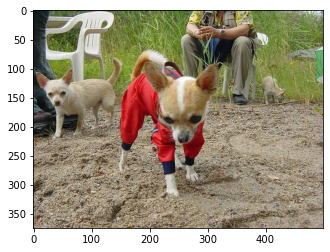

In [13]:
show_image(image_path=data_example_path)

Display the first batch of images.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


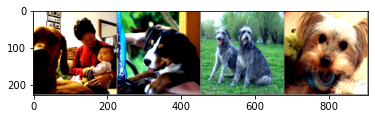

Image 1 label: redbone
Image 2 label: Appenzeller
Image 3 label: Scottish_deerhound
Image 4 label: Australian_terrier


In [14]:
# Get some random training images
dataiter = iter(dataloaders["val"])
images, labels = dataiter.next()

# Show images
show_batch_of_images(torchvision.utils.make_grid(images))

# Print labels
for i in range(len(images)):
    print(f"Image {i+1} label: {class_names[labels[i]].split('-')[1]}")

### Register AML Dataset

Register the data as a file dataset to the AML workspace for easy accessibility throughout the ML lifecycle.

In [15]:
# Register the dataset
dataset = dataset.register(workspace=ws,
                           name=dataset_name,
                           tags=dataset_tags,
                           description=dataset_description,
                           create_new_version=True)

Now you should be able to see your registered AML dataset in the AML workspace:
    
<img src="../docs/images/aml_dataset.png" alt="aml_dataset" width="600"/>   